In [69]:
%matplotlib inline

In [70]:
from pathlib import Path
import re
import matplotlib.pyplot as plt
from matplotlib import pyplot
import eelbrain
import mne
#import trftools
from pprint import pprint
import numpy as np

import emd  # Ensure you ran: pip install EMD-signal
from scipy.signal import hilbert

import csv
import pandas as pd

In [71]:
## Natives ##
## Import the raw EEG data of ESLs(Alice)

STIMULI = [str(i) for i in range(1, 13)]
DATA_ROOT = Path("/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results") #Path("/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results")  #Path("~").expanduser() / 'Data' / 'Alice'
PREDICTOR_audio_DIR = DATA_ROOT / 'TRFs_pridictors/audio_predictors'
PREDICTOR_word_DIR = DATA_ROOT / 'TRFs_pridictors/word_predictors'
IMF_DIR = DATA_ROOT/ "TRFs_pridictors/IF_predictors"
F0_DIR = DATA_ROOT/ "TRFs_pridictors/F0_predictors"
IMFsLIST = [path.name for path in IMF_DIR.iterdir() if re.match(r'Alice_IF_IMF_*', path.name)]
EEG_DIR = DATA_ROOT / 'EEG_Natives' / 'Alice_natives_ICAed_fif'
SUBJECTS = [path.name for path in EEG_DIR.iterdir() if re.match(r'S\d*', path.name[:4])]
# Define a target directory for TRF estimates and make sure the directory is created
TRF_DIR = DATA_ROOT / 'TRFs_Natives'
TRF_DIR.mkdir(exist_ok=True)
print(SUBJECTS)
print(len(SUBJECTS))

wOnset_DIR = DATA_ROOT / 'EEG_Natives' / 'Alice_Natives_wOnset_raw_epochs'
wOnset_DIR .mkdir(exist_ok=True)

['S44_Alice-natives_sfreq-100_raw.fif', 'S20_Alice-natives_sfreq-100_raw.fif', 'S13_Alice-natives_sfreq-100_raw.fif', 'S01_Alice-natives_sfreq-100_raw.fif', 'S16_Alice-natives_sfreq-100_raw.fif', 'S41_Alice-natives_sfreq-100_raw.fif', 'S25_Alice-natives_sfreq-100_raw.fif', 'S37_Alice-natives_sfreq-100_raw.fif', 'S04_Alice-natives_sfreq-100_raw.fif', 'S18_Alice-natives_sfreq-100_raw.fif', 'S39_Alice-natives_sfreq-100_raw.fif', 'S10_Alice-natives_sfreq-100_raw.fif', 'S15_Alice-natives_sfreq-100_raw.fif', 'S26_Alice-natives_sfreq-100_raw.fif', 'S42_Alice-natives_sfreq-100_raw.fif', 'S34_Alice-natives_sfreq-100_raw.fif', 'S38_Alice-natives_sfreq-100_raw.fif', 'S19_Alice-natives_sfreq-100_raw.fif', 'S06_Alice-natives_sfreq-100_raw.fif', 'S35_Alice-natives_sfreq-100_raw.fif', 'S14_Alice-natives_sfreq-100_raw.fif', 'S03_Alice-natives_sfreq-100_raw.fif', 'S11_Alice-natives_sfreq-100_raw.fif', 'S22_Alice-natives_sfreq-100_raw.fif', 'S05_Alice-natives_sfreq-100_raw.fif', 'S36_Alice-natives_sfreq

In [72]:
# Import the csv data
csv_data = DATA_ROOT / "Alice(EEG_mat_and stimuli)" / "AliceChapterOne-EEG.csv"  # self-made LMM data form


word_onset_LIST = []
with open(csv_data, "r", encoding="UTF-8") as f:
    fileDF = pd.read_csv(f, sep=",")
    #print(fileDF.columns)
    # word_onset = fileDF["onset"]
    # print(word_onset, type(word_onset))

    word_onset_essentials_DF = fileDF.iloc[:,[0, 1, 2] ]     # first column
    #print(word_onset_essentials_DF["onset"], word_onset_essentials_DF["onset"])
    #print()

    for i in range(1, 13):
        print(i)
        #w_S = word_onset_essentials_DF.loc[:, [i]["Word"]]
        #wOnset_F = word_onset_essentials_DF.loc[:, 2]
        #print(w_S)

        wOnset_DF = word_onset_essentials_DF.loc[word_onset_essentials_DF["Segment"] == 2, :]
        print(wOnset_DF, type(wOnset_DF))
        print(wOnset_DF["onset"])
        """
        if 
        w_S = word_onset_essentials_DF.iloc[i, 0]
        wOnset_F = word_onset_essentials_DF.iloc[i, 2]
        print(w_S, wOnset_F)
        """

1
         Word  Segment      onset
174       but        2   0.479840
175      when        2   0.592424
176       the        2   0.810806
177    Rabbit        2   0.912952
178  actually        2   1.415810
..        ...      ...        ...
346       was        2  58.681660
347     going        2  58.861252
348        to        2  59.148599
349    happen        2  59.251158
350      next        2  59.687374

[177 rows x 3 columns] <class 'pandas.core.frame.DataFrame'>
174     0.479840
175     0.592424
176     0.810806
177     0.912952
178     1.415810
         ...    
346    58.681660
347    58.861252
348    59.148599
349    59.251158
350    59.687374
Name: onset, Length: 177, dtype: float64
2
         Word  Segment      onset
174       but        2   0.479840
175      when        2   0.592424
176       the        2   0.810806
177    Rabbit        2   0.912952
178  actually        2   1.415810
..        ...      ...        ...
346       was        2  58.681660
347     going        2  58

In [61]:
for subject in SUBJECTS:#[0:3]:
    #print("subject_num=", subject)
    
    # 1. Load Raw as an Eelbrain-compatible object
    raw = mne.io.read_raw_fif(EEG_DIR / f'{subject}', preload=True)
    raw_sfreq = raw.info['sfreq']
    
    # 2. Get the events for the 12 tapes
    events_DICT = eelbrain.load.mne.events(raw)
    print(events_DICT["event"])

    """
    if len(events_DICT["event"])==12:
        pass
    else:
        print(subject[:3], "tape_length", )"""

Factor(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], name='event')
Factor(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], name='event')
Factor(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], name='event')
Factor(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], name='event')
Factor(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], name='event')
Factor(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], name='event')
Factor(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], name='event')
Factor(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], name='event')
Factor(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], name='event')
Factor(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], name='event')
Factor(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], name='event')
Factor(['1', '2', '3', '4', '5', '6', '7', '8', '9', '

In [203]:
for i, stimulus_idx in enumerate(trial_indexes[1:]):
    print("i = ", i)
    print("stimulus_idx", stimulus_idx)

i =  0
stimulus_idx 1
i =  1
stimulus_idx 2
i =  2
stimulus_idx 3
i =  3
stimulus_idx 4
i =  4
stimulus_idx 5
i =  5
stimulus_idx 6
i =  6
stimulus_idx 7
i =  7
stimulus_idx 8
i =  8
stimulus_idx 9
i =  9
stimulus_idx 10
i =  10
stimulus_idx 11


In [ ]:
## (Use this!!!)Trying the old way (Sub order 1st then tape 2nd)##

# epochs parameters
# Define your epoch window
# We use a 1.5s window (including buffers for HHSA)
tmin, tmax = -0.3, 1.2 

for subject in SUBJECTS:#[0:3]:
    print("subject_num=", subject)
    
    # 1. Load Raw as an Eelbrain-compatible object
    raw = mne.io.read_raw_fif(EEG_DIR / f'{subject}', preload=True)
    raw_sfreq = raw.info['sfreq']
    raw_ch_names = raw
    
    # 2. Get the events for the 12 tapes
    events_DICT = eelbrain.load.mne.events(raw)
    trial_indexes = [STIMULI.index(stimulus) for stimulus in events_DICT['event']]

    if len(events_DICT['event'])==12:
        # Get the actual word onset based on EEG triggers datapoints
        all_tapes_epochs_LIST = []
        for i, stimulus_idx in enumerate(trial_indexes):
            print("tape_num=", stimulus_idx+1)
            
            # Find the word onset time based on the segment sequence    
            wOnset_perTape_DF = word_onset_essentials_DF.loc[word_onset_essentials_DF["Segment"] == stimulus_idx+1, :] #.to_numpy()
            print("wOnset_perTape_DF=", wOnset_perTape_DF[:3])
            wOnset_time_ndarray = wOnset_perTape_DF["onset"].to_numpy() #*raw_sfreq
            #wOnset_datapoints_ndarray = wOnset_perTape_DF["onset"].to_numpy()*raw_sfreq
            #print("wOnset_datapoints_ndarray=", wOnset_datapoints_ndarray[0:15], type(wOnset_datapoints_ndarray))
    
            # Get the tape start time
            tape_start_datapoints_npINT64 = events_DICT[i]['i_start']
            tape_start_time_npFLOAT64 = tape_start_datapoints_npINT64 / raw_sfreq
            #print("tape_start_datapoints_npINT64=", tape_start_datapoints_npINT64)
            print("tape_start_time_npFLOAT64=", tape_start_time_npFLOAT64, type(tape_start_time_npFLOAT64))
    
            # Get the actual word onset time by the triggers
            absolute_onsets_time_ndarray = tape_start_time_npFLOAT64 + wOnset_time_ndarray #((tape_start_time_npFLOAT64 + wOnset_time_ndarray)*raw_sfreq).astype(int)
            print("absolute_onsets_time_ndarray=", absolute_onsets_time_ndarray[0:15])
            #abs_wOnsets_dta_ndarray = tape_start_datapoints_npINT64 + wOnset_datapoints_ndarray
            #print("abs_wOnsets_dta_ndarray=", abs_wOnsets_dta_ndarray[0:15])
            
            # To exclude the decimal but leave the integer along, and turn FLOAT into INT
            abs_wOnsets_dta_ndarray = (absolute_onsets_time_ndarray*raw_sfreq).astype(int) #np.trunc(abs_wOnsets_dta_ndarray).astype(int)
            print("rounded_abs_wOnsets_dta_ndarray=", abs_wOnsets_dta_ndarray[0:15])
            
            # Make epochs
            # Create the empty (N, 3) event matrix based on wOnset per tape
            wOnset_events = len(abs_wOnsets_dta_ndarray)
            wOnset_perTape_events = np.zeros((wOnset_events, 3), dtype=int)
            # Fill the columns
            wOnset_perTape_events[:, 0] = abs_wOnsets_dta_ndarray #abs_wOnsets_dta_ndarray  # Column 0: The sample indices
            wOnset_perTape_events[:, 2] = stimulus_idx+1           # Column 2: The event ID (e.g., 1)
            #print(wOnset_perTape_events)
            
            #word_perTape_epochs = mne.epochs(raw, tmin=tmin, tmax=tmax, baseline=None, events=wOnset_perTape_events)
            tape_perTape_epochs = mne.Epochs(raw, events=wOnset_perTape_events, event_id=stimulus_idx+1, tmin=tmin, tmax=tmax, baseline=None, preload=True)
            print(len(tape_perTape_epochs), tape_perTape_epochs)
            print("Droppred bad epochs=", tape_perTape_epochs.drop_bad())
            
            all_tapes_epochs_LIST.append(tape_perTape_epochs)
            wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
        #wOnset_epochs.save(wOnset_DIR / Path('%s_Natives_wOnset_epochs_allTapes_raw.fif' %subject[:3]), overwrite=True)
        print("subject_num=", subject[:4], "wOnset epoch saved.")
        
    else:  # For those who only start on the 2nd tape
        # Get the actual word onset based on EEG triggers datapoints
        all_tapes_epochs_LIST = []
        for i, stimulus_idx in enumerate(trial_indexes[1:]):
            print("tape_num=", stimulus_idx+1)
            
            # Find the word onset time based on the segment sequence    
            wOnset_perTape_DF = word_onset_essentials_DF.loc[word_onset_essentials_DF["Segment"] == stimulus_idx+1, :] #.to_numpy()
            print("wOnset_perTape_DF=", wOnset_perTape_DF[:3])
            wOnset_time_ndarray = wOnset_perTape_DF["onset"].to_numpy() #*raw_sfreq
            #wOnset_datapoints_ndarray = wOnset_perTape_DF["onset"].to_numpy()*raw_sfreq
            #print("wOnset_datapoints_ndarray=", wOnset_datapoints_ndarray[0:15], type(wOnset_datapoints_ndarray))
    
            # Get the tape start time
            tape_start_datapoints_npINT64 = events_DICT[i]['i_start']
            tape_start_time_npFLOAT64 = tape_start_datapoints_npINT64 / raw_sfreq
            print("tape_start_datapoints_npINT64=", tape_start_datapoints_npINT64)
            print("tape_start_time_npFLOAT64=", tape_start_time_npFLOAT64, type(tape_start_time_npFLOAT64))
    
            # Get the actual word onset time by the triggers
            absolute_onsets_time_ndarray = tape_start_time_npFLOAT64 + wOnset_time_ndarray
            print("absolute_onsets_time_ndarray=", absolute_onsets_time_ndarray[0:15])
            #abs_wOnsets_dta_ndarray = tape_start_datapoints_npINT64 + wOnset_datapoints_ndarray
            #print("abs_wOnsets_dta_ndarray=", abs_wOnsets_dta_ndarray[0:15])
            
            # To exclude the decimal but leave the integer along, and turn FLOAT into INT
            abs_wOnsets_dta_ndarray = (absolute_onsets_time_ndarray*raw_sfreq).astype(int) #np.trunc(abs_wOnsets_dta_ndarray).astype(int)
            print("rounded_abs_wOnsets_dta_ndarray=", abs_wOnsets_dta_ndarray[0:15])
            
            # Make epochs
            # Create the empty (N, 3) event matrix based on wOnset per tape
            wOnset_events = len(abs_wOnsets_dta_ndarray)
            wOnset_perTape_events = np.zeros((wOnset_events, 3), dtype=int)
            # Fill the columns
            wOnset_perTape_events[:, 0] = abs_wOnsets_dta_ndarray #abs_wOnsets_dta_ndarray  # Column 0: The sample indices
            wOnset_perTape_events[:, 2] = stimulus_idx+1           # Column 2: The event ID (e.g., 1)
            #print(wOnset_perTape_events)
            
            #word_perTape_epochs = mne.epochs(raw, tmin=tmin, tmax=tmax, baseline=None, events=wOnset_perTape_events)
            tape_perTape_epochs = mne.Epochs(raw, events=wOnset_perTape_events, event_id=stimulus_idx+1, tmin=tmin, tmax=tmax, baseline=None, preload=True)
            print(len(tape_perTape_epochs), tape_perTape_epochs)
            print("Droppred bad epochs=", tape_perTape_epochs.drop_bad())
            
            all_tapes_epochs_LIST.append(tape_perTape_epochs)
            wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
        #wOnset_epochs.save(wOnset_DIR / Path('%s_Natives_wOnset_epochs_11Tapes_raw.fif' %subject[:3]), overwrite=True)
        print("subject_num=", subject[:4], "wOnset epoch saved.")

"""
    # 5. Combine all words from all tapes into one Dataset
    # This 'ds' will have a column for 'EEG' and can have a column for 'Subject'
    ds_all_words = eelbrain.combine(all_tapes_epochs)
    
    # Now you can access the data for HHSA:
    # eeg_data = ds_all_words['eeg'].get_data()
    """

subject_num= S44_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 1.72 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [1.766    2.282721 2.504543 2.976929 3.072925 3.336327 4.030749 4.519918
 4.658712 5.02449  5.204082 5.374596 5.826667 5.994286 6.118799]
rounded_abs_wOnsets_dta_ndarray= [176 228 250 297 307 333 403 451 465 502 520 537 582 599 611]
174 <Epochs |  174 events (all good), -0.3 – 1.2 s, baseline off, ~11.9 MB, data loaded,
 '1': 174>
Droppred bad epochs= None
tape_num= 2
wOnset_perTape_DF=      Word  Segment     onset
174   but        2  0.479840
175  when        2  0.592424
176   the        2  0.810806
tape_start_time_npFLOAT64= 59.34 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [59.81983957 59.9324244  60.1508064  60.2529524  60.7558104  61.2586674
 61.7256054  61.8977774  62.5517284  62.7

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 3
wOnset_perTape_DF=       Word  Segment     onset
351  First        3  0.478723
352    she        3  0.986270
353  tried        3  1.201781
tape_start_time_npFLOAT64= 120.23 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [120.7087234  121.21626979 121.43178079 121.73109979 121.83464279
 122.06633779 122.41354879 122.54524979 122.83259679 123.07205279
 123.19178079 123.37382779 123.56293679 123.94606579 124.73626979]
rounded_abs_wOnsets_dta_ndarray= [12070 12121 12143 12173 12183 12206 12241 12254 12283 12307 12319 12337
 12356 12394 12473]
184 <Epochs |  184 events (all good), -0.3 – 1.2 s, baseline off, ~12.6 MB, data loaded,
 '3': 184>
Droppred bad epochs= None
tape_num= 4
wOnset_perTape_DF=         Word  Segment     onset
535     must        4  0.398386
536       be        4  0.689428
537  getting        4  0.840938
tape_start_time_npFLOAT64= 183.55 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [183.94838579 184.23942763 184.39093763 184.67634963 185.092891

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 6
wOnset_perTape_DF=       Word  Segment     onset
942    Now        6  0.323245
943  Dinah        6  0.568709
944   tell        6  1.039809
tape_start_time_npFLOAT64= 319.9 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [320.2232453  320.46870874 320.93980874 321.32293774 321.49055674
 321.63040174 322.28076174 322.50050174 322.74769974 323.10688374
 323.27904174 323.43488074 324.63940074 324.86713174 325.87259774]
rounded_abs_wOnsets_dta_ndarray= [32022 32046 32093 32132 32149 32163 32228 32250 32274 32310 32327 32343
 32463 32486 32587]
197 <Epochs |  197 events (all good), -0.3 – 1.2 s, baseline off, ~13.5 MB, data loaded,
 '6': 197>
Droppred bad epochs= None
tape_num= 7
wOnset_perTape_DF=           Word  Segment     onset
1139  Suddenly        7  0.586736
1140       she        7  1.179532
1141      came        7  1.418988
tape_start_time_npFLOAT64= 383.75 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [384.33673636 384.92953219 385.16898819 385.44436219 385

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 8
wOnset_perTape_DF=       Word  Segment     onset
1317   and        8  0.342000
1318  even        8  0.453317
1319    if        8  0.696699
tape_start_time_npFLOAT64= 446.71 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [447.052      447.16331668 447.40669868 447.67009968 447.77785468
 448.10112068 448.29268468 448.49589968 449.21458968 449.48996368
 449.75343168 450.91472568 450.99933868 451.19009968 451.38166468]
rounded_abs_wOnsets_dta_ndarray= [44705 44716 44740 44767 44777 44810 44829 44849 44921 44948 44975 45091
 45099 45119 45138]
175 <Epochs |  175 events (all good), -0.3 – 1.2 s, baseline off, ~12.0 MB, data loaded,
 '8': 175>
Droppred bad epochs= None
tape_num= 9
wOnset_perTape_DF=      Word  Segment     onset
1492   No        9  0.432017
1493    I        9  1.046815
1494   ll        9  1.198494
tape_start_time_npFLOAT64= 504.09 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [504.52201742 505.13681478 505.28849378 505.48402578 505.84320978
 506.2238

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 10
wOnset_perTape_DF=          Word  Segment     onset
1648     What       10  1.051981
1649        a       10  1.160767
1650  curious       10  1.308375
tape_start_time_npFLOAT64= 561.36 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [562.4119808 562.520767  562.668375  563.50647   564.147119  564.429088
 565.030205  565.170893  565.470007  565.553817  565.962269  566.140483
 566.267454  566.364853  567.816674 ]
rounded_abs_wOnsets_dta_ndarray= [56241 56252 56266 56350 56414 56442 56503 56517 56547 56555 56596 56614
 56626 56636 56781]
187 <Epochs |  187 events (all good), -0.3 – 1.2 s, baseline off, ~12.8 MB, data loaded,
 '10': 187>
Droppred bad epochs= None


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=        Word  Segment     onset
1835    she       11  0.274485
1836  could       11  0.489783
1837    see       11  0.701863
tape_start_time_npFLOAT64= 622.68 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [622.95448538 623.16978326 623.38186326 623.74447727 623.95998726
 624.29522526 624.81005526 625.04951126 625.13332026 626.25876226
 626.37582326 626.54610926 626.88134726 627.01304826 627.57576926]
rounded_abs_wOnsets_dta_ndarray= [62295 62316 62338 62374 62395 62429 62481 62504 62513 62625 62637 62654
 62688 62701 62757]
157 <Epochs |  157 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '11': 157>
Droppred bad epochs= None


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 12
wOnset_perTape_DF=       Word  Segment     onset
1992  Soon       12  0.229476
1993   her       12  0.504358
1994   eye       12  0.658032
tape_start_time_npFLOAT64= 678.91 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [679.13947622 679.41435823 679.56803223 679.88492422 680.17623622
 680.35186322 680.42514622 680.71104623 681.13009422 681.59703323
 681.70478823 681.83648922 682.20350122 682.47104623 682.55485622]
rounded_abs_wOnsets_dta_ndarray= [67913 67941 67956 67988 68017 68035 68042 68071 68113 68159 68170 68183
 68220 68247 68255]
137 <Epochs |  137 events (all good), -0.3 – 1.2 s, baseline off, ~9.4 MB, data loaded,
 '12': 137>
Droppred bad epochs= None


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


subject_num= S44_ wOnset epoch saved.
subject_num= S20_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 4.13 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [4.176    4.692721 4.914543 5.386929 5.482925 5.746327 6.440749 6.929918
 7.068712 7.43449  7.614082 7.784596 8.236667 8.404286 8.528799]
rounded_abs_wOnsets_dta_ndarray= [417 469 491 538 548 574 644 692 706 743 761 778 823 840 852]
174 <Epochs |  174 events (all good), -0.3 – 1.2 s, baseline off, ~11.9 MB, data loaded,
 '1': 174>
Droppred bad epochs= None
tape_num= 2
wOnset_perTape_DF=      Word  Segment     onset
174   but        2  0.479840
175  when        2  0.592424
176   the        2  0.810806
tape_start_time_npFLOAT64= 61.75 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [62.22983957 62.3424244  62.5608064  62.6629524  63.1658104  63.6686674
 64

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

214 <Epochs |  214 events (all good), -0.3 – 1.2 s, baseline off, ~14.6 MB, data loaded,
 '4': 214>
Droppred bad epochs= None
tape_num= 5
wOnset_perTape_DF=      Word  Segment     onset
749   And        5  0.561146
750  what        5  0.689847
751    an        5  0.936113
tape_start_time_npFLOAT64= 256.05 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [256.61114563 256.73984717 256.98611317 257.16570517 257.66856217
 257.90801817 258.15754717 258.27097617 258.36298417 258.57849417
 258.69822217 258.89748117 260.15890217 260.57795017 260.71601117]
rounded_abs_wOnsets_dta_ndarray= [25661 25673 25698 25716 25766 25790 25815 25827 25836 25857 25869 25889
 26015 26057 26071]
193 <Epochs |  193 events (all good), -0.3 – 1.2 s, baseline off, ~13.2 MB, data loaded,
 '5': 193>
Droppred bad epochs= None
tape_num= 6
wOnset_perTape_DF=       Word  Segment     onset
942    Now        6  0.323245
943  Dinah        6  0.568709
944   tell        6  1.039809
tape_start_time_npFLOAT64= 322.38 <cl

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 7
wOnset_perTape_DF=           Word  Segment     onset
1139  Suddenly        7  0.586736
1140       she        7  1.179532
1141      came        7  1.418988
tape_start_time_npFLOAT64= 386.23 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [386.81673636 387.40953219 387.6489882  387.9243622  388.2811482
 388.5349742  388.9779682  389.22939619 389.6005532  390.4865392
 390.6900762  390.94150519 391.0253152  391.5042262  392.7374232 ]
rounded_abs_wOnsets_dta_ndarray= [38681 38740 38764 38792 38828 38853 38897 38922 38960 39048 39069 39094
 39102 39150 39273]
178 <Epochs |  178 events (all good), -0.3 – 1.2 s, baseline off, ~12.2 MB, data loaded,
 '7': 178>
Droppred bad epochs= None
tape_num= 8
wOnset_perTape_DF=       Word  Segment     onset
1317   and        8  0.342000
1318  even        8  0.453317
1319    if        8  0.696699
tape_start_time_npFLOAT64= 449.17 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [449.512      449.62331668 449.86669868 450.13009968 450.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=      Word  Segment     onset
1492   No        9  0.432017
1493    I        9  1.046815
1494   ll        9  1.198494
tape_start_time_npFLOAT64= 506.55 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [506.98201742 507.59681478 507.74849378 507.94402578 508.30320978
 508.68384078 508.90184878 509.25957878 509.33966278 509.66810778
 509.99137278 510.08151878 510.17096478 510.53014878 511.02026378]
rounded_abs_wOnsets_dta_ndarray= [50698 50759 50774 50794 50830 50868 50890 50925 50933 50966 50999 51008
 51017 51053 51102]
156 <Epochs |  156 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '9': 156>
Droppred bad epochs= None
tape_num= 10
wOnset_perTape_DF=          Word  Segment     onset
1648     What       10  1.051981
1649        a       10  1.160767
1650  curious       10  1.308375
tape_start_time_npFLOAT64= 563.83 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [564.8819808 564.990767  565.138375  565.97647   566.617119  5

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=        Word  Segment     onset
1835    she       11  0.274485
1836  could       11  0.489783
1837    see       11  0.701863
tape_start_time_npFLOAT64= 625.14 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [625.41448538 625.62978327 625.84186327 626.20447727 626.41998727
 626.75522527 627.27005526 627.50951127 627.59332026 628.71876227
 628.83582326 629.00610926 629.34134726 629.47304826 630.03576926]
rounded_abs_wOnsets_dta_ndarray= [62541 62562 62584 62620 62641 62675 62727 62750 62759 62871 62883 62900
 62934 62947 63003]
157 <Epochs |  157 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '11': 157>
Droppred bad epochs= None
tape_num= 12
wOnset_perTape_DF=       Word  Segment     onset
1992  Soon       12  0.229476
1993   her       12  0.504358
1994   eye       12  0.658032
tape_start_time_npFLOAT64= 681.37 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [681.59947622 681.87435823 682.02803223 682.34492422 682.6362362

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


subject_num= S20_ wOnset epoch saved.
subject_num= S13_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 8.53 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [ 8.576     9.092721  9.314543  9.786929  9.882925 10.146327 10.840749
 11.329918 11.468712 11.83449  12.014082 12.184596 12.636667 12.804286
 12.928799]
rounded_abs_wOnsets_dta_ndarray= [ 857  909  931  978  988 1014 1084 1132 1146 1183 1201 1218 1263 1280
 1292]
174 <Epochs |  174 events (all good), -0.3 – 1.2 s, baseline off, ~11.9 MB, data loaded,
 '1': 174>
Droppred bad epochs= None
tape_num= 2
wOnset_perTape_DF=      Word  Segment     onset
174   but        2  0.479840
175  when        2  0.592424
176   the        2  0.810806
tape_start_time_npFLOAT64= 66.15 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [66.62983957 66.7424244  66.9608064  67.062

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

tape_num= 5
wOnset_perTape_DF=      Word  Segment     onset
749   And        5  0.561146
750  what        5  0.689847
751    an        5  0.936113
tape_start_time_npFLOAT64= 260.42 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [260.98114563 261.10984717 261.35611317 261.53570517 262.03856217
 262.27801817 262.52754717 262.64097617 262.73298417 262.94849417
 263.06822217 263.26748117 264.52890217 264.94795017 265.08601117]
rounded_abs_wOnsets_dta_ndarray= [26098 26110 26135 26153 26203 26227 26252 26264 26273 26294 26306 26326
 26452 26494 26508]
193 <Epochs |  193 events (all good), -0.3 – 1.2 s, baseline off, ~13.2 MB, data loaded,
 '5': 193>
Droppred bad epochs= None
tape_num= 6
wOnset_perTape_DF=       Word  Segment     onset
942    Now        6  0.323245
943  Dinah        6  0.568709
944   tell        6  1.039809
tape_start_time_npFLOAT64= 326.76 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [327.0832453  327.32870874 327.79980874 328.18293774 328.35055674
 328.4904

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


178 <Epochs |  178 events (all good), -0.3 – 1.2 s, baseline off, ~12.2 MB, data loaded,
 '7': 178>
Droppred bad epochs= None
tape_num= 8
wOnset_perTape_DF=       Word  Segment     onset
1317   and        8  0.342000
1318  even        8  0.453317
1319    if        8  0.696699
tape_start_time_npFLOAT64= 453.55 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [453.892      454.00331668 454.24669868 454.51009968 454.61785468
 454.94112068 455.13268468 455.33589968 456.05458968 456.32996368
 456.59343168 457.75472568 457.83933868 458.03009968 458.22166468]
rounded_abs_wOnsets_dta_ndarray= [45389 45400 45424 45451 45461 45494 45513 45533 45605 45632 45659 45775
 45783 45803 45822]
175 <Epochs |  175 events (all good), -0.3 – 1.2 s, baseline off, ~12.0 MB, data loaded,
 '8': 175>
Droppred bad epochs= None


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=      Word  Segment     onset
1492   No        9  0.432017
1493    I        9  1.046815
1494   ll        9  1.198494
tape_start_time_npFLOAT64= 510.93 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [511.36201742 511.97681478 512.12849378 512.32402578 512.68320978
 513.06384078 513.28184878 513.63957878 513.71966278 514.04810778
 514.37137278 514.46151878 514.55096478 514.91014878 515.40026378]
rounded_abs_wOnsets_dta_ndarray= [51136 51197 51212 51232 51268 51306 51328 51363 51371 51404 51437 51446
 51455 51491 51540]
156 <Epochs |  156 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '9': 156>
Droppred bad epochs= None
tape_num= 10
wOnset_perTape_DF=          Word  Segment     onset
1648     What       10  1.051981
1649        a       10  1.160767
1650  curious       10  1.308375
tape_start_time_npFLOAT64= 568.21 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [569.2619808 569.370767  569.518375  570.35647   570.997119  5

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=        Word  Segment     onset
1835    she       11  0.274485
1836  could       11  0.489783
1837    see       11  0.701863
tape_start_time_npFLOAT64= 629.52 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [629.79448538 630.00978327 630.22186327 630.58447727 630.79998727
 631.13522527 631.65005526 631.88951127 631.97332026 633.09876227
 633.21582326 633.38610926 633.72134726 633.85304826 634.41576926]
rounded_abs_wOnsets_dta_ndarray= [62979 63000 63022 63058 63079 63113 63165 63188 63197 63309 63321 63338
 63372 63385 63441]
157 <Epochs |  157 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '11': 157>
Droppred bad epochs= None
tape_num= 12
wOnset_perTape_DF=       Word  Segment     onset
1992  Soon       12  0.229476
1993   her       12  0.504358
1994   eye       12  0.658032
tape_start_time_npFLOAT64= 685.75 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [685.97947622 686.25435823 686.40803223 686.72492422 687.0162362

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


subject_num= S13_ wOnset epoch saved.
subject_num= S01_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 3.73 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [3.776    4.292721 4.514543 4.986929 5.082925 5.346327 6.040749 6.529918
 6.668712 7.03449  7.214082 7.384596 7.836667 8.004286 8.128799]
rounded_abs_wOnsets_dta_ndarray= [377 429 451 498 508 534 604 652 666 703 721 738 783 800 812]
174 <Epochs |  174 events (all good), -0.3 – 1.2 s, baseline off, ~11.9 MB, data loaded,
 '1': 174>
Droppred bad epochs= None
tape_num= 2
wOnset_perTape_DF=      Word  Segment     onset
174   but        2  0.479840
175  when        2  0.592424
176   the        2  0.810806
tape_start_time_npFLOAT64= 61.34 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [61.81983957 61.9324244  62.1508064  62.2529524  62.7558104  63.2586674
 63

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

tape_num= 5
wOnset_perTape_DF=      Word  Segment     onset
749   And        5  0.561146
750  what        5  0.689847
751    an        5  0.936113
tape_start_time_npFLOAT64= 255.6 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [256.16114563 256.28984717 256.53611317 256.71570517 257.21856217
 257.45801817 257.70754717 257.82097617 257.91298417 258.12849417
 258.24822217 258.44748117 259.70890217 260.12795017 260.26601117]
rounded_abs_wOnsets_dta_ndarray= [25616 25628 25653 25671 25721 25745 25770 25782 25791 25812 25824 25844
 25970 26012 26026]
193 <Epochs |  193 events (all good), -0.3 – 1.2 s, baseline off, ~13.2 MB, data loaded,
 '5': 193>
Droppred bad epochs= None
tape_num= 6
wOnset_perTape_DF=       Word  Segment     onset
942    Now        6  0.323245
943  Dinah        6  0.568709
944   tell        6  1.039809
tape_start_time_npFLOAT64= 321.92 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [322.2432453  322.48870874 322.95980874 323.34293774 323.51055674
 323.65040

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


wOnset_perTape_DF=           Word  Segment     onset
1139  Suddenly        7  0.586736
1140       she        7  1.179532
1141      came        7  1.418988
tape_start_time_npFLOAT64= 385.75 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [386.33673636 386.92953219 387.16898819 387.44436219 387.80114819
 388.05497419 388.49796819 388.74939619 389.1205532  390.0065392
 390.21007619 390.46150519 390.5453152  391.02422619 392.2574232 ]
rounded_abs_wOnsets_dta_ndarray= [38633 38692 38716 38744 38780 38805 38849 38874 38912 39000 39021 39046
 39054 39102 39225]
178 <Epochs |  178 events (all good), -0.3 – 1.2 s, baseline off, ~12.2 MB, data loaded,
 '7': 178>
Droppred bad epochs= None
tape_num= 8
wOnset_perTape_DF=       Word  Segment     onset
1317   and        8  0.342000
1318  even        8  0.453317
1319    if        8  0.696699
tape_start_time_npFLOAT64= 448.71 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [449.052      449.16331668 449.40669868 449.67009968 449.77785468
 4

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=      Word  Segment     onset
1492   No        9  0.432017
1493    I        9  1.046815
1494   ll        9  1.198494
tape_start_time_npFLOAT64= 506.08 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [506.51201742 507.12681478 507.27849378 507.47402578 507.83320978
 508.21384078 508.43184878 508.78957878 508.86966278 509.19810778
 509.52137278 509.61151878 509.70096478 510.06014878 510.55026378]
rounded_abs_wOnsets_dta_ndarray= [50651 50712 50727 50747 50783 50821 50843 50878 50886 50919 50952 50961
 50970 51006 51055]
156 <Epochs |  156 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '9': 156>
Droppred bad epochs= None
tape_num= 10
wOnset_perTape_DF=          Word  Segment     onset
1648     What       10  1.051981
1649        a       10  1.160767
1650  curious       10  1.308375
tape_start_time_npFLOAT64= 563.35 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [564.4019808 564.510767  564.658375  565.49647   566.137119  5

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=        Word  Segment     onset
1835    she       11  0.274485
1836  could       11  0.489783
1837    see       11  0.701863
tape_start_time_npFLOAT64= 624.67 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [624.94448538 625.15978326 625.37186327 625.73447727 625.94998727
 626.28522527 626.80005526 627.03951126 627.12332026 628.24876226
 628.36582326 628.53610926 628.87134726 629.00304826 629.56576926]
rounded_abs_wOnsets_dta_ndarray= [62494 62515 62537 62573 62594 62628 62680 62703 62712 62824 62836 62853
 62887 62900 62956]
157 <Epochs |  157 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '11': 157>
Droppred bad epochs= None
tape_num= 12
wOnset_perTape_DF=       Word  Segment     onset
1992  Soon       12  0.229476
1993   her       12  0.504358
1994   eye       12  0.658032
tape_start_time_npFLOAT64= 680.88 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [681.10947622 681.38435823 681.53803223 681.85492422 682.1462362

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


subject_num= S01_ wOnset epoch saved.
subject_num= S16_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 5.67 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [ 5.716     6.232721  6.454543  6.926929  7.022925  7.286327  7.980749
  8.469918  8.608712  8.97449   9.154082  9.324596  9.776667  9.944286
 10.068799]
rounded_abs_wOnsets_dta_ndarray= [ 571  623  645  692  702  728  798  846  860  897  915  932  977  994
 1006]
174 <Epochs |  174 events (all good), -0.3 – 1.2 s, baseline off, ~11.9 MB, data loaded,
 '1': 174>
Droppred bad epochs= None
tape_num= 2
wOnset_perTape_DF=      Word  Segment     onset
174   but        2  0.479840
175  when        2  0.592424
176   the        2  0.810806
tape_start_time_npFLOAT64= 63.29 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [63.76983957 63.8824244  64.1008064  64.202

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

214 <Epochs |  214 events (all good), -0.3 – 1.2 s, baseline off, ~14.6 MB, data loaded,
 '4': 214>
Droppred bad epochs= None
tape_num= 5
wOnset_perTape_DF=      Word  Segment     onset
749   And        5  0.561146
750  what        5  0.689847
751    an        5  0.936113
tape_start_time_npFLOAT64= 257.54 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [258.10114563 258.22984717 258.47611317 258.65570517 259.15856217
 259.39801817 259.64754717 259.76097617 259.85298417 260.06849417
 260.18822217 260.38748117 261.64890217 262.06795017 262.20601117]
rounded_abs_wOnsets_dta_ndarray= [25810 25822 25847 25865 25915 25939 25964 25976 25985 26006 26018 26038
 26164 26206 26220]
193 <Epochs |  193 events (all good), -0.3 – 1.2 s, baseline off, ~13.2 MB, data loaded,
 '5': 193>
Droppred bad epochs= None
tape_num= 6
wOnset_perTape_DF=       Word  Segment     onset
942    Now        6  0.323245
943  Dinah        6  0.568709
944   tell        6  1.039809
tape_start_time_npFLOAT64= 323.86 <cl

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 7
wOnset_perTape_DF=           Word  Segment     onset
1139  Suddenly        7  0.586736
1140       she        7  1.179532
1141      came        7  1.418988
tape_start_time_npFLOAT64= 387.69 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [388.27673636 388.86953219 389.10898819 389.38436219 389.74114819
 389.99497419 390.43796819 390.68939619 391.0605532  391.9465392
 392.15007619 392.40150519 392.48531519 392.96422619 394.19742319]
rounded_abs_wOnsets_dta_ndarray= [38827 38886 38910 38938 38974 38999 39043 39068 39106 39194 39215 39240
 39248 39296 39419]
178 <Epochs |  178 events (all good), -0.3 – 1.2 s, baseline off, ~12.2 MB, data loaded,
 '7': 178>
Droppred bad epochs= None
tape_num= 8
wOnset_perTape_DF=       Word  Segment     onset
1317   and        8  0.342000
1318  even        8  0.453317
1319    if        8  0.696699
tape_start_time_npFLOAT64= 450.65 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [450.992      451.10331668 451.34669868 451.61009968 451

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=      Word  Segment     onset
1492   No        9  0.432017
1493    I        9  1.046815
1494   ll        9  1.198494
tape_start_time_npFLOAT64= 508.02 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [508.45201742 509.06681478 509.21849378 509.41402578 509.77320978
 510.15384078 510.37184878 510.72957878 510.80966278 511.13810778
 511.46137278 511.55151878 511.64096478 512.00014878 512.49026378]
rounded_abs_wOnsets_dta_ndarray= [50845 50906 50921 50941 50977 51015 51037 51072 51080 51113 51146 51155
 51164 51200 51249]
156 <Epochs |  156 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '9': 156>
Droppred bad epochs= None
tape_num= 10
wOnset_perTape_DF=          Word  Segment     onset
1648     What       10  1.051981
1649        a       10  1.160767
1650  curious       10  1.308375
tape_start_time_npFLOAT64= 565.29 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [566.3419808 566.450767  566.598375  567.43647   568.077119  5

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=        Word  Segment     onset
1835    she       11  0.274485
1836  could       11  0.489783
1837    see       11  0.701863
tape_start_time_npFLOAT64= 626.61 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [626.88448538 627.09978327 627.31186327 627.67447727 627.88998727
 628.22522527 628.74005527 628.97951127 629.06332027 630.18876227
 630.30582326 630.47610926 630.81134726 630.94304827 631.50576927]
rounded_abs_wOnsets_dta_ndarray= [62688 62709 62731 62767 62788 62822 62874 62897 62906 63018 63030 63047
 63081 63094 63150]
157 <Epochs |  157 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '11': 157>
Droppred bad epochs= None
tape_num= 12
wOnset_perTape_DF=       Word  Segment     onset
1992  Soon       12  0.229476
1993   her       12  0.504358
1994   eye       12  0.658032
tape_start_time_npFLOAT64= 682.83 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [683.05947623 683.33435823 683.48803223 683.80492423 684.0962362

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


subject_num= S16_ wOnset epoch saved.
subject_num= S41_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 1.24 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [1.286    1.802721 2.024543 2.496929 2.592925 2.856327 3.550749 4.039918
 4.178712 4.54449  4.724082 4.894596 5.346667 5.514286 5.638799]
rounded_abs_wOnsets_dta_ndarray= [128 180 202 249 259 285 355 403 417 454 472 489 534 551 563]
174 <Epochs |  174 events (all good), -0.3 – 1.2 s, baseline off, ~11.9 MB, data loaded,
 '1': 174>
Droppred bad epochs= None
tape_num= 2
wOnset_perTape_DF=      Word  Segment     onset
174   but        2  0.479840
175  when        2  0.592424
176   the        2  0.810806
tape_start_time_npFLOAT64= 58.85 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [59.32983957 59.4424244  59.6608064  59.7629524  60.2658104  60.7686674
 61

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

tape_num= 5
wOnset_perTape_DF=      Word  Segment     onset
749   And        5  0.561146
750  what        5  0.689847
751    an        5  0.936113
tape_start_time_npFLOAT64= 253.11 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [253.67114563 253.79984717 254.04611317 254.22570517 254.72856217
 254.96801817 255.21754717 255.33097617 255.42298417 255.63849417
 255.75822217 255.95748117 257.21890217 257.63795017 257.77601117]
rounded_abs_wOnsets_dta_ndarray= [25367 25379 25404 25422 25472 25496 25521 25533 25542 25563 25575 25595
 25721 25763 25777]
193 <Epochs |  193 events (all good), -0.3 – 1.2 s, baseline off, ~13.2 MB, data loaded,
 '5': 193>
Droppred bad epochs= None
tape_num= 6
wOnset_perTape_DF=       Word  Segment     onset
942    Now        6  0.323245
943  Dinah        6  0.568709
944   tell        6  1.039809
tape_start_time_npFLOAT64= 319.43 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [319.7532453  319.99870874 320.46980874 320.85293774 321.02055674
 321.1604

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


178 <Epochs |  178 events (all good), -0.3 – 1.2 s, baseline off, ~12.2 MB, data loaded,
 '7': 178>
Droppred bad epochs= None
tape_num= 8
wOnset_perTape_DF=       Word  Segment     onset
1317   and        8  0.342000
1318  even        8  0.453317
1319    if        8  0.696699
tape_start_time_npFLOAT64= 446.22 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [446.562      446.67331668 446.91669868 447.18009968 447.28785468
 447.61112068 447.80268468 448.00589968 448.72458968 448.99996368
 449.26343168 450.42472568 450.50933868 450.70009968 450.89166468]
rounded_abs_wOnsets_dta_ndarray= [44656 44667 44691 44718 44728 44761 44780 44800 44872 44899 44926 45042
 45050 45070 45089]
175 <Epochs |  175 events (all good), -0.3 – 1.2 s, baseline off, ~12.0 MB, data loaded,
 '8': 175>
Droppred bad epochs= None
tape_num= 9
wOnset_perTape_DF=      Word  Segment     onset
1492   No        9  0.432017
1493    I        9  1.046815
1494   ll        9  1.198494
tape_start_time_npFLOAT64= 503.6 <cla

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


156 <Epochs |  156 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '9': 156>
Droppred bad epochs= None
tape_num= 10
wOnset_perTape_DF=          Word  Segment     onset
1648     What       10  1.051981
1649        a       10  1.160767
1650  curious       10  1.308375
tape_start_time_npFLOAT64= 560.88 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [561.9319808 562.040767  562.188375  563.02647   563.667119  563.949088
 564.550205  564.690893  564.990007  565.073817  565.482269  565.660483
 565.787454  565.884853  567.336674 ]
rounded_abs_wOnsets_dta_ndarray= [56193 56204 56218 56302 56366 56394 56455 56469 56499 56507 56548 56566
 56578 56588 56733]
187 <Epochs |  187 events (all good), -0.3 – 1.2 s, baseline off, ~12.8 MB, data loaded,
 '10': 187>
Droppred bad epochs= None


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=        Word  Segment     onset
1835    she       11  0.274485
1836  could       11  0.489783
1837    see       11  0.701863
tape_start_time_npFLOAT64= 622.2 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [622.47448538 622.68978327 622.90186327 623.26447727 623.47998727
 623.81522527 624.33005527 624.56951127 624.65332027 625.77876227
 625.89582326 626.06610927 626.40134727 626.53304827 627.09576927]
rounded_abs_wOnsets_dta_ndarray= [62247 62268 62290 62326 62347 62381 62433 62456 62465 62577 62589 62606
 62640 62653 62709]
157 <Epochs |  157 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '11': 157>
Droppred bad epochs= None
tape_num= 12
wOnset_perTape_DF=       Word  Segment     onset
1992  Soon       12  0.229476
1993   her       12  0.504358
1994   eye       12  0.658032
tape_start_time_npFLOAT64= 678.42 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [678.64947622 678.92435822 679.07803223 679.39492422 679.68623622

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


subject_num= S41_ wOnset epoch saved.
subject_num= S25_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 2.05 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [2.096    2.612721 2.834543 3.306929 3.402925 3.666327 4.360749 4.849918
 4.988712 5.35449  5.534082 5.704596 6.156667 6.324286 6.448799]
rounded_abs_wOnsets_dta_ndarray= [209 261 283 330 340 366 436 484 498 535 553 570 615 632 644]
174 <Epochs |  174 events (all good), -0.3 – 1.2 s, baseline off, ~11.9 MB, data loaded,
 '1': 174>
Droppred bad epochs= None
tape_num= 2
wOnset_perTape_DF=      Word  Segment     onset
174   but        2  0.479840
175  when        2  0.592424
176   the        2  0.810806
tape_start_time_npFLOAT64= 59.67 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [60.14983957 60.2624244  60.4808064  60.5829524  61.0858104  61.5886674
 62

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

tape_num= 5
wOnset_perTape_DF=      Word  Segment     onset
749   And        5  0.561146
750  what        5  0.689847
751    an        5  0.936113
tape_start_time_npFLOAT64= 253.92 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [254.48114563 254.60984717 254.85611317 255.03570517 255.53856217
 255.77801817 256.02754717 256.14097617 256.23298417 256.44849417
 256.56822217 256.76748117 258.02890217 258.44795017 258.58601117]
rounded_abs_wOnsets_dta_ndarray= [25448 25460 25485 25503 25553 25577 25602 25614 25623 25644 25656 25676
 25802 25844 25858]
193 <Epochs |  193 events (all good), -0.3 – 1.2 s, baseline off, ~13.2 MB, data loaded,
 '5': 193>
Droppred bad epochs= None
tape_num= 6
wOnset_perTape_DF=       Word  Segment     onset
942    Now        6  0.323245
943  Dinah        6  0.568709
944   tell        6  1.039809
tape_start_time_npFLOAT64= 320.25 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [320.5732453  320.81870874 321.28980874 321.67293774 321.84055674
 321.9804

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


178 <Epochs |  178 events (all good), -0.3 – 1.2 s, baseline off, ~12.2 MB, data loaded,
 '7': 178>
Droppred bad epochs= None
tape_num= 8
wOnset_perTape_DF=       Word  Segment     onset
1317   and        8  0.342000
1318  even        8  0.453317
1319    if        8  0.696699
tape_start_time_npFLOAT64= 447.03 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [447.372      447.48331668 447.72669868 447.99009968 448.09785468
 448.42112068 448.61268468 448.81589968 449.53458968 449.80996368
 450.07343168 451.23472568 451.31933868 451.51009968 451.70166468]
rounded_abs_wOnsets_dta_ndarray= [44737 44748 44772 44799 44809 44842 44861 44881 44953 44980 45007 45123
 45131 45151 45170]
175 <Epochs |  175 events (all good), -0.3 – 1.2 s, baseline off, ~12.0 MB, data loaded,
 '8': 175>
Droppred bad epochs= None
tape_num= 9
wOnset_perTape_DF=      Word  Segment     onset
1492   No        9  0.432017
1493    I        9  1.046815
1494   ll        9  1.198494
tape_start_time_npFLOAT64= 504.41 <cl

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


156 <Epochs |  156 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '9': 156>
Droppred bad epochs= None
tape_num= 10
wOnset_perTape_DF=          Word  Segment     onset
1648     What       10  1.051981
1649        a       10  1.160767
1650  curious       10  1.308375
tape_start_time_npFLOAT64= 561.7 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [562.7519808 562.860767  563.008375  563.84647   564.487119  564.769088
 565.370205  565.510893  565.810007  565.893817  566.302269  566.480483
 566.607454  566.704853  568.156674 ]
rounded_abs_wOnsets_dta_ndarray= [56275 56286 56300 56384 56448 56476 56537 56551 56581 56589 56630 56648
 56660 56670 56815]
187 <Epochs |  187 events (all good), -0.3 – 1.2 s, baseline off, ~12.8 MB, data loaded,
 '10': 187>
Droppred bad epochs= None


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=        Word  Segment     onset
1835    she       11  0.274485
1836  could       11  0.489783
1837    see       11  0.701863
tape_start_time_npFLOAT64= 623.01 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [623.28448538 623.49978327 623.71186327 624.07447727 624.28998727
 624.62522527 625.14005527 625.37951127 625.46332026 626.58876227
 626.70582326 626.87610926 627.21134726 627.34304826 627.90576927]
rounded_abs_wOnsets_dta_ndarray= [62328 62349 62371 62407 62428 62462 62514 62537 62546 62658 62670 62687
 62721 62734 62790]
157 <Epochs |  157 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '11': 157>
Droppred bad epochs= None
tape_num= 12
wOnset_perTape_DF=       Word  Segment     onset
1992  Soon       12  0.229476
1993   her       12  0.504358
1994   eye       12  0.658032
tape_start_time_npFLOAT64= 679.24 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [679.46947622 679.74435823 679.89803223 680.21492423 680.5062362

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


subject_num= S25_ wOnset epoch saved.
subject_num= S37_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 0.23 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [0.276    0.792721 1.014543 1.486929 1.582925 1.846327 2.540749 3.029918
 3.168712 3.53449  3.714082 3.884596 4.336667 4.504286 4.628799]
rounded_abs_wOnsets_dta_ndarray= [ 27  79 101 148 158 184 254 302 316 353 371 388 433 450 462]
173 <Epochs |  173 events (all good), -0.3 – 1.2 s, baseline off, ~11.8 MB, data loaded,
 '1': 173>
Droppred bad epochs= None
tape_num= 2
wOnset_perTape_DF=      Word  Segment     onset
174   but        2  0.479840
175  when        2  0.592424
176   the        2  0.810806
tape_start_time_npFLOAT64= 57.85 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [58.32983957 58.4424244  58.6608064  58.7629524  59.2658104  59.7686674
 60

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

tape_num= 5
wOnset_perTape_DF=      Word  Segment     onset
749   And        5  0.561146
750  what        5  0.689847
751    an        5  0.936113
tape_start_time_npFLOAT64= 252.1 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [252.66114563 252.78984717 253.03611317 253.21570517 253.71856217
 253.95801817 254.20754717 254.32097617 254.41298417 254.62849417
 254.74822217 254.94748117 256.20890217 256.62795017 256.76601117]
rounded_abs_wOnsets_dta_ndarray= [25266 25278 25303 25321 25371 25395 25420 25432 25441 25462 25474 25494
 25620 25662 25676]
193 <Epochs |  193 events (all good), -0.3 – 1.2 s, baseline off, ~13.2 MB, data loaded,
 '5': 193>
Droppred bad epochs= None
tape_num= 6
wOnset_perTape_DF=       Word  Segment     onset
942    Now        6  0.323245
943  Dinah        6  0.568709
944   tell        6  1.039809
tape_start_time_npFLOAT64= 318.43 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [318.7532453  318.99870874 319.46980874 319.85293774 320.02055674
 320.16040

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


178 <Epochs |  178 events (all good), -0.3 – 1.2 s, baseline off, ~12.2 MB, data loaded,
 '7': 178>
Droppred bad epochs= None
tape_num= 8
wOnset_perTape_DF=       Word  Segment     onset
1317   and        8  0.342000
1318  even        8  0.453317
1319    if        8  0.696699
tape_start_time_npFLOAT64= 445.22 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [445.562      445.67331668 445.91669868 446.18009968 446.28785468
 446.61112068 446.80268468 447.00589968 447.72458968 447.99996368
 448.26343168 449.42472568 449.50933868 449.70009968 449.89166468]
rounded_abs_wOnsets_dta_ndarray= [44556 44567 44591 44618 44628 44661 44680 44700 44772 44799 44826 44942
 44950 44970 44989]
175 <Epochs |  175 events (all good), -0.3 – 1.2 s, baseline off, ~12.0 MB, data loaded,
 '8': 175>
Droppred bad epochs= None
tape_num= 9
wOnset_perTape_DF=      Word  Segment     onset
1492   No        9  0.432017
1493    I        9  1.046815
1494   ll        9  1.198494
tape_start_time_npFLOAT64= 502.6 <cla

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


156 <Epochs |  156 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '9': 156>
Droppred bad epochs= None
tape_num= 10
wOnset_perTape_DF=          Word  Segment     onset
1648     What       10  1.051981
1649        a       10  1.160767
1650  curious       10  1.308375
tape_start_time_npFLOAT64= 559.88 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [560.9319808 561.040767  561.188375  562.02647   562.667119  562.949088
 563.550205  563.690893  563.990007  564.073817  564.482269  564.660483
 564.787454  564.884853  566.336674 ]
rounded_abs_wOnsets_dta_ndarray= [56093 56104 56118 56202 56266 56294 56355 56369 56399 56407 56448 56466
 56478 56488 56633]
187 <Epochs |  187 events (all good), -0.3 – 1.2 s, baseline off, ~12.8 MB, data loaded,
 '10': 187>
Droppred bad epochs= None


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=        Word  Segment     onset
1835    she       11  0.274485
1836  could       11  0.489783
1837    see       11  0.701863
tape_start_time_npFLOAT64= 621.21 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [621.48448538 621.69978327 621.91186327 622.27447727 622.48998727
 622.82522527 623.34005527 623.57951127 623.66332027 624.78876227
 624.90582326 625.07610927 625.41134727 625.54304827 626.10576927]
rounded_abs_wOnsets_dta_ndarray= [62148 62169 62191 62227 62248 62282 62334 62357 62366 62478 62490 62507
 62541 62554 62610]
157 <Epochs |  157 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '11': 157>
Droppred bad epochs= None
tape_num= 12
wOnset_perTape_DF=       Word  Segment     onset
1992  Soon       12  0.229476
1993   her       12  0.504358
1994   eye       12  0.658032
tape_start_time_npFLOAT64= 677.43 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [677.65947622 677.93435822 678.08803223 678.40492422 678.6962362

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


subject_num= S37_ wOnset epoch saved.
subject_num= S04_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 8.49 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [ 8.536     9.052721  9.274543  9.746929  9.842925 10.106327 10.800749
 11.289918 11.428712 11.79449  11.974082 12.144596 12.596667 12.764286
 12.888799]
rounded_abs_wOnsets_dta_ndarray= [ 853  905  927  974  984 1010 1080 1128 1142 1179 1197 1214 1259 1276
 1288]
174 <Epochs |  174 events (all good), -0.3 – 1.2 s, baseline off, ~11.9 MB, data loaded,
 '1': 174>
Droppred bad epochs= None
tape_num= 2
wOnset_perTape_DF=      Word  Segment     onset
174   but        2  0.479840
175  when        2  0.592424
176   the        2  0.810806
tape_start_time_npFLOAT64= 66.11 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [66.58983957 66.7024244  66.9208064  67.022

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

tape_num= 5
wOnset_perTape_DF=      Word  Segment     onset
749   And        5  0.561146
750  what        5  0.689847
751    an        5  0.936113
tape_start_time_npFLOAT64= 260.37 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [260.93114563 261.05984717 261.30611317 261.48570517 261.98856217
 262.22801817 262.47754717 262.59097617 262.68298417 262.89849417
 263.01822217 263.21748117 264.47890217 264.89795017 265.03601117]
rounded_abs_wOnsets_dta_ndarray= [26093 26105 26130 26148 26198 26222 26247 26259 26268 26289 26301 26321
 26447 26489 26503]
193 <Epochs |  193 events (all good), -0.3 – 1.2 s, baseline off, ~13.2 MB, data loaded,
 '5': 193>
Droppred bad epochs= None
tape_num= 6
wOnset_perTape_DF=       Word  Segment     onset
942    Now        6  0.323245
943  Dinah        6  0.568709
944   tell        6  1.039809
tape_start_time_npFLOAT64= 326.72 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [327.0432453  327.28870874 327.75980874 328.14293774 328.31055674
 328.4504

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


178 <Epochs |  178 events (all good), -0.3 – 1.2 s, baseline off, ~12.2 MB, data loaded,
 '7': 178>
Droppred bad epochs= None
tape_num= 8
wOnset_perTape_DF=       Word  Segment     onset
1317   and        8  0.342000
1318  even        8  0.453317
1319    if        8  0.696699
tape_start_time_npFLOAT64= 453.51 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [453.852      453.96331668 454.20669868 454.47009968 454.57785468
 454.90112068 455.09268468 455.29589968 456.01458968 456.28996368
 456.55343168 457.71472568 457.79933868 457.99009968 458.18166468]
rounded_abs_wOnsets_dta_ndarray= [45385 45396 45420 45447 45457 45490 45509 45529 45601 45628 45655 45771
 45779 45799 45818]
175 <Epochs |  175 events (all good), -0.3 – 1.2 s, baseline off, ~12.0 MB, data loaded,
 '8': 175>
Droppred bad epochs= None
tape_num= 9
wOnset_perTape_DF=      Word  Segment     onset
1492   No        9  0.432017
1493    I        9  1.046815
1494   ll        9  1.198494
tape_start_time_npFLOAT64= 510.87 <cl

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


156 <Epochs |  156 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '9': 156>
Droppred bad epochs= None
tape_num= 10
wOnset_perTape_DF=          Word  Segment     onset
1648     What       10  1.051981
1649        a       10  1.160767
1650  curious       10  1.308375
tape_start_time_npFLOAT64= 568.15 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [569.2019808 569.310767  569.458375  570.29647   570.937119  571.219088
 571.820205  571.960893  572.260007  572.343817  572.752269  572.930483
 573.057454  573.154853  574.606674 ]
rounded_abs_wOnsets_dta_ndarray= [56920 56931 56945 57029 57093 57121 57182 57196 57226 57234 57275 57293
 57305 57315 57460]
187 <Epochs |  187 events (all good), -0.3 – 1.2 s, baseline off, ~12.8 MB, data loaded,
 '10': 187>
Droppred bad epochs= None


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=        Word  Segment     onset
1835    she       11  0.274485
1836  could       11  0.489783
1837    see       11  0.701863
tape_start_time_npFLOAT64= 629.46 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [629.73448538 629.94978327 630.16186327 630.52447727 630.73998727
 631.07522527 631.59005527 631.82951127 631.91332027 633.03876227
 633.15582326 633.32610927 633.66134727 633.79304827 634.35576927]
rounded_abs_wOnsets_dta_ndarray= [62973 62994 63016 63052 63073 63107 63159 63182 63191 63303 63315 63332
 63366 63379 63435]
157 <Epochs |  157 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '11': 157>
Droppred bad epochs= None
tape_num= 12
wOnset_perTape_DF=       Word  Segment     onset
1992  Soon       12  0.229476
1993   her       12  0.504358
1994   eye       12  0.658032
tape_start_time_npFLOAT64= 685.69 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [685.91947623 686.19435823 686.34803223 686.66492423 686.9562362

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


subject_num= S04_ wOnset epoch saved.
subject_num= S18_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 12.99 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [13.036    13.552721 13.774543 14.246929 14.342925 14.606327 15.300749
 15.789918 15.928712 16.29449  16.474082 16.644596 17.096667 17.264286
 17.388799]
rounded_abs_wOnsets_dta_ndarray= [1303 1355 1377 1424 1434 1460 1530 1578 1592 1629 1647 1664 1709 1726
 1738]
174 <Epochs |  174 events (all good), -0.3 – 1.2 s, baseline off, ~11.9 MB, data loaded,
 '1': 174>
Droppred bad epochs= None
tape_num= 2
wOnset_perTape_DF=      Word  Segment     onset
174   but        2  0.479840
175  when        2  0.592424
176   the        2  0.810806
tape_start_time_npFLOAT64= 70.61 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [71.08983957 71.2024244  71.4208064  71.52

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

tape_num= 5
wOnset_perTape_DF=      Word  Segment     onset
749   And        5  0.561146
750  what        5  0.689847
751    an        5  0.936113
tape_start_time_npFLOAT64= 264.86 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [265.42114563 265.54984717 265.79611317 265.97570517 266.47856217
 266.71801817 266.96754717 267.08097617 267.17298417 267.38849417
 267.50822217 267.70748117 268.96890217 269.38795017 269.52601117]
rounded_abs_wOnsets_dta_ndarray= [26542 26554 26579 26597 26647 26671 26696 26708 26717 26738 26750 26770
 26896 26938 26952]
193 <Epochs |  193 events (all good), -0.3 – 1.2 s, baseline off, ~13.2 MB, data loaded,
 '5': 193>
Droppred bad epochs= None
tape_num= 6
wOnset_perTape_DF=       Word  Segment     onset
942    Now        6  0.323245
943  Dinah        6  0.568709
944   tell        6  1.039809
tape_start_time_npFLOAT64= 331.19 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [331.5132453  331.75870874 332.22980874 332.61293774 332.78055674
 332.9204

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


178 <Epochs |  178 events (all good), -0.3 – 1.2 s, baseline off, ~12.2 MB, data loaded,
 '7': 178>
Droppred bad epochs= None
tape_num= 8
wOnset_perTape_DF=       Word  Segment     onset
1317   and        8  0.342000
1318  even        8  0.453317
1319    if        8  0.696699
tape_start_time_npFLOAT64= 457.98 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [458.322      458.43331668 458.67669868 458.94009968 459.04785468
 459.37112068 459.56268468 459.76589968 460.48458968 460.75996368
 461.02343168 462.18472568 462.26933868 462.46009968 462.65166468]
rounded_abs_wOnsets_dta_ndarray= [45832 45843 45867 45894 45904 45937 45956 45976 46048 46075 46102 46218
 46226 46246 46265]
175 <Epochs |  175 events (all good), -0.3 – 1.2 s, baseline off, ~12.0 MB, data loaded,
 '8': 175>
Droppred bad epochs= None
tape_num= 9
wOnset_perTape_DF=      Word  Segment     onset
1492   No        9  0.432017
1493    I        9  1.046815
1494   ll        9  1.198494
tape_start_time_npFLOAT64= 515.36 <cl

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


156 <Epochs |  156 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '9': 156>
Droppred bad epochs= None
tape_num= 10
wOnset_perTape_DF=          Word  Segment     onset
1648     What       10  1.051981
1649        a       10  1.160767
1650  curious       10  1.308375
tape_start_time_npFLOAT64= 572.63 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [573.6819808 573.790767  573.938375  574.77647   575.417119  575.699088
 576.300205  576.440893  576.740007  576.823817  577.232269  577.410483
 577.537454  577.634853  579.086674 ]
rounded_abs_wOnsets_dta_ndarray= [57368 57379 57393 57477 57541 57569 57630 57644 57674 57682 57723 57741
 57753 57763 57908]
187 <Epochs |  187 events (all good), -0.3 – 1.2 s, baseline off, ~12.8 MB, data loaded,
 '10': 187>
Droppred bad epochs= None


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=        Word  Segment     onset
1835    she       11  0.274485
1836  could       11  0.489783
1837    see       11  0.701863
tape_start_time_npFLOAT64= 633.95 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [634.22448538 634.43978327 634.65186327 635.01447727 635.22998727
 635.56522527 636.08005527 636.31951127 636.40332027 637.52876227
 637.64582326 637.81610927 638.15134727 638.28304827 638.84576927]
rounded_abs_wOnsets_dta_ndarray= [63422 63443 63465 63501 63522 63556 63608 63631 63640 63752 63764 63781
 63815 63828 63884]
157 <Epochs |  157 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '11': 157>
Droppred bad epochs= None
tape_num= 12
wOnset_perTape_DF=       Word  Segment     onset
1992  Soon       12  0.229476
1993   her       12  0.504358
1994   eye       12  0.658032
tape_start_time_npFLOAT64= 690.17 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [690.39947622 690.67435822 690.82803223 691.14492422 691.4362362

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


subject_num= S18_ wOnset epoch saved.
subject_num= S39_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 0.58 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [0.626    1.142721 1.364543 1.836929 1.932925 2.196327 2.890749 3.379918
 3.518712 3.88449  4.064082 4.234596 4.686667 4.854286 4.978799]
rounded_abs_wOnsets_dta_ndarray= [ 62 114 136 183 193 219 289 337 351 388 406 423 468 485 497]
174 <Epochs |  174 events (all good), -0.3 – 1.2 s, baseline off, ~11.9 MB, data loaded,
 '1': 174>
Droppred bad epochs= None
tape_num= 2
wOnset_perTape_DF=      Word  Segment     onset
174   but        2  0.479840
175  when        2  0.592424
176   the        2  0.810806
tape_start_time_npFLOAT64= 58.2 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [58.67983957 58.7924244  59.0108064  59.1129524  59.6158104  60.1186674
 60.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

214 <Epochs |  214 events (all good), -0.3 – 1.2 s, baseline off, ~14.6 MB, data loaded,
 '4': 214>
Droppred bad epochs= None
tape_num= 5
wOnset_perTape_DF=      Word  Segment     onset
749   And        5  0.561146
750  what        5  0.689847
751    an        5  0.936113
tape_start_time_npFLOAT64= 252.47 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [253.03114563 253.15984717 253.40611317 253.58570517 254.08856217
 254.32801817 254.57754717 254.69097617 254.78298417 254.99849417
 255.11822217 255.31748117 256.57890217 256.99795017 257.13601117]
rounded_abs_wOnsets_dta_ndarray= [25303 25315 25340 25358 25408 25432 25457 25469 25478 25499 25511 25531
 25657 25699 25713]
193 <Epochs |  193 events (all good), -0.3 – 1.2 s, baseline off, ~13.2 MB, data loaded,
 '5': 193>
Droppred bad epochs= None
tape_num= 6
wOnset_perTape_DF=       Word  Segment     onset
942    Now        6  0.323245
943  Dinah        6  0.568709
944   tell        6  1.039809
tape_start_time_npFLOAT64= 318.8 <cla

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 7
wOnset_perTape_DF=           Word  Segment     onset
1139  Suddenly        7  0.586736
1140       she        7  1.179532
1141      came        7  1.418988
tape_start_time_npFLOAT64= 382.63 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [383.21673636 383.80953219 384.04898819 384.32436219 384.68114819
 384.93497419 385.37796819 385.62939619 386.0005532  386.8865392
 387.09007619 387.34150519 387.42531519 387.90422619 389.13742319]
rounded_abs_wOnsets_dta_ndarray= [38321 38380 38404 38432 38468 38493 38537 38562 38600 38688 38709 38734
 38742 38790 38913]
178 <Epochs |  178 events (all good), -0.3 – 1.2 s, baseline off, ~12.2 MB, data loaded,
 '7': 178>
Droppred bad epochs= None
tape_num= 8
wOnset_perTape_DF=       Word  Segment     onset
1317   and        8  0.342000
1318  even        8  0.453317
1319    if        8  0.696699
tape_start_time_npFLOAT64= 445.59 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [445.932      446.04331668 446.28669868 446.55009968 446

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=      Word  Segment     onset
1492   No        9  0.432017
1493    I        9  1.046815
1494   ll        9  1.198494
tape_start_time_npFLOAT64= 502.97 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [503.40201742 504.01681478 504.16849378 504.36402578 504.72320978
 505.10384078 505.32184878 505.67957878 505.75966278 506.08810778
 506.41137278 506.50151878 506.59096478 506.95014878 507.44026378]
rounded_abs_wOnsets_dta_ndarray= [50340 50401 50416 50436 50472 50510 50532 50567 50575 50608 50641 50650
 50659 50695 50744]
156 <Epochs |  156 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '9': 156>
Droppred bad epochs= None
tape_num= 10
wOnset_perTape_DF=          Word  Segment     onset
1648     What       10  1.051981
1649        a       10  1.160767
1650  curious       10  1.308375
tape_start_time_npFLOAT64= 560.26 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [561.3119808 561.420767  561.568375  562.40647   563.047119  5

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=        Word  Segment     onset
1835    she       11  0.274485
1836  could       11  0.489783
1837    see       11  0.701863
tape_start_time_npFLOAT64= 621.57 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [621.84448538 622.05978327 622.27186327 622.63447727 622.84998727
 623.18522527 623.70005527 623.93951127 624.02332027 625.14876227
 625.26582326 625.43610927 625.77134727 625.90304827 626.46576927]
rounded_abs_wOnsets_dta_ndarray= [62184 62205 62227 62263 62284 62318 62370 62393 62402 62514 62526 62543
 62577 62590 62646]
157 <Epochs |  157 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '11': 157>
Droppred bad epochs= None
tape_num= 12
wOnset_perTape_DF=       Word  Segment     onset
1992  Soon       12  0.229476
1993   her       12  0.504358
1994   eye       12  0.658032
tape_start_time_npFLOAT64= 677.8 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [678.02947622 678.30435822 678.45803223 678.77492422 679.06623623

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


subject_num= S39_ wOnset epoch saved.
subject_num= S10_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 1.33 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [1.376    1.892721 2.114543 2.586929 2.682925 2.946327 3.640749 4.129918
 4.268712 4.63449  4.814082 4.984596 5.436667 5.604286 5.728799]
rounded_abs_wOnsets_dta_ndarray= [137 189 211 258 268 294 364 412 426 463 481 498 543 560 572]
174 <Epochs |  174 events (all good), -0.3 – 1.2 s, baseline off, ~11.9 MB, data loaded,
 '1': 174>
Droppred bad epochs= None
tape_num= 2
wOnset_perTape_DF=      Word  Segment     onset
174   but        2  0.479840
175  when        2  0.592424
176   the        2  0.810806
tape_start_time_npFLOAT64= 58.92 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [59.39983957 59.5124244  59.7308064  59.8329524  60.3358104  60.8386674
 61

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

tape_num= 5
wOnset_perTape_DF=      Word  Segment     onset
749   And        5  0.561146
750  what        5  0.689847
751    an        5  0.936113
tape_start_time_npFLOAT64= 253.18 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [253.74114563 253.86984717 254.11611317 254.29570517 254.79856217
 255.03801817 255.28754717 255.40097617 255.49298417 255.70849417
 255.82822217 256.02748117 257.28890217 257.70795017 257.84601117]
rounded_abs_wOnsets_dta_ndarray= [25374 25386 25411 25429 25479 25503 25528 25540 25549 25570 25582 25602
 25728 25770 25784]
193 <Epochs |  193 events (all good), -0.3 – 1.2 s, baseline off, ~13.2 MB, data loaded,
 '5': 193>
Droppred bad epochs= None
tape_num= 6
wOnset_perTape_DF=       Word  Segment     onset
942    Now        6  0.323245
943  Dinah        6  0.568709
944   tell        6  1.039809
tape_start_time_npFLOAT64= 319.5 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [319.8232453  320.06870874 320.53980874 320.92293774 321.09055674
 321.23040

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


178 <Epochs |  178 events (all good), -0.3 – 1.2 s, baseline off, ~12.2 MB, data loaded,
 '7': 178>
Droppred bad epochs= None
tape_num= 8
wOnset_perTape_DF=       Word  Segment     onset
1317   and        8  0.342000
1318  even        8  0.453317
1319    if        8  0.696699
tape_start_time_npFLOAT64= 446.29 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [446.632      446.74331668 446.98669868 447.25009968 447.35785468
 447.68112068 447.87268468 448.07589968 448.79458968 449.06996368
 449.33343168 450.49472568 450.57933868 450.77009968 450.96166468]
rounded_abs_wOnsets_dta_ndarray= [44663 44674 44698 44725 44735 44768 44787 44807 44879 44906 44933 45049
 45057 45077 45096]
175 <Epochs |  175 events (all good), -0.3 – 1.2 s, baseline off, ~12.0 MB, data loaded,
 '8': 175>
Droppred bad epochs= None


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=      Word  Segment     onset
1492   No        9  0.432017
1493    I        9  1.046815
1494   ll        9  1.198494
tape_start_time_npFLOAT64= 503.66 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [504.09201742 504.70681478 504.85849378 505.05402578 505.41320978
 505.79384078 506.01184878 506.36957878 506.44966278 506.77810778
 507.10137278 507.19151878 507.28096478 507.64014878 508.13026378]
rounded_abs_wOnsets_dta_ndarray= [50409 50470 50485 50505 50541 50579 50601 50636 50644 50677 50710 50719
 50728 50764 50813]
156 <Epochs |  156 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '9': 156>
Droppred bad epochs= None
tape_num= 10
wOnset_perTape_DF=          Word  Segment     onset
1648     What       10  1.051981
1649        a       10  1.160767
1650  curious       10  1.308375
tape_start_time_npFLOAT64= 560.93 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [561.9819808 562.090767  562.238375  563.07647   563.717119  5

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=        Word  Segment     onset
1835    she       11  0.274485
1836  could       11  0.489783
1837    see       11  0.701863
tape_start_time_npFLOAT64= 622.25 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [622.52448538 622.73978327 622.95186327 623.31447727 623.52998727
 623.86522527 624.38005527 624.61951127 624.70332027 625.82876227
 625.94582326 626.11610926 626.45134726 626.58304827 627.14576927]
rounded_abs_wOnsets_dta_ndarray= [62252 62273 62295 62331 62352 62386 62438 62461 62470 62582 62594 62611
 62645 62658 62714]
157 <Epochs |  157 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '11': 157>
Droppred bad epochs= None
tape_num= 12
wOnset_perTape_DF=       Word  Segment     onset
1992  Soon       12  0.229476
1993   her       12  0.504358
1994   eye       12  0.658032
tape_start_time_npFLOAT64= 678.47 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [678.69947623 678.97435823 679.12803223 679.44492423 679.7362362

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


subject_num= S10_ wOnset epoch saved.
subject_num= S15_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 10.58 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [10.626    11.142721 11.364543 11.836929 11.932925 12.196327 12.890749
 13.379918 13.518712 13.88449  14.064082 14.234596 14.686667 14.854286
 14.978799]
rounded_abs_wOnsets_dta_ndarray= [1062 1114 1136 1183 1193 1219 1289 1337 1351 1388 1406 1423 1468 1485
 1497]
174 <Epochs |  174 events (all good), -0.3 – 1.2 s, baseline off, ~11.9 MB, data loaded,
 '1': 174>
Droppred bad epochs= None
tape_num= 2
wOnset_perTape_DF=      Word  Segment     onset
174   but        2  0.479840
175  when        2  0.592424
176   the        2  0.810806
tape_start_time_npFLOAT64= 68.19 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [68.66983957 68.7824244  69.0008064  69.10

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

214 <Epochs |  214 events (all good), -0.3 – 1.2 s, baseline off, ~14.6 MB, data loaded,
 '4': 214>
Droppred bad epochs= None
tape_num= 5
wOnset_perTape_DF=      Word  Segment     onset
749   And        5  0.561146
750  what        5  0.689847
751    an        5  0.936113
tape_start_time_npFLOAT64= 262.46 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [263.02114563 263.14984717 263.39611317 263.57570517 264.07856217
 264.31801817 264.56754717 264.68097617 264.77298417 264.98849417
 265.10822217 265.30748117 266.56890217 266.98795017 267.12601117]
rounded_abs_wOnsets_dta_ndarray= [26302 26314 26339 26357 26407 26431 26456 26468 26477 26498 26510 26530
 26656 26698 26712]
193 <Epochs |  193 events (all good), -0.3 – 1.2 s, baseline off, ~13.2 MB, data loaded,
 '5': 193>
Droppred bad epochs= None
tape_num= 6
wOnset_perTape_DF=       Word  Segment     onset
942    Now        6  0.323245
943  Dinah        6  0.568709
944   tell        6  1.039809
tape_start_time_npFLOAT64= 328.81 <cl

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 7
wOnset_perTape_DF=           Word  Segment     onset
1139  Suddenly        7  0.586736
1140       she        7  1.179532
1141      came        7  1.418988
tape_start_time_npFLOAT64= 392.64 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [393.22673636 393.81953219 394.05898819 394.33436219 394.69114819
 394.94497419 395.38796819 395.63939619 396.01055319 396.8965392
 397.10007619 397.35150519 397.43531519 397.91422619 399.14742319]
rounded_abs_wOnsets_dta_ndarray= [39322 39381 39405 39433 39469 39494 39538 39563 39601 39689 39710 39735
 39743 39791 39914]
178 <Epochs |  178 events (all good), -0.3 – 1.2 s, baseline off, ~12.2 MB, data loaded,
 '7': 178>
Droppred bad epochs= None
tape_num= 8
wOnset_perTape_DF=       Word  Segment     onset
1317   and        8  0.342000
1318  even        8  0.453317
1319    if        8  0.696699
tape_start_time_npFLOAT64= 455.6 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [455.942      456.05331668 456.29669868 456.56009968 456.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=      Word  Segment     onset
1492   No        9  0.432017
1493    I        9  1.046815
1494   ll        9  1.198494
tape_start_time_npFLOAT64= 512.96 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [513.39201742 514.00681478 514.15849378 514.35402578 514.71320978
 515.09384078 515.31184878 515.66957878 515.74966278 516.07810778
 516.40137278 516.49151878 516.58096478 516.94014878 517.43026378]
rounded_abs_wOnsets_dta_ndarray= [51339 51400 51415 51435 51471 51509 51531 51566 51574 51607 51640 51649
 51658 51694 51743]
156 <Epochs |  156 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '9': 156>
Droppred bad epochs= None
tape_num= 10
wOnset_perTape_DF=          Word  Segment     onset
1648     What       10  1.051981
1649        a       10  1.160767
1650  curious       10  1.308375
tape_start_time_npFLOAT64= 570.24 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [571.2919808 571.400767  571.548375  572.38647   573.027119  5

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=        Word  Segment     onset
1835    she       11  0.274485
1836  could       11  0.489783
1837    see       11  0.701863
tape_start_time_npFLOAT64= 631.55 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [631.82448538 632.03978326 632.25186326 632.61447727 632.82998726
 633.16522527 633.68005526 633.91951126 634.00332026 635.12876226
 635.24582326 635.41610926 635.75134726 635.88304826 636.44576926]
rounded_abs_wOnsets_dta_ndarray= [63182 63203 63225 63261 63282 63316 63368 63391 63400 63512 63524 63541
 63575 63588 63644]
157 <Epochs |  157 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '11': 157>
Droppred bad epochs= None
tape_num= 12
wOnset_perTape_DF=       Word  Segment     onset
1992  Soon       12  0.229476
1993   her       12  0.504358
1994   eye       12  0.658032
tape_start_time_npFLOAT64= 687.78 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [688.00947622 688.28435823 688.43803223 688.75492422 689.0462362

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


subject_num= S15_ wOnset epoch saved.
subject_num= S26_Alice-natives_sfreq-100_raw.fif
tape_num= 3
wOnset_perTape_DF=       Word  Segment     onset
351  First        3  0.478723
352    she        3  0.986270
353  tried        3  1.201781
tape_start_datapoints_npINT64= 5395
tape_start_time_npFLOAT64= 53.95 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [54.4287234  54.93626979 55.15178079 55.45109979 55.55464279 55.78633779
 56.13354879 56.26524979 56.55259679 56.79205279 56.91178079 57.09382779
 57.28293679 57.66606579 58.45626979]
rounded_abs_wOnsets_dta_ndarray= [5442 5493 5515 5545 5555 5578 5613 5626 5655 5679 5691 5709 5728 5766
 5845]
184 <Epochs |  184 events (all good), -0.3 – 1.2 s, baseline off, ~12.6 MB, data loaded,
 '3': 184>
Droppred bad epochs= None
tape_num= 4
wOnset_perTape_DF=         Word  Segment     onset
535     must        4  0.398386
536       be        4  0.689428
537  getting        4  0.840938
tape_start_datapoints_npINT64= 11483
tape_start_time_npFLOA

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:112: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:112: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:112: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:112: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs 

197 <Epochs |  197 events (all good), -0.3 – 1.2 s, baseline off, ~13.5 MB, data loaded,
 '6': 197>
Droppred bad epochs= None
tape_num= 7
wOnset_perTape_DF=           Word  Segment     onset
1139  Suddenly        7  0.586736
1140       she        7  1.179532
1141      came        7  1.418988
tape_start_datapoints_npINT64= 31452
tape_start_time_npFLOAT64= 314.52 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [315.10673636 315.69953219 315.93898819 316.21436219 316.57114819
 316.82497419 317.26796819 317.51939619 317.89055319 318.77653919
 318.98007619 319.23150519 319.31531519 319.79422619 321.02742319]
rounded_abs_wOnsets_dta_ndarray= [31510 31569 31593 31621 31657 31682 31726 31751 31789 31877 31898 31923
 31931 31979 32102]
178 <Epochs |  178 events (all good), -0.3 – 1.2 s, baseline off, ~12.2 MB, data loaded,
 '7': 178>
Droppred bad epochs= None
tape_num= 8
wOnset_perTape_DF=       Word  Segment     onset
1317   and        8  0.342000
1318  even        8  0.453317
1319    if

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:112: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:112: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:112: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=      Word  Segment     onset
1492   No        9  0.432017
1493    I        9  1.046815
1494   ll        9  1.198494
tape_start_datapoints_npINT64= 44130
tape_start_time_npFLOAT64= 441.3 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [441.73201742 442.34681478 442.49849378 442.69402578 443.05320978
 443.43384078 443.65184878 444.00957878 444.08966278 444.41810778
 444.74137278 444.83151878 444.92096478 445.28014878 445.77026378]
rounded_abs_wOnsets_dta_ndarray= [44173 44234 44249 44269 44305 44343 44365 44400 44408 44441 44474 44483
 44492 44528 44577]
156 <Epochs |  156 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '9': 156>
Droppred bad epochs= None
tape_num= 10
wOnset_perTape_DF=          Word  Segment     onset
1648     What       10  1.051981
1649        a       10  1.160767
1650  curious       10  1.308375
tape_start_datapoints_npINT64= 49867
tape_start_time_npFLOAT64= 498.67 <class 'numpy.float64'>
absolute_onsets_tim

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:112: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:112: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=        Word  Segment     onset
1835    she       11  0.274485
1836  could       11  0.489783
1837    see       11  0.701863
tape_start_datapoints_npINT64= 55597
tape_start_time_npFLOAT64= 555.97 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [556.24448538 556.45978327 556.67186327 557.03447727 557.24998727
 557.58522527 558.10005527 558.33951127 558.42332027 559.54876227
 559.66582326 559.83610927 560.17134727 560.30304827 560.86576927]
rounded_abs_wOnsets_dta_ndarray= [55624 55645 55667 55703 55724 55758 55810 55833 55842 55954 55966 55983
 56017 56030 56086]
157 <Epochs |  157 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '11': 157>
Droppred bad epochs= None
tape_num= 12
wOnset_perTape_DF=       Word  Segment     onset
1992  Soon       12  0.229476
1993   her       12  0.504358
1994   eye       12  0.658032
tape_start_datapoints_npINT64= 61728
tape_start_time_npFLOAT64= 617.28 <class 'numpy.float64'>
absolute_onsets_time

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:112: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


subject_num= S26_ wOnset epoch saved.
subject_num= S42_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 0.59 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [0.636    1.152721 1.374543 1.846929 1.942925 2.206327 2.900749 3.389918
 3.528712 3.89449  4.074082 4.244596 4.696667 4.864286 4.988799]
rounded_abs_wOnsets_dta_ndarray= [ 63 115 137 184 194 220 290 338 352 389 407 424 469 486 498]
174 <Epochs |  174 events (all good), -0.3 – 1.2 s, baseline off, ~11.9 MB, data loaded,
 '1': 174>
Droppred bad epochs= None
tape_num= 2
wOnset_perTape_DF=      Word  Segment     onset
174   but        2  0.479840
175  when        2  0.592424
176   the        2  0.810806
tape_start_time_npFLOAT64= 58.2 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [58.67983957 58.7924244  59.0108064  59.1129524  59.6158104  60.1186674
 60.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

tape_num= 5
wOnset_perTape_DF=      Word  Segment     onset
749   And        5  0.561146
750  what        5  0.689847
751    an        5  0.936113
tape_start_time_npFLOAT64= 252.47 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [253.03114563 253.15984717 253.40611317 253.58570517 254.08856217
 254.32801817 254.57754717 254.69097617 254.78298417 254.99849417
 255.11822217 255.31748117 256.57890217 256.99795017 257.13601117]
rounded_abs_wOnsets_dta_ndarray= [25303 25315 25340 25358 25408 25432 25457 25469 25478 25499 25511 25531
 25657 25699 25713]
193 <Epochs |  193 events (all good), -0.3 – 1.2 s, baseline off, ~13.2 MB, data loaded,
 '5': 193>
Droppred bad epochs= None
tape_num= 6
wOnset_perTape_DF=       Word  Segment     onset
942    Now        6  0.323245
943  Dinah        6  0.568709
944   tell        6  1.039809
tape_start_time_npFLOAT64= 318.8 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [319.1232453  319.36870874 319.83980874 320.22293774 320.39055674
 320.53040

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


178 <Epochs |  178 events (all good), -0.3 – 1.2 s, baseline off, ~12.2 MB, data loaded,
 '7': 178>
Droppred bad epochs= None
tape_num= 8
wOnset_perTape_DF=       Word  Segment     onset
1317   and        8  0.342000
1318  even        8  0.453317
1319    if        8  0.696699
tape_start_time_npFLOAT64= 445.61 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [445.952      446.06331668 446.30669868 446.57009968 446.67785468
 447.00112068 447.19268468 447.39589968 448.11458968 448.38996368
 448.65343168 449.81472568 449.89933868 450.09009968 450.28166468]
rounded_abs_wOnsets_dta_ndarray= [44595 44606 44630 44657 44667 44700 44719 44739 44811 44838 44865 44981
 44989 45009 45028]
175 <Epochs |  175 events (all good), -0.3 – 1.2 s, baseline off, ~12.0 MB, data loaded,
 '8': 175>
Droppred bad epochs= None


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=      Word  Segment     onset
1492   No        9  0.432017
1493    I        9  1.046815
1494   ll        9  1.198494
tape_start_time_npFLOAT64= 502.99 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [503.42201742 504.03681478 504.18849378 504.38402578 504.74320978
 505.12384078 505.34184878 505.69957878 505.77966278 506.10810778
 506.43137278 506.52151878 506.61096478 506.97014878 507.46026378]
rounded_abs_wOnsets_dta_ndarray= [50342 50403 50418 50438 50474 50512 50534 50569 50577 50610 50643 50652
 50661 50697 50746]
156 <Epochs |  156 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '9': 156>
Droppred bad epochs= None
tape_num= 10
wOnset_perTape_DF=          Word  Segment     onset
1648     What       10  1.051981
1649        a       10  1.160767
1650  curious       10  1.308375
tape_start_time_npFLOAT64= 560.27 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [561.3219808 561.430767  561.578375  562.41647   563.057119  5

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=        Word  Segment     onset
1835    she       11  0.274485
1836  could       11  0.489783
1837    see       11  0.701863
tape_start_time_npFLOAT64= 621.58 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [621.85448538 622.06978327 622.28186327 622.64447727 622.85998727
 623.19522527 623.71005527 623.94951127 624.03332027 625.15876227
 625.27582326 625.44610927 625.78134727 625.91304827 626.47576927]
rounded_abs_wOnsets_dta_ndarray= [62185 62206 62228 62264 62285 62319 62371 62394 62403 62515 62527 62544
 62578 62591 62647]
157 <Epochs |  157 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '11': 157>
Droppred bad epochs= None
tape_num= 12
wOnset_perTape_DF=       Word  Segment     onset
1992  Soon       12  0.229476
1993   her       12  0.504358
1994   eye       12  0.658032
tape_start_time_npFLOAT64= 677.81 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [678.03947622 678.31435822 678.46803223 678.78492422 679.0762362

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


subject_num= S42_ wOnset epoch saved.
subject_num= S34_Alice-natives_sfreq-100_raw.fif
tape_num= 3
wOnset_perTape_DF=       Word  Segment     onset
351  First        3  0.478723
352    she        3  0.986270
353  tried        3  1.201781
tape_start_datapoints_npINT64= 5672
tape_start_time_npFLOAT64= 56.72 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [57.1987234  57.70626979 57.92178079 58.22109979 58.32464279 58.55633779
 58.90354879 59.03524979 59.32259679 59.56205279 59.68178079 59.86382779
 60.05293679 60.43606579 61.22626979]
rounded_abs_wOnsets_dta_ndarray= [5719 5770 5792 5822 5832 5855 5890 5903 5932 5956 5968 5986 6005 6043
 6122]
184 <Epochs |  184 events (all good), -0.3 – 1.2 s, baseline off, ~12.6 MB, data loaded,
 '3': 184>
Droppred bad epochs= None
tape_num= 4
wOnset_perTape_DF=         Word  Segment     onset
535     must        4  0.398386
536       be        4  0.689428
537  getting        4  0.840938
tape_start_datapoints_npINT64= 11760
tape_start_time_npFLOA

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:112: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:112: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:112: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:112: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs 

197 <Epochs |  197 events (all good), -0.3 – 1.2 s, baseline off, ~13.5 MB, data loaded,
 '6': 197>
Droppred bad epochs= None
tape_num= 7
wOnset_perTape_DF=           Word  Segment     onset
1139  Suddenly        7  0.586736
1140       she        7  1.179532
1141      came        7  1.418988
tape_start_datapoints_npINT64= 31729
tape_start_time_npFLOAT64= 317.29 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [317.87673636 318.46953219 318.7089882  318.9843622  319.3411482
 319.5949742  320.0379682  320.28939619 320.6605532  321.5465392
 321.7500762  322.00150519 322.0853152  322.5642262  323.7974232 ]
rounded_abs_wOnsets_dta_ndarray= [31787 31846 31870 31898 31934 31959 32003 32028 32066 32154 32175 32200
 32208 32256 32379]
178 <Epochs |  178 events (all good), -0.3 – 1.2 s, baseline off, ~12.2 MB, data loaded,
 '7': 178>
Droppred bad epochs= None
tape_num= 8
wOnset_perTape_DF=       Word  Segment     onset
1317   and        8  0.342000
1318  even        8  0.453317
1319    if  

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:112: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:112: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=      Word  Segment     onset
1492   No        9  0.432017
1493    I        9  1.046815
1494   ll        9  1.198494
tape_start_datapoints_npINT64= 44406
tape_start_time_npFLOAT64= 444.06 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [444.49201742 445.10681478 445.25849378 445.45402578 445.81320978
 446.19384078 446.41184878 446.76957878 446.84966278 447.17810778
 447.50137278 447.59151878 447.68096478 448.04014878 448.53026378]
rounded_abs_wOnsets_dta_ndarray= [44449 44510 44525 44545 44581 44619 44641 44676 44684 44717 44750 44759
 44768 44804 44853]
156 <Epochs |  156 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '9': 156>
Droppred bad epochs= None
tape_num= 10
wOnset_perTape_DF=          Word  Segment     onset
1648     What       10  1.051981
1649        a       10  1.160767
1650  curious       10  1.308375
tape_start_datapoints_npINT64= 50144
tape_start_time_npFLOAT64= 501.44 <class 'numpy.float64'>
absolute_onsets_ti

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:112: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:112: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=        Word  Segment     onset
1835    she       11  0.274485
1836  could       11  0.489783
1837    see       11  0.701863
tape_start_datapoints_npINT64= 55874
tape_start_time_npFLOAT64= 558.74 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [559.01448538 559.22978327 559.44186327 559.80447727 560.01998727
 560.35522527 560.87005527 561.10951127 561.19332027 562.31876227
 562.43582326 562.60610926 562.94134726 563.07304827 563.63576927]
rounded_abs_wOnsets_dta_ndarray= [55901 55922 55944 55980 56001 56035 56087 56110 56119 56231 56243 56260
 56294 56307 56363]
157 <Epochs |  157 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '11': 157>
Droppred bad epochs= None
tape_num= 12
wOnset_perTape_DF=       Word  Segment     onset
1992  Soon       12  0.229476
1993   her       12  0.504358
1994   eye       12  0.658032
tape_start_datapoints_npINT64= 62005
tape_start_time_npFLOAT64= 620.05 <class 'numpy.float64'>
absolute_onsets_time

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:112: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:112: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


subject_num= S34_ wOnset epoch saved.
subject_num= S38_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 0.6 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [0.646    1.162721 1.384543 1.856929 1.952925 2.216327 2.910749 3.399918
 3.538712 3.90449  4.084082 4.254596 4.706667 4.874286 4.998799]
rounded_abs_wOnsets_dta_ndarray= [ 64 116 138 185 195 221 291 339 353 390 408 425 470 487 499]
174 <Epochs |  174 events (all good), -0.3 – 1.2 s, baseline off, ~11.9 MB, data loaded,
 '1': 174>
Droppred bad epochs= None
tape_num= 2
wOnset_perTape_DF=      Word  Segment     onset
174   but        2  0.479840
175  when        2  0.592424
176   the        2  0.810806
tape_start_time_npFLOAT64= 58.22 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [58.69983957 58.8124244  59.0308064  59.1329524  59.6358104  60.1386674
 60.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

tape_num= 5
wOnset_perTape_DF=      Word  Segment     onset
749   And        5  0.561146
750  what        5  0.689847
751    an        5  0.936113
tape_start_time_npFLOAT64= 252.47 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [253.03114563 253.15984717 253.40611317 253.58570517 254.08856217
 254.32801817 254.57754717 254.69097617 254.78298417 254.99849417
 255.11822217 255.31748117 256.57890217 256.99795017 257.13601117]
rounded_abs_wOnsets_dta_ndarray= [25303 25315 25340 25358 25408 25432 25457 25469 25478 25499 25511 25531
 25657 25699 25713]
193 <Epochs |  193 events (all good), -0.3 – 1.2 s, baseline off, ~13.2 MB, data loaded,
 '5': 193>
Droppred bad epochs= None
tape_num= 6
wOnset_perTape_DF=       Word  Segment     onset
942    Now        6  0.323245
943  Dinah        6  0.568709
944   tell        6  1.039809
tape_start_time_npFLOAT64= 318.8 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [319.1232453  319.36870874 319.83980874 320.22293774 320.39055674
 320.53040

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 8
wOnset_perTape_DF=       Word  Segment     onset
1317   and        8  0.342000
1318  even        8  0.453317
1319    if        8  0.696699
tape_start_time_npFLOAT64= 445.58 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [445.922      446.03331668 446.27669868 446.54009968 446.64785468
 446.97112068 447.16268468 447.36589968 448.08458968 448.35996368
 448.62343168 449.78472568 449.86933868 450.06009968 450.25166468]
rounded_abs_wOnsets_dta_ndarray= [44592 44603 44627 44654 44664 44697 44716 44736 44808 44835 44862 44978
 44986 45006 45025]
175 <Epochs |  175 events (all good), -0.3 – 1.2 s, baseline off, ~12.0 MB, data loaded,
 '8': 175>
Droppred bad epochs= None
tape_num= 9
wOnset_perTape_DF=      Word  Segment     onset
1492   No        9  0.432017
1493    I        9  1.046815
1494   ll        9  1.198494
tape_start_time_npFLOAT64= 502.96 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [503.39201742 504.00681478 504.15849378 504.35402578 504.71320978
 505.0938

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


187 <Epochs |  187 events (all good), -0.3 – 1.2 s, baseline off, ~12.8 MB, data loaded,
 '10': 187>
Droppred bad epochs= None
tape_num= 11
wOnset_perTape_DF=        Word  Segment     onset
1835    she       11  0.274485
1836  could       11  0.489783
1837    see       11  0.701863
tape_start_time_npFLOAT64= 621.56 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [621.83448538 622.04978326 622.26186326 622.62447726 622.83998726
 623.17522526 623.69005526 623.92951126 624.01332026 625.13876226
 625.25582326 625.42610926 625.76134726 625.89304826 626.45576926]
rounded_abs_wOnsets_dta_ndarray= [62183 62204 62226 62262 62283 62317 62369 62392 62401 62513 62525 62542
 62576 62589 62645]
157 <Epochs |  157 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '11': 157>
Droppred bad epochs= None


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 12
wOnset_perTape_DF=       Word  Segment     onset
1992  Soon       12  0.229476
1993   her       12  0.504358
1994   eye       12  0.658032
tape_start_time_npFLOAT64= 677.79 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [678.01947622 678.29435822 678.44803223 678.76492422 679.05623623
 679.23186322 679.30514622 679.59104623 680.01009422 680.47703323
 680.58478823 680.71648922 681.08350122 681.35104623 681.43485622]
rounded_abs_wOnsets_dta_ndarray= [67801 67829 67844 67876 67905 67923 67930 67959 68001 68047 68058 68071
 68108 68135 68143]
137 <Epochs |  137 events (all good), -0.3 – 1.2 s, baseline off, ~9.4 MB, data loaded,
 '12': 137>
Droppred bad epochs= None


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


subject_num= S38_ wOnset epoch saved.
subject_num= S19_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 15.14 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [15.186    15.702721 15.924543 16.396929 16.492925 16.756327 17.450749
 17.939918 18.078712 18.44449  18.624082 18.794596 19.246667 19.414286
 19.538799]
rounded_abs_wOnsets_dta_ndarray= [1518 1570 1592 1639 1649 1675 1745 1793 1807 1844 1862 1879 1924 1941
 1953]
174 <Epochs |  174 events (all good), -0.3 – 1.2 s, baseline off, ~11.9 MB, data loaded,
 '1': 174>
Droppred bad epochs= None
tape_num= 2
wOnset_perTape_DF=      Word  Segment     onset
174   but        2  0.479840
175  when        2  0.592424
176   the        2  0.810806
tape_start_time_npFLOAT64= 72.76 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [73.23983957 73.3524244  73.5708064  73.67

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

214 <Epochs |  214 events (all good), -0.3 – 1.2 s, baseline off, ~14.6 MB, data loaded,
 '4': 214>
Droppred bad epochs= None
tape_num= 5
wOnset_perTape_DF=      Word  Segment     onset
749   And        5  0.561146
750  what        5  0.689847
751    an        5  0.936113
tape_start_time_npFLOAT64= 267.03 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [267.59114563 267.71984717 267.96611317 268.14570517 268.64856217
 268.88801817 269.13754717 269.25097617 269.34298417 269.55849417
 269.67822217 269.87748117 271.13890217 271.55795017 271.69601117]
rounded_abs_wOnsets_dta_ndarray= [26759 26771 26796 26814 26864 26888 26913 26925 26934 26955 26967 26987
 27113 27155 27169]
193 <Epochs |  193 events (all good), -0.3 – 1.2 s, baseline off, ~13.2 MB, data loaded,
 '5': 193>
Droppred bad epochs= None
tape_num= 6
wOnset_perTape_DF=       Word  Segment     onset
942    Now        6  0.323245
943  Dinah        6  0.568709
944   tell        6  1.039809
tape_start_time_npFLOAT64= 333.37 <cl

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 7
wOnset_perTape_DF=           Word  Segment     onset
1139  Suddenly        7  0.586736
1140       she        7  1.179532
1141      came        7  1.418988
tape_start_time_npFLOAT64= 397.2 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [397.78673636 398.37953219 398.61898819 398.89436219 399.25114819
 399.50497419 399.94796819 400.19939619 400.5705532  401.4565392
 401.66007619 401.91150519 401.99531519 402.47422619 403.70742319]
rounded_abs_wOnsets_dta_ndarray= [39778 39837 39861 39889 39925 39950 39994 40019 40057 40145 40166 40191
 40199 40247 40370]
178 <Epochs |  178 events (all good), -0.3 – 1.2 s, baseline off, ~12.2 MB, data loaded,
 '7': 178>
Droppred bad epochs= None
tape_num= 8
wOnset_perTape_DF=       Word  Segment     onset
1317   and        8  0.342000
1318  even        8  0.453317
1319    if        8  0.696699
tape_start_time_npFLOAT64= 460.16 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [460.502      460.61331668 460.85669868 461.12009968 461.

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=      Word  Segment     onset
1492   No        9  0.432017
1493    I        9  1.046815
1494   ll        9  1.198494
tape_start_time_npFLOAT64= 517.53 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [517.96201742 518.57681478 518.72849378 518.92402578 519.28320978
 519.66384078 519.88184878 520.23957878 520.31966278 520.64810778
 520.97137278 521.06151878 521.15096478 521.51014878 522.00026378]
rounded_abs_wOnsets_dta_ndarray= [51796 51857 51872 51892 51928 51966 51988 52023 52031 52064 52097 52106
 52115 52151 52200]
156 <Epochs |  156 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '9': 156>
Droppred bad epochs= None
tape_num= 10
wOnset_perTape_DF=          Word  Segment     onset
1648     What       10  1.051981
1649        a       10  1.160767
1650  curious       10  1.308375
tape_start_time_npFLOAT64= 574.8 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [575.8519808 575.960767  576.108375  576.94647   577.587119  57

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=        Word  Segment     onset
1835    she       11  0.274485
1836  could       11  0.489783
1837    see       11  0.701863
tape_start_time_npFLOAT64= 636.12 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [636.39448538 636.60978327 636.82186327 637.18447727 637.39998727
 637.73522527 638.25005527 638.48951127 638.57332027 639.69876227
 639.81582326 639.98610926 640.32134726 640.45304827 641.01576927]
rounded_abs_wOnsets_dta_ndarray= [63639 63660 63682 63718 63739 63773 63825 63848 63857 63969 63981 63998
 64032 64045 64101]
157 <Epochs |  157 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '11': 157>
Droppred bad epochs= None
tape_num= 12
wOnset_perTape_DF=       Word  Segment     onset
1992  Soon       12  0.229476
1993   her       12  0.504358
1994   eye       12  0.658032
tape_start_time_npFLOAT64= 692.34 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [692.56947623 692.84435823 692.99803223 693.31492423 693.6062362

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


subject_num= S19_ wOnset epoch saved.
subject_num= S06_Alice-natives_sfreq-100_raw.fif
tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 6.99 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [ 7.036     7.552721  7.774543  8.246929  8.342925  8.606327  9.300749
  9.789918  9.928712 10.29449  10.474082 10.644596 11.096667 11.264286
 11.388799]
rounded_abs_wOnsets_dta_ndarray= [ 703  755  777  824  834  860  930  978  992 1029 1047 1064 1109 1126
 1138]
174 <Epochs |  174 events (all good), -0.3 – 1.2 s, baseline off, ~11.9 MB, data loaded,
 '1': 174>
Droppred bad epochs= None
tape_num= 2
wOnset_perTape_DF=      Word  Segment     onset
174   but        2  0.479840
175  when        2  0.592424
176   the        2  0.810806
tape_start_time_npFLOAT64= 64.62 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [65.09983957 65.2124244  65.4308064  65.532

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

214 <Epochs |  214 events (all good), -0.3 – 1.2 s, baseline off, ~14.6 MB, data loaded,
 '4': 214>
Droppred bad epochs= None
tape_num= 5
wOnset_perTape_DF=      Word  Segment     onset
749   And        5  0.561146
750  what        5  0.689847
751    an        5  0.936113
tape_start_time_npFLOAT64= 258.89 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [259.45114563 259.57984717 259.82611317 260.00570517 260.50856217
 260.74801817 260.99754717 261.11097617 261.20298417 261.41849417
 261.53822217 261.73748117 262.99890217 263.41795017 263.55601117]
rounded_abs_wOnsets_dta_ndarray= [25945 25957 25982 26000 26050 26074 26099 26111 26120 26141 26153 26173
 26299 26341 26355]
193 <Epochs |  193 events (all good), -0.3 – 1.2 s, baseline off, ~13.2 MB, data loaded,
 '5': 193>
Droppred bad epochs= None
tape_num= 6
wOnset_perTape_DF=       Word  Segment     onset
942    Now        6  0.323245
943  Dinah        6  0.568709
944   tell        6  1.039809
tape_start_time_npFLOAT64= 325.24 <cl

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 7
wOnset_perTape_DF=           Word  Segment     onset
1139  Suddenly        7  0.586736
1140       she        7  1.179532
1141      came        7  1.418988
tape_start_time_npFLOAT64= 389.07 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [389.65673636 390.24953219 390.48898819 390.76436219 391.12114819
 391.37497419 391.81796819 392.06939619 392.4405532  393.3265392
 393.53007619 393.78150519 393.86531519 394.34422619 395.57742319]
rounded_abs_wOnsets_dta_ndarray= [38965 39024 39048 39076 39112 39137 39181 39206 39244 39332 39353 39378
 39386 39434 39557]
178 <Epochs |  178 events (all good), -0.3 – 1.2 s, baseline off, ~12.2 MB, data loaded,
 '7': 178>
Droppred bad epochs= None
tape_num= 8
wOnset_perTape_DF=       Word  Segment     onset
1317   and        8  0.342000
1318  even        8  0.453317
1319    if        8  0.696699
tape_start_time_npFLOAT64= 452.03 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [452.372      452.48331668 452.72669868 452.99009968 453

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 9
wOnset_perTape_DF=      Word  Segment     onset
1492   No        9  0.432017
1493    I        9  1.046815
1494   ll        9  1.198494
tape_start_time_npFLOAT64= 509.39 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [509.82201742 510.43681478 510.58849378 510.78402578 511.14320978
 511.52384078 511.74184878 512.09957878 512.17966278 512.50810778
 512.83137278 512.92151878 513.01096478 513.37014878 513.86026378]
rounded_abs_wOnsets_dta_ndarray= [50982 51043 51058 51078 51114 51152 51174 51209 51217 51250 51283 51292
 51301 51337 51386]
156 <Epochs |  156 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '9': 156>
Droppred bad epochs= None
tape_num= 10
wOnset_perTape_DF=          Word  Segment     onset
1648     What       10  1.051981
1649        a       10  1.160767
1650  curious       10  1.308375
tape_start_time_npFLOAT64= 566.67 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [567.7219808 567.830767  567.978375  568.81647   569.457119  5

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


tape_num= 11
wOnset_perTape_DF=        Word  Segment     onset
1835    she       11  0.274485
1836  could       11  0.489783
1837    see       11  0.701863
tape_start_time_npFLOAT64= 627.98 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [628.25448538 628.46978327 628.68186327 629.04447727 629.25998727
 629.59522527 630.11005527 630.34951127 630.43332027 631.55876227
 631.67582326 631.84610926 632.18134726 632.31304827 632.87576927]
rounded_abs_wOnsets_dta_ndarray= [62825 62846 62868 62904 62925 62959 63011 63034 63043 63155 63167 63184
 63218 63231 63287]
157 <Epochs |  157 events (all good), -0.3 – 1.2 s, baseline off, ~10.7 MB, data loaded,
 '11': 157>
Droppred bad epochs= None
tape_num= 12
wOnset_perTape_DF=       Word  Segment     onset
1992  Soon       12  0.229476
1993   her       12  0.504358
1994   eye       12  0.658032
tape_start_time_npFLOAT64= 684.21 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [684.43947623 684.71435823 684.86803223 685.18492423 685.4762362

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2069115608.py:64: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


import numpy as np
import matplotlib.pyplot as plt
import mne
import emd
from pathlib import Path
from scipy.signal import hilbert
import gc

# ==========================================
# 1. CONFIGURATION
# ==========================================
DATA_ROOT = Path("/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results")
EPOCH_DIR = wOnset_DIR #DATA_ROOT / 'wOnset_epochs' 
TARGET_SUBJECT = 'S10'
CHANNEL_NAME = '1' 
TRIAL_INDEX = 0          

# Heatmap Settings
NBINS = 60
LIMIT_CARRIER = 12       
LIMIT_AM = 6             

# ==========================================
# 2. DATA LOADING
# ==========================================
file_name = f'{TARGET_SUBJECT}_Natives_wOnset_epochs_allTapes_raw.fif'
file_path = EPOCH_DIR / file_name

epochs = mne.read_epochs(file_path, preload=True, verbose=False)
epochs.pick_channels([CHANNEL_NAME])
signal = epochs.get_data()[TRIAL_INDEX, 0, :].flatten()
fs = epochs.info['sfreq']
del epochs
gc.collect()

# --- Pre-processing: Mirror Padding ---
pad_width = len(signal)
padded_signal = np.pad(signal, pad_width, mode='reflect')
imfs_l1_padded = emd.sift.sift(padded_signal, max_imfs=5)
imfs_l1 = imfs_l1_padded[pad_width : pad_width + len(signal), :]

# ==========================================
# 3. ROBUST PLOTTING FUNCTION
# ==========================================
def robust_plot_imfs(data, sample_rate, title):
    """Prevents 'math domain error' by ensuring variance is non-zero."""
    try:
        plt.figure(figsize=(10, 6))
        # Adding epsilon (1e-10) prevents log10(0) in matplotlib ticker
        emd.plotting.plot_imfs(data + 1e-10, sample_rate=sample_rate, sharey=False)
        plt.suptitle(title, fontsize=14)
        plt.subplots_adjust(top=0.9)
        plt.show()
    except Exception as e:
        print(f"  [Plotting Skip] Could not plot {title} due to: {e}")
        plt.close()

# ==========================================
# 4. LOOP THROUGH IMFs (0, 1, 2)
# ==========================================

# Plot Layer 1 once
robust_plot_imfs(np.hstack((signal[:, np.newaxis], imfs_l1)), fs, 
                 f"{TARGET_SUBJECT}: Layer 1 Carrier IMFs")

# Loop through Carrier IMFs to generate Layer 2 and Heatmaps
for target_idx in [0, 1, 2]: # Analyzing IMF 1, 2, and 3
    if target_idx >= imfs_l1.shape[1]:
        continue
        
    print(f"\n--- Processing Layer 2 for IMF {target_idx + 1} ---")
    
    # Layer 2 Decomposition
    target_imf_padded = imfs_l1_padded[:, target_idx]
    envelope_padded = np.abs(hilbert(target_imf_padded))
    imfs_l2_padded = emd.sift.sift(envelope_padded, max_imfs=4)
    
    imfs_l2 = imfs_l2_padded[pad_width : pad_width + len(signal), :]
    envelope_real = envelope_padded[pad_width : pad_width + len(signal)]
    
    # Plot Layer 2 IMFs
    robust_plot_imfs(np.hstack((envelope_real[:, np.newaxis], imfs_l2)), fs, 
                     f"{TARGET_SUBJECT}: Layer 2 AM IMFs (Carrier IMF {target_idx + 1})")
    
    # --- Spectral Heatmap Calculation ---
    analytic_c = hilbert(imfs_l1[:, target_idx])
    freq_carrier = np.append(np.diff(np.unwrap(np.angle(analytic_c))) / (2.0 * np.pi) * fs, 0)
    
    all_points = []
    for j in range(imfs_l2.shape[1]):
        analytic_am = hilbert(imfs_l2[:, j])
        freq_am = np.append(np.diff(np.unwrap(np.angle(analytic_am))) / (2.0 * np.pi) * fs, 0)
        power_am = imfs_l2[:, j]**2
        
        mask = (freq_carrier > 0) & (freq_carrier < LIMIT_CARRIER) & \
               (freq_am > 0) & (freq_am < LIMIT_AM)
        if np.any(mask):
            all_points.append(np.vstack((freq_carrier[mask], freq_am[mask], power_am[mask])).T)
    
    if all_points:
        holo_data = np.vstack(all_points)
        H, xedges, yedges = np.histogram2d(holo_data[:, 0], holo_data[:, 1], 
                                           bins=NBINS, weights=holo_data[:, 2],
                                           range=[[0, LIMIT_CARRIER], [0, LIMIT_AM]])
        
        plt.figure(figsize=(7, 5))
        plt.imshow(H.T, origin='lower', cmap='jet', aspect='auto', interpolation='gaussian',
                   extent=[0, LIMIT_CARRIER, 0, LIMIT_AM])
        plt.title(f'Carrier-vs-AM Heatmap (IMF {target_idx + 1})')
        plt.xlabel('Carrier Freq (Hz)')
        plt.ylabel('AM Freq (Hz)')
        plt.plot([0, LIMIT_AM], [0, LIMIT_AM], 'w--', alpha=0.5)
        plt.show()

"""(Wrong)
import numpy as np
import matplotlib.pyplot as plt
import mne
import emd
from pathlib import Path
from scipy.signal import hilbert
import gc

# ==========================================
# 1. CONFIGURATION
# ==========================================
DATA_ROOT = Path("/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results")
EPOCH_DIR = wOnset_DIR #DATA_ROOT / 'wOnset_epochs' 
TARGET_SUBJECT = 'S10'
CHANNEL_NAME = '1' # Change to your preferred sensor (e.g., 'Cz')
TRIAL_INDEX = 0          # Analyze the first trial/word
TARGET_IMF_L1 = 0        # Decompose the 1st carrier IMF for the AM layer

# Heatmap Settings
NBINS = 60
LIMIT_CARRIER = 12       # Carrier Freq Range (Hz)
LIMIT_AM = 6             # AM Freq Range (Hz)

# ==========================================
# 2. DATA LOADING & PREP
# ==========================================
file_name = f'{TARGET_SUBJECT}_Natives_wOnset_epochs_allTapes_raw.fif'
file_path = EPOCH_DIR / file_name

try:
    epochs = mne.read_epochs(file_path, preload=True, verbose=False)
    epochs.pick_channels([CHANNEL_NAME])
    
    # Extract 1D signal (Trial x Channel x Time)
    signal = epochs.get_data()[TRIAL_INDEX, 0, :].flatten()
    times = epochs.times
    fs = epochs.info['sfreq']
    
    del epochs
    gc.collect()
    print(f"Loaded {TARGET_SUBJECT}: {len(signal)} samples at {fs}Hz")
except Exception as e:
    print(f"Load Error: {e}")
    raise

# ==========================================
# 3. TWO-LAYER DECOMPOSITION (HHSA)
# ==========================================

# --- Mirror Padding ---
pad_width = len(signal)
padded_signal = np.pad(signal, pad_width, mode='reflect')

# --- Layer 1: Carrier ---
imfs_l1_padded = emd.sift.sift(padded_signal, max_imfs=5)
imfs_l1 = imfs_l1_padded[pad_width : pad_width + len(signal), :]

# --- Layer 2: Amplitude Modulation (AM) ---
# Select target IMF from padded set to calculate padded envelope
target_imf_padded = imfs_l1_padded[:, TARGET_IMF_L1]
envelope_padded = np.abs(hilbert(target_imf_padded))

# Sift the envelope
imfs_l2_padded = emd.sift.sift(envelope_padded, max_imfs=4)
imfs_l2 = imfs_l2_padded[pad_width : pad_width + len(signal), :]
envelope_real = envelope_padded[pad_width : pad_width + len(signal)]

# ==========================================
# 4. SPECTRAL CALCULATIONS
# ==========================================

def get_inst_info(sig, sample_rate):
    analytic = hilbert(sig)
    amp = np.abs(analytic)
    phase = np.unwrap(np.angle(analytic))
    freq = np.diff(phase) / (2.0 * np.pi) * sample_rate
    freq = np.append(freq, freq[-1]) # Match length
    return amp, freq

# Calculate instantaneous frequencies for the heatmap
# We analyze Layer 1 Freq vs Layer 2 Freq
_, freq_carrier = get_inst_info(imfs_l1[:, TARGET_IMF_L1], fs)

# Accumulate power across all AM components of this carrier
all_points = []
for j in range(imfs_l2.shape[1]):
    _, freq_am = get_inst_info(imfs_l2[:, j], fs)
    power_am = imfs_l2[:, j]**2
    
    # Mask valid frequencies
    mask = (freq_carrier > 0) & (freq_carrier < LIMIT_CARRIER) & \
           (freq_am > 0) & (freq_am < LIMIT_AM)
    
    if np.any(mask):
        pts = np.vstack((freq_carrier[mask], freq_am[mask], power_am[mask])).T
        all_points.append(pts)

holo_data = np.vstack(all_points)

# ==========================================
# 5. VISUALIZATION
# ==========================================

# Plot 1: Layer 1 IMFs
plt.figure(figsize=(10, 6))
data_l1_plot = np.hstack((signal[:, np.newaxis], imfs_l1))
emd.plotting.plot_imfs(data_l1_plot + 1e-12, sample_rate=fs, sharey=False)
plt.suptitle(f"{TARGET_SUBJECT}: Layer 1 Carrier IMFs", fontsize=14)
plt.show()

# Plot 2: Layer 2 IMFs
plt.figure(figsize=(10, 6))
data_l2_plot = np.hstack((envelope_real[:, np.newaxis], imfs_l2))
emd.plotting.plot_imfs(data_l2_plot + 1e-12, sample_rate=fs, sharey=False)
plt.suptitle(f"{TARGET_SUBJECT}: Layer 2 AM IMFs (of IMF {TARGET_L1_IMF+1})", fontsize=14)
plt.show()

# Plot 3: Holo-Hilbert Heatmap
H, xedges, yedges = np.histogram2d(holo_data[:, 0], holo_data[:, 1], 
                                   bins=NBINS, weights=holo_data[:, 2],
                                   range=[[0, LIMIT_CARRIER], [0, LIMIT_AM]])

plt.figure(figsize=(8, 6))
plt.imshow(H.T, origin='lower', cmap='jet', aspect='auto', interpolation='gaussian',
           extent=[0, LIMIT_CARRIER, 0, LIMIT_AM])
plt.colorbar(label='Modulation Power')
plt.xlabel('Carrier Frequency (Hz)')
plt.ylabel('AM Frequency (Hz)')
plt.title(f'Carrier-vs-AM coupling: {TARGET_SUBJECT} (IMF {TARGET_L1_IMF+1})')
plt.plot([0, LIMIT_AM], [0, LIMIT_AM], 'w--', alpha=0.5) # Diagonal
plt.tight_layout()
plt.show()


In [11]:
# Load stimuli
# ------------
# Make sure to name the stimuli so that the TRFs can later be distinguished
# Load the gammatone-spectrograms; use the time axis of these as reference
gammatone = [eelbrain.load.unpickle(PREDICTOR_audio_DIR / f'{stimulus}~gammatone-8.pickle') for stimulus in STIMULI]

# Resample the spectrograms to 100 Hz (time-step = 0.01 s), which we will use for TRFs
gammatone = [x.bin(0.01, dim='time', label='start') for x in gammatone]

# Pad onset with 100 ms and offset with 1 second; make sure to give the predictor a unique name as that will make it easier to identify the TRF later
gammatone = [eelbrain.pad(x, tstart=-0.100, tstop=x.time.tstop + 1, name='gammatone') for x in gammatone]

# Load the broad-band envelope and process it in the same way
envelope = [eelbrain.load.unpickle(PREDICTOR_audio_DIR / f'{stimulus}~gammatone-1.pickle') for stimulus in STIMULI]  # Load in the data
envelope = [x.bin(0.01, dim='time', label='start') for x in envelope]
envelope = [eelbrain.pad(x, tstart=-0.100, tstop=x.time.tstop + 1, name='envelope') for x in envelope]
onset_envelope = [eelbrain.load.unpickle(PREDICTOR_audio_DIR / f'{stimulus}~gammatone-on-1.pickle') for stimulus in STIMULI]
onset_envelope = [x.bin(0.01, dim='time', label='start') for x in onset_envelope]
onset_envelope = [eelbrain.pad(x, tstart=-0.100, tstop=x.time.tstop + 1, name='onset') for x in onset_envelope]

# Load onset spectrograms and make sure the time dimension is equal to the gammatone spectrograms
gammatone_onsets = [eelbrain.load.unpickle(PREDICTOR_audio_DIR / f'{stimulus}~gammatone-on-8.pickle') for stimulus in STIMULI]
gammatone_onsets = [x.bin(0.01, dim='time', label='start') for x in gammatone_onsets]
gammatone_onsets = [eelbrain.set_time(x, gt.time, name='gammatone_on') for x, gt in zip(gammatone_onsets, gammatone)]

"""(worng: 1st + 2nd IMFs + HHSA)

import numpy as np
import matplotlib.pyplot as plt
import eelbrain
from pathlib import Path
import re
import emd  # Ensure you ran: pip install EMD-signal
from scipy.signal import hilbert


## Conduct HHSA ##
## Step one


# ==========================================
# 1. CORE ANALYSIS FUNCTIONS
# ==========================================
def get_inst_freq_amp(signal, fs):
    """
    Calculates instantaneous amplitude and frequency using Hilbert Transform.
    """
    analytic_signal = hilbert(signal)
    amplitude = np.abs(analytic_signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    
    # Derivative of phase for frequency
    inst_freq = np.diff(instantaneous_phase) / (2.0 * np.pi) * fs
    # Pad last point to match length
    inst_freq = np.append(inst_freq, inst_freq[-1])
    
    return amplitude, inst_freq

def run_hhsa(signal, fs):
    """
    Performs Two-Layer EMD with Mirror Padding for short signals.
    """
    if signal.ndim > 1: signal = signal.flatten()
    
    n_samples = len(signal)
    
    # Safety Check for empty/tiny signals
    if n_samples < 10: return None

    # --- A. MIRROR PADDING (Crucial for 114-point TRFs) ---
    # We reflect the signal to make it 3x longer so EMD works
    pad_width = n_samples
    padded_signal = np.pad(signal, pad_width, mode='reflect')
    
    # --- B. LAYER 1: CARRIER DECOMPOSITION ---
    try:
        # Use emd.sift.sift (Quinn library)
        # max_imfs=5 is enough for a simple TRF response
        imfs_layer1 = emd.sift.sift(padded_signal, max_imfs=5)
        imfs_layer1 = imfs_layer1.T  # Transpose to (N_IMFs, N_Time)
    except Exception:
        return None
        
    holo_points = []
    
    for imf_c in imfs_layer1:
        # Un-pad: Extract the middle 'real' part
        imf_c_real = imf_c[pad_width : pad_width + n_samples]
        
        # Get Carrier Frequency & Envelope
        env_c, freq_c = get_inst_freq_amp(imf_c_real, fs)
        
        # Skip flat/empty IMFs
        if np.sum(np.abs(env_c)) < 1e-10: continue

        # --- C. LAYER 2: AM DECOMPOSITION ---
        # Pad the envelope before sifting
        padded_env = np.pad(env_c, pad_width, mode='reflect')
        
        try:
            imfs_layer2 = emd.sift.sift(padded_env, max_imfs=5)
            imfs_layer2 = imfs_layer2.T
        except:
            continue
            
        for imf_am in imfs_layer2:
            # Un-pad AM result
            imf_am_real = imf_am[pad_width : pad_width + n_samples]
            
            _, freq_am = get_inst_freq_amp(imf_am_real, fs)
            power_am = imf_am_real**2
            
            # Filter for valid graph range
            mask = (freq_c > 0) & (freq_c < fs/2) & (freq_am > 0) & (freq_am < fs/2)
            idx = np.where(mask)[0]
            
            if len(idx) > 0:
                # Store [Carrier_Freq, AM_Freq, Power]
                points = np.vstack((freq_c[idx], freq_am[idx], power_am[idx])).T
                holo_points.append(points)
                
    if not holo_points: return None
    return np.vstack(holo_points)

# ==========================================
# 2. EXPERIMENT CONFIGURATION
# ==========================================
DATA_ROOT = Path("/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results")
EEG_DIR = DATA_ROOT / 'EEG_ESLs' / 'Alice_ESL_ICAed_fif'
TRF_DIR = DATA_ROOT / 'TRFs_ESLs'

# Extract Subjects
ESL_SUBJECTS = [path.name for path in EEG_DIR.iterdir() if re.match(r'n_2_S\d*', path.name)]
print(f"Found {len(ESL_SUBJECTS)} subjects.")

# Settings
TARGET_MODEL = 'Fzero'
LIMIT_CARRIER = 5  # Hz
LIMIT_AM = 5       # Hz
NBINS = 50

group_spectrum_sum = None
n_subjects_processed = 0

# ==========================================
# 3. MAIN LOOP
# ==========================================
print(f"Starting Group HHSA on Model: {TARGET_MODEL}")

for subject in ESL_SUBJECTS:
    subject_id_short = subject[4:8] # 'S010'
    file_path = TRF_DIR / subject_id_short / f'{subject_id_short} {TARGET_MODEL}.pickle'
    
    if not file_path.exists():
        continue

    try:
        # --- LOAD DATA ---
        trf_obj = eelbrain.load.unpickle(file_path)
        
        # Handle h vs h_scaled
        if hasattr(trf_obj, 'h_scaled'):
            data_ndvar = trf_obj.h_scaled
        else:
            data_ndvar = trf_obj.h

        # Handle Tuple (Partitioned Data)
        if isinstance(data_ndvar, tuple):
            data_ndvar = data_ndvar[0]

        # --- EXTRACT PREDICTOR ---
        trf_final = None
        
        # Strategy 1: Try name 'envelope'
        try:
            trf_final = data_ndvar['Fzero']
        except:
            # Strategy 2: Try Index
            # If dims are [predictor, time], we grab the 2nd predictor (index 1)
            # Assuming the order is [F0, Envelope]
            dims = data_ndvar.dimnames
            non_time_dims = [d for d in dims if d != 'time' and d != 'sensor']
            
            if len(non_time_dims) > 0:
                dim_name = non_time_dims[0]
                # Index 1 = Envelope. Change to 0 if you want F0.
                trf_final = data_ndvar.sub(**{dim_name: 1}) 
            else:
                trf_final = data_ndvar

        # Average Sensors
        if 'sensor' in trf_final.dimnames:
            trf_final = trf_final.mean('sensor')
            
        trf_vector = trf_final.x
        fs = 1.0 / trf_final.time.tstep
        
        # --- RUN HHSA ---
        # print(f"  Processing {subject_id_short}...")
        holo_data = run_hhsa(trf_vector, fs)
        
        if holo_data is None: 
            continue
            
        # --- DEBUG PRINT ---
        # Print the average frequencies found for this subject
        avg_fc = np.mean(holo_data[:, 0])
        avg_fam = np.mean(holo_data[:, 1])
        print(f"  Subject {subject_id_short}: Avg Carrier={avg_fc:.2f}Hz, Avg AM={avg_fam:.2f}Hz")
        # -------------------
        

        # --- BIN RESULTS ---
        fc = holo_data[:, 0]
        fam = holo_data[:, 1]
        power = holo_data[:, 2]
        
        H_subj, xedges, yedges = np.histogram2d(fc, fam, bins=NBINS, weights=power,
                                           range=[[0, LIMIT_CARRIER], [0, LIMIT_AM]])
        
        if group_spectrum_sum is None:
            group_spectrum_sum = H_subj
        else:
            group_spectrum_sum += H_subj
            
        n_subjects_processed += 1
        
    except Exception as e:
        print(f"  [Error] Failed on {subject_id_short}: {e}")
        continue

# ==========================================
# 4. PLOT FINAL RESULT
# ==========================================
if n_subjects_processed > 0:
    group_avg_spectrum = group_spectrum_sum / n_subjects_processed
    
    plt.figure(figsize=(10, 8))
    # Note: .T is used because imshow expects [rows, cols] = [y, x]
    plt.imshow(group_avg_spectrum.T, origin='lower', cmap='jet', aspect='auto',
               extent=[0, LIMIT_CARRIER, 0, LIMIT_AM], interpolation='gaussian')
    
    plt.colorbar(label='Modulation Power (a.u.)')
    plt.xlabel('Carrier Frequency (Hz)')
    plt.ylabel('AM Frequency (Hz)')
    plt.title(f'Group HHSA (N={n_subjects_processed})\nModel: {TARGET_MODEL} | Predictor: Envelope')
    
    # Diagonal line (1:1 coupling)
    plt.plot([0, LIMIT_AM], [0, LIMIT_AM], 'w--', alpha=0.5)
    plt.savefig(TRF_DIR / 'ESLs_Fzero_HHSA_TRF.png')
    plt.show()
    print("Success!")
else:
    print("No subjects processed. Please check if pickle files contain the expected data structure.")
"""

Loading Epochs for S44...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:40: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S44_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:51: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


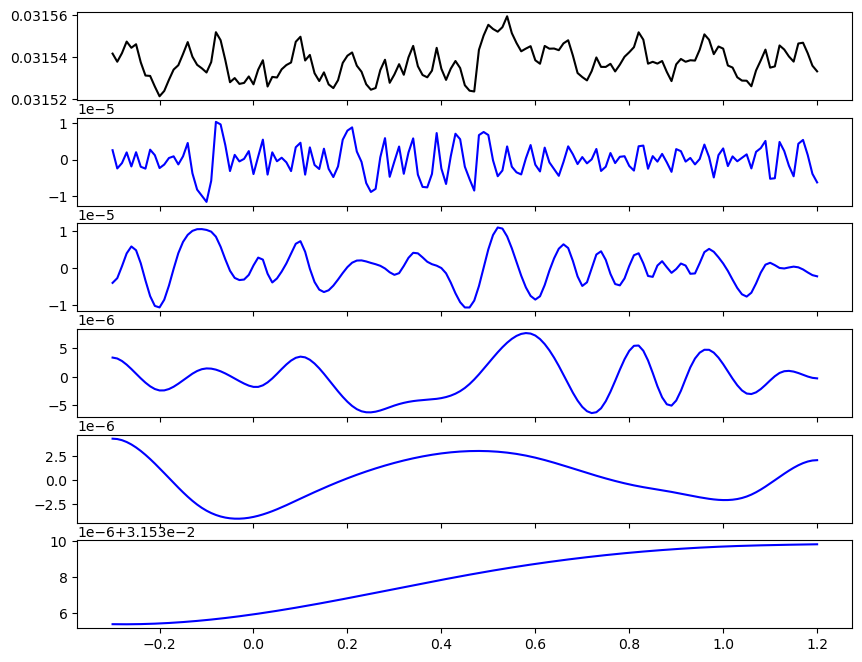

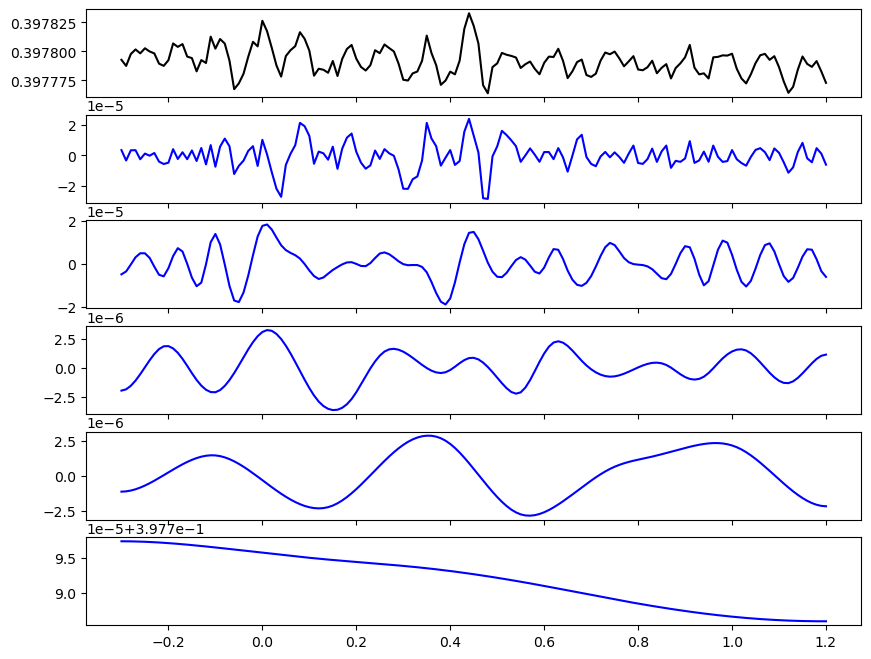

Loading Epochs for S20...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:40: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S20_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:51: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


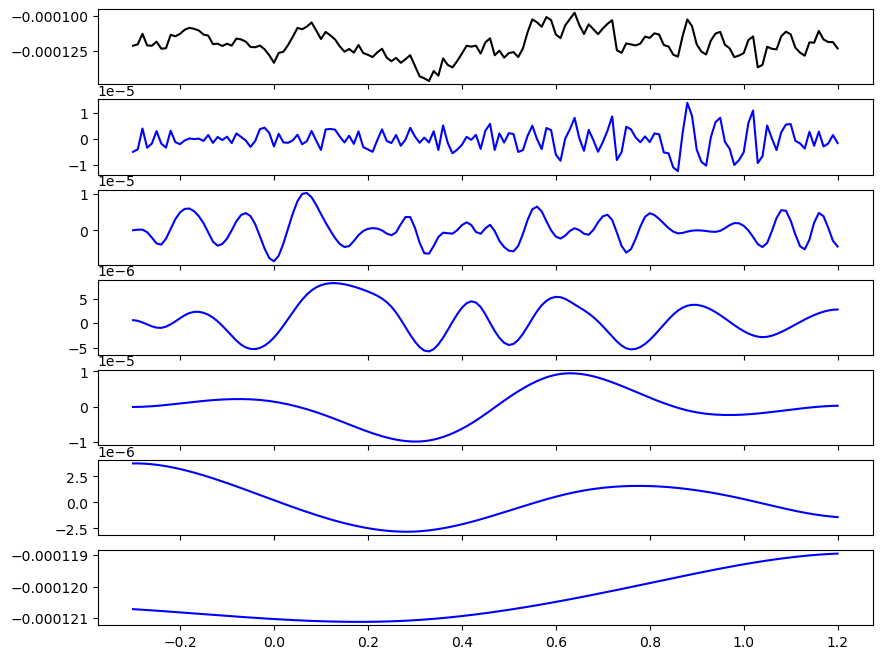

Loading Epochs for S13...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:40: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S13_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:51: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


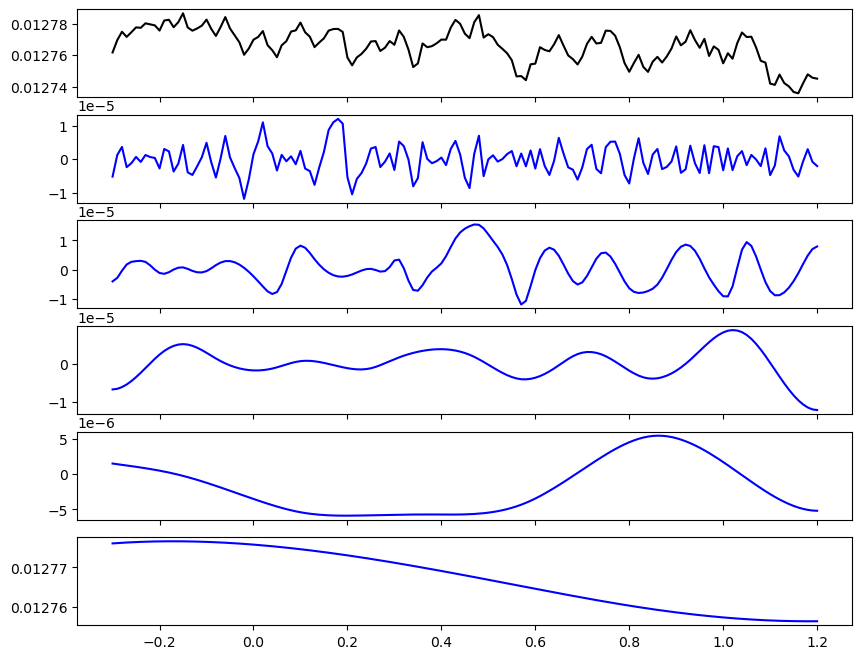

Loading Epochs for S01...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:40: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S01_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:51: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


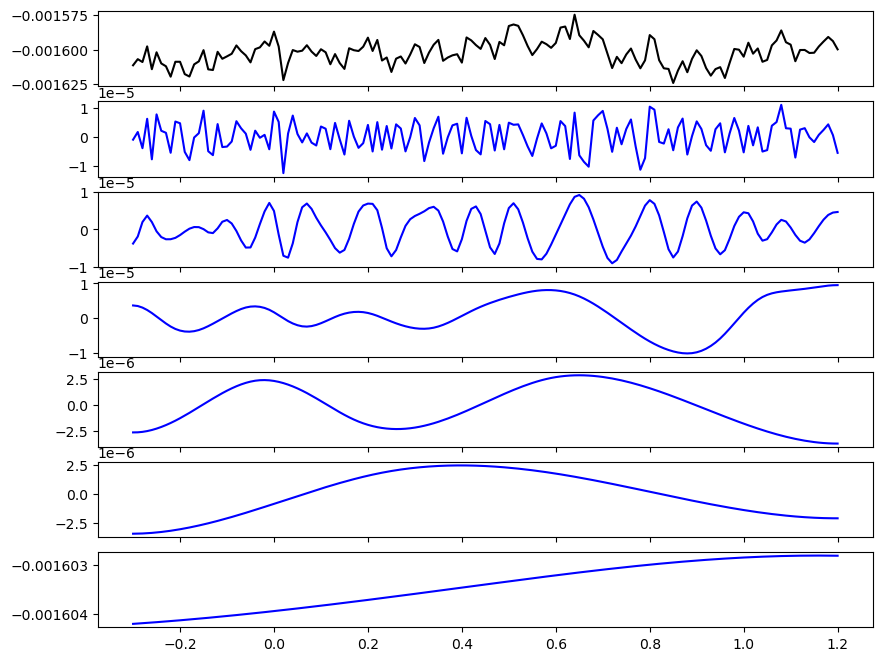

Loading Epochs for S16...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:40: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S16_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:51: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


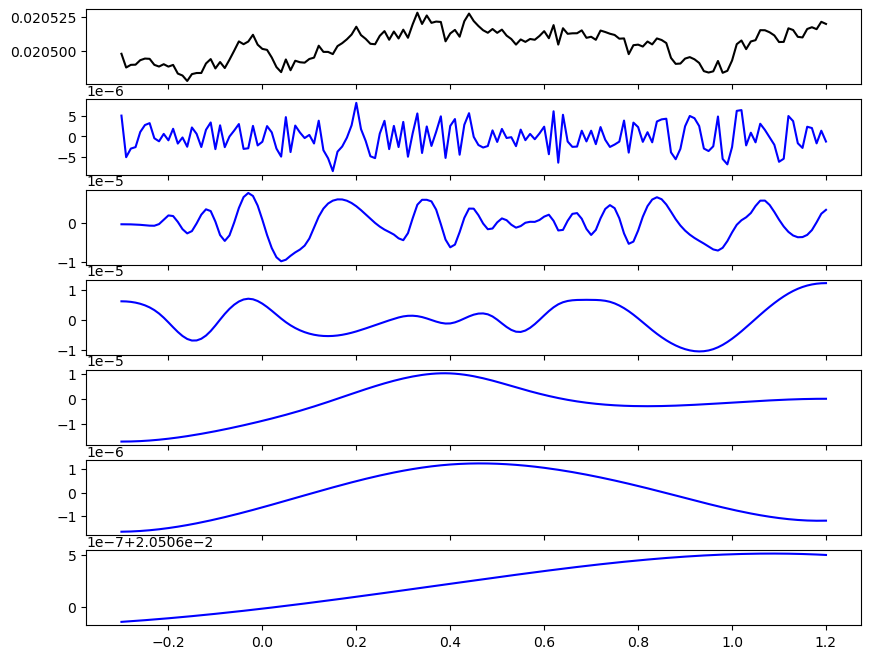

Loading Epochs for S41...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:40: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S41_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:51: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


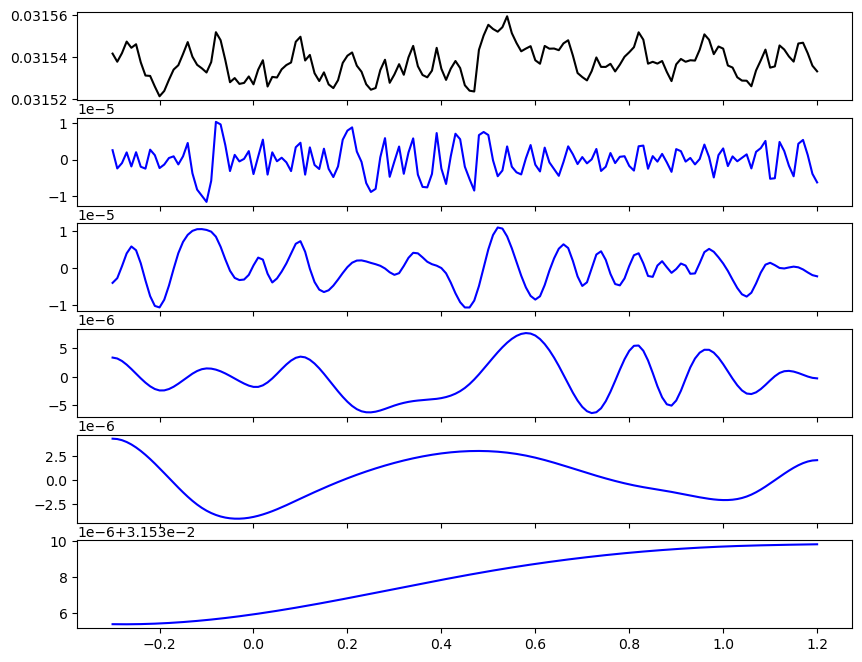

Loading Epochs for S25...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:40: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S25_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:51: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


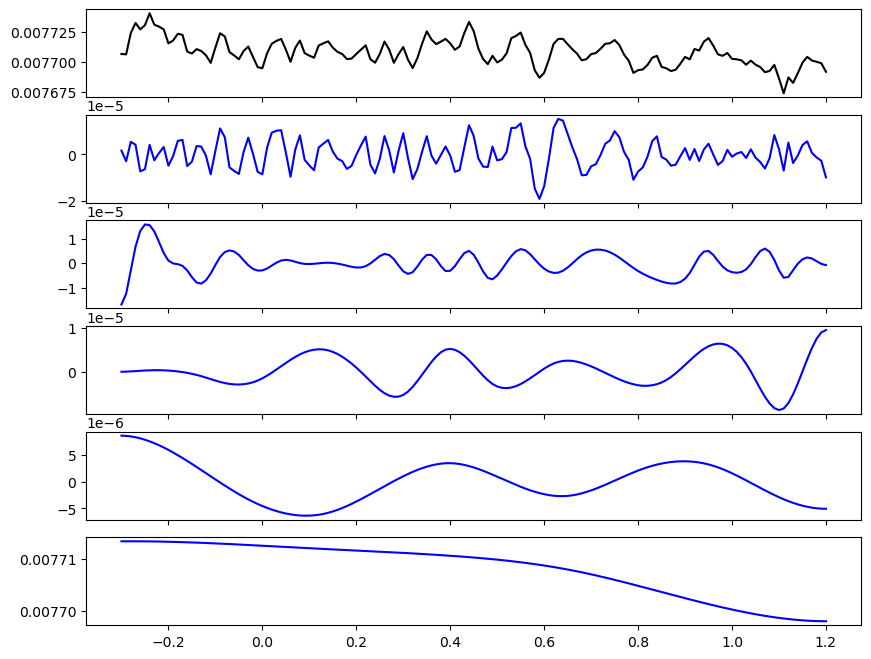

Loading Epochs for S37...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:40: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S37_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:51: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


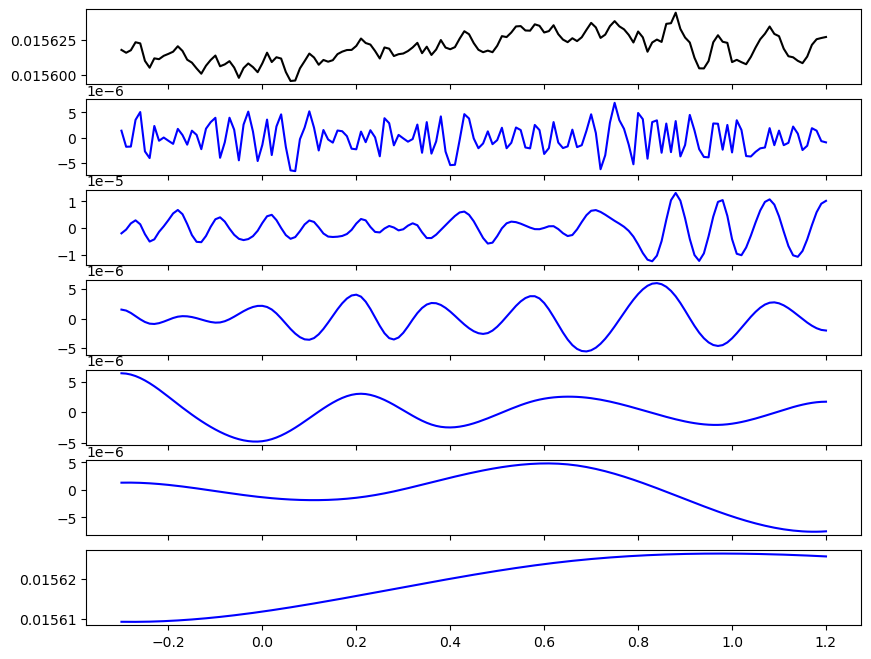

Loading Epochs for S04...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:40: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S04_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:51: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


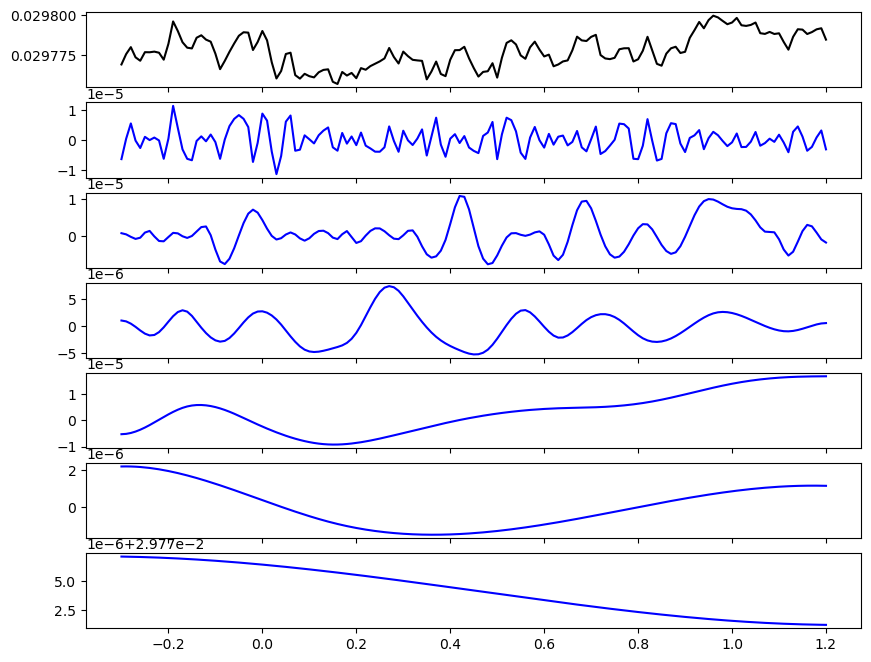

Loading Epochs for S18...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:40: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S18_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:51: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


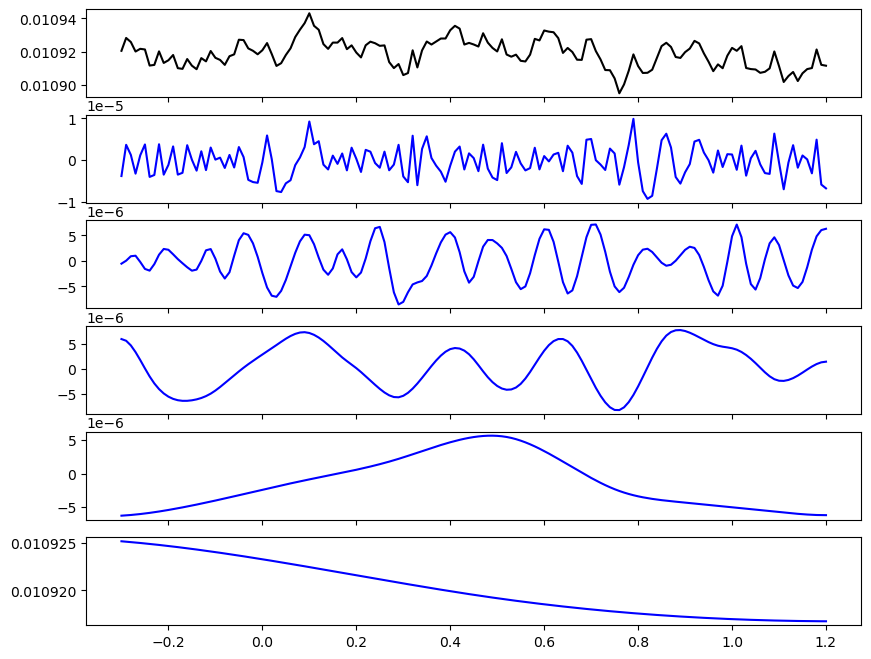

Loading Epochs for S39...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:40: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S39_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:51: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


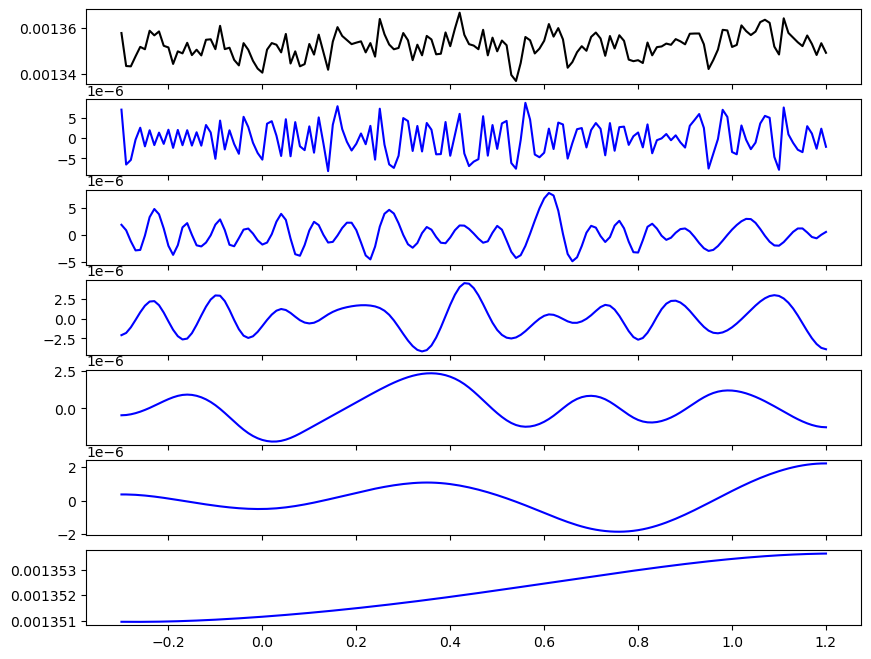

Loading Epochs for S10...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:40: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S10_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:51: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


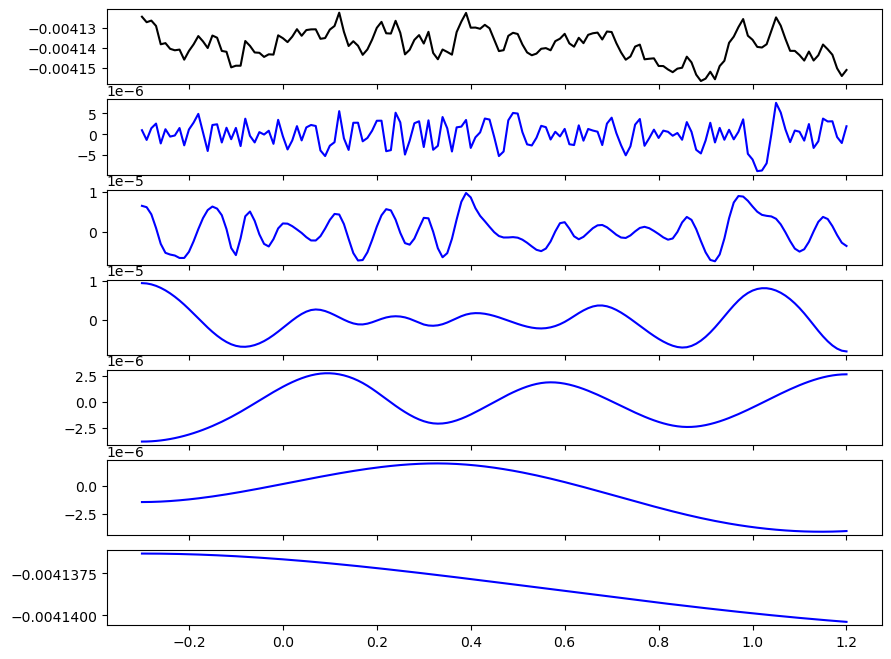

Loading Epochs for S15...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:40: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S15_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:51: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


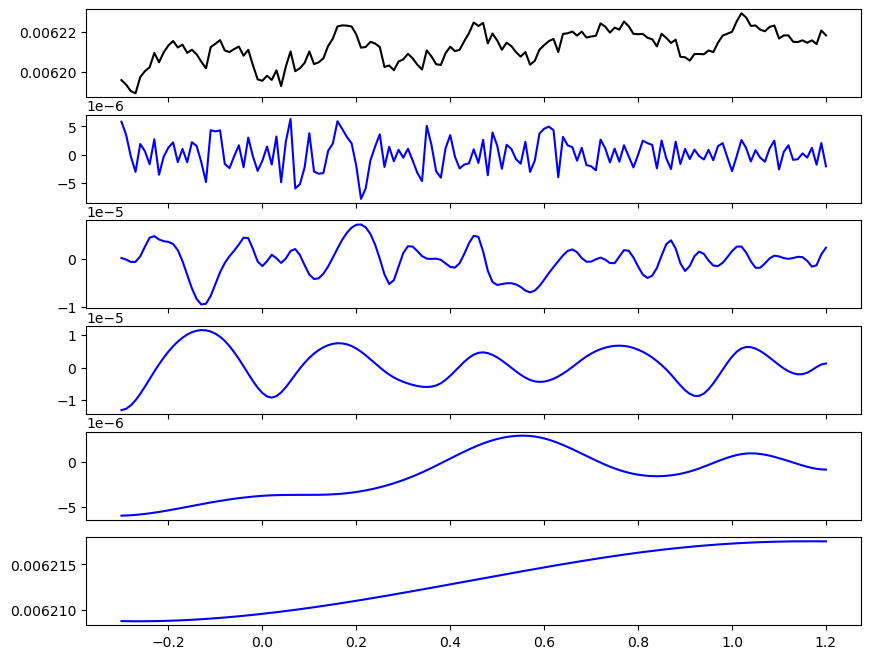

Loading Epochs for S26...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:40: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S26_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:51: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


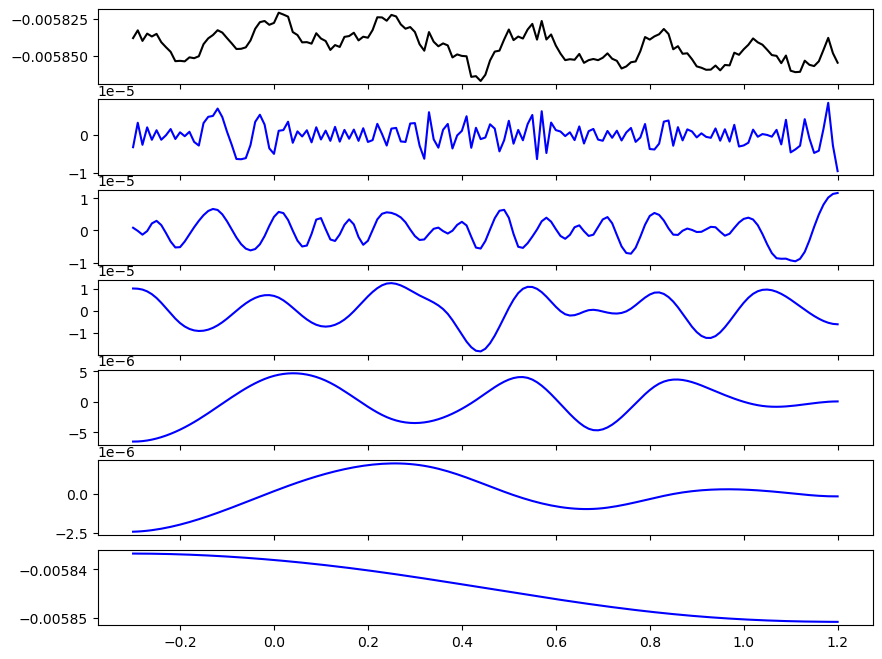

Loading Epochs for S42...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:40: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S42_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:51: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


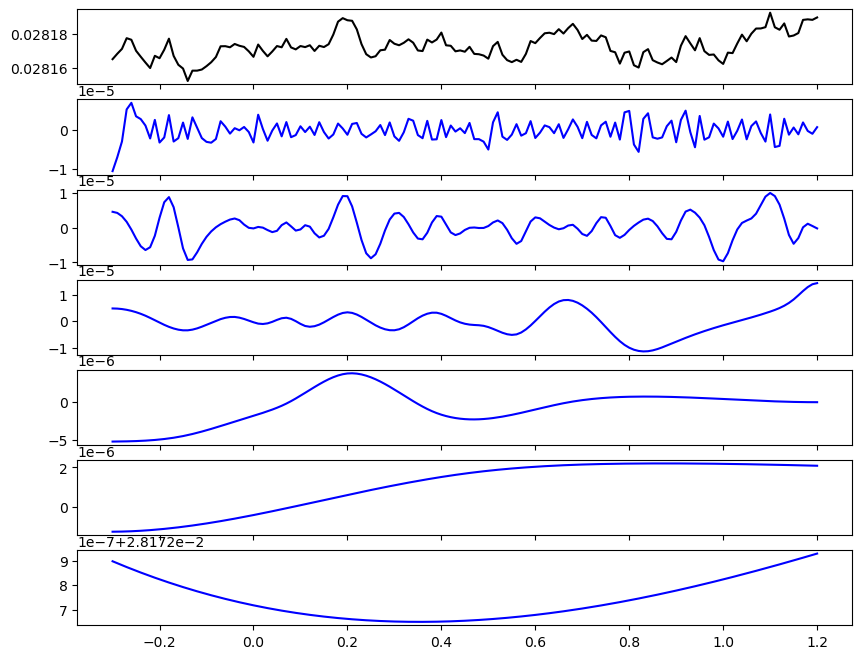

Loading Epochs for S34...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:40: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S34_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:51: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


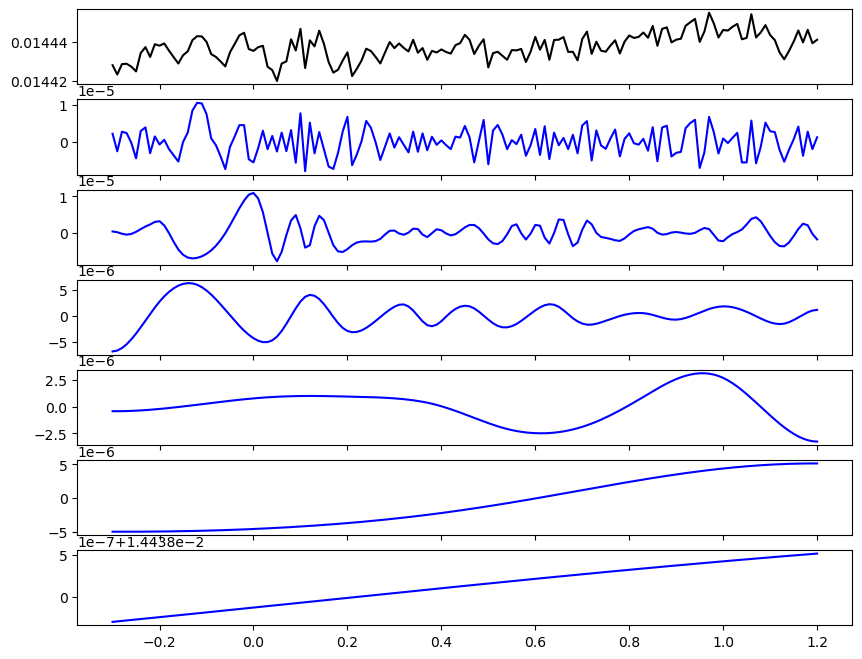

Loading Epochs for S38...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:40: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S38_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:51: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


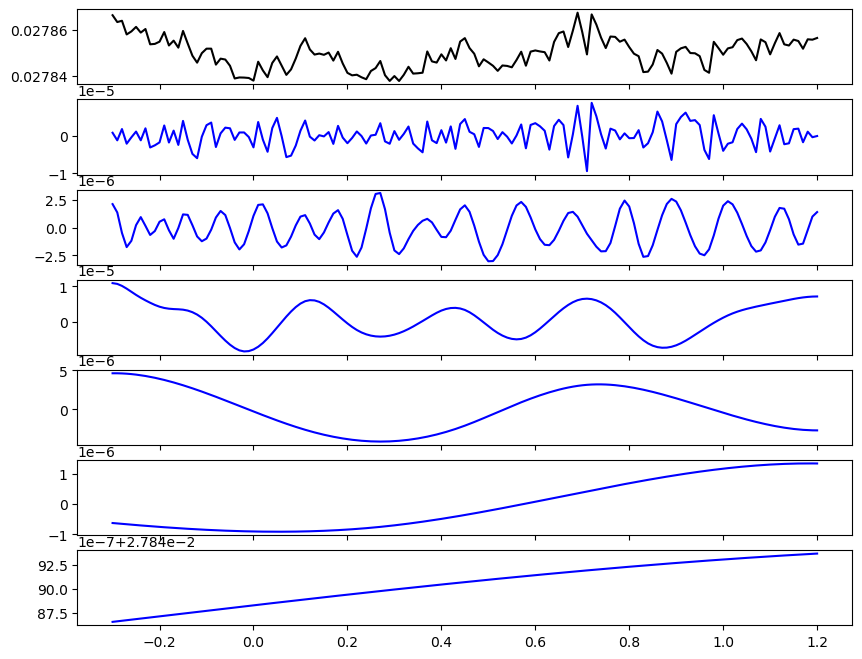

Loading Epochs for S19...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:40: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S19_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:51: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


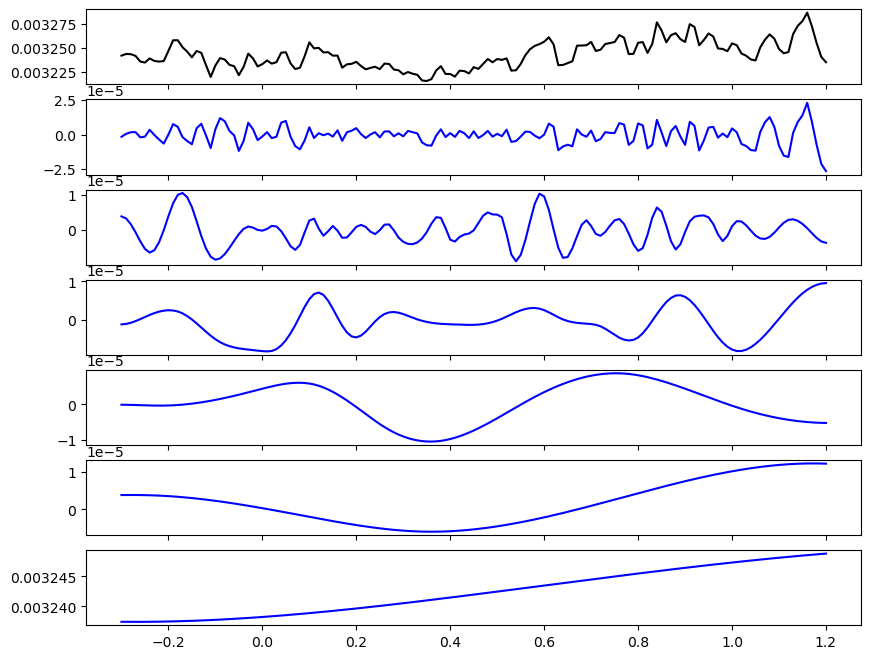

Loading Epochs for S06...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:40: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S06_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:51: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


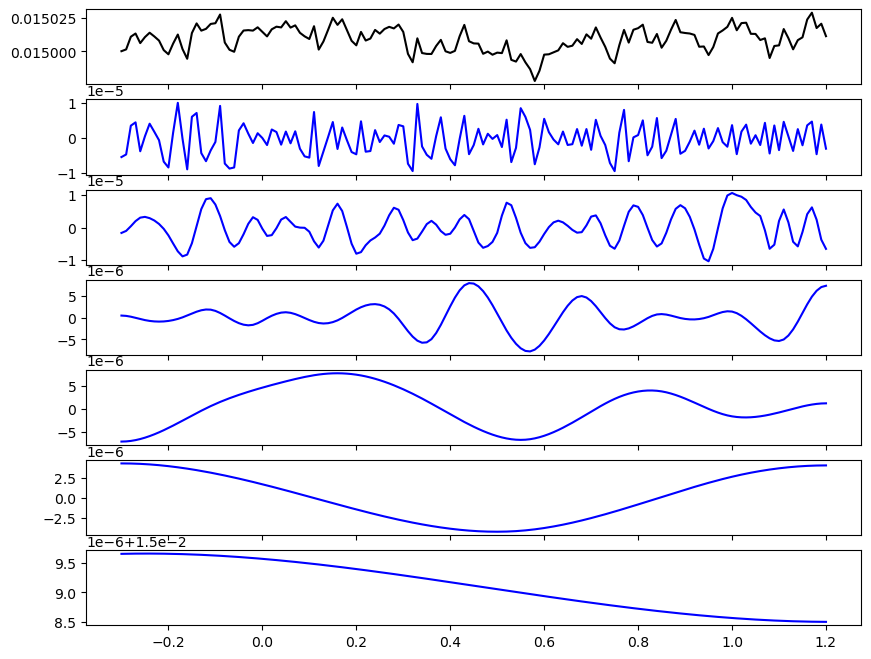

Loading Epochs for S35...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:40: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S35_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:51: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


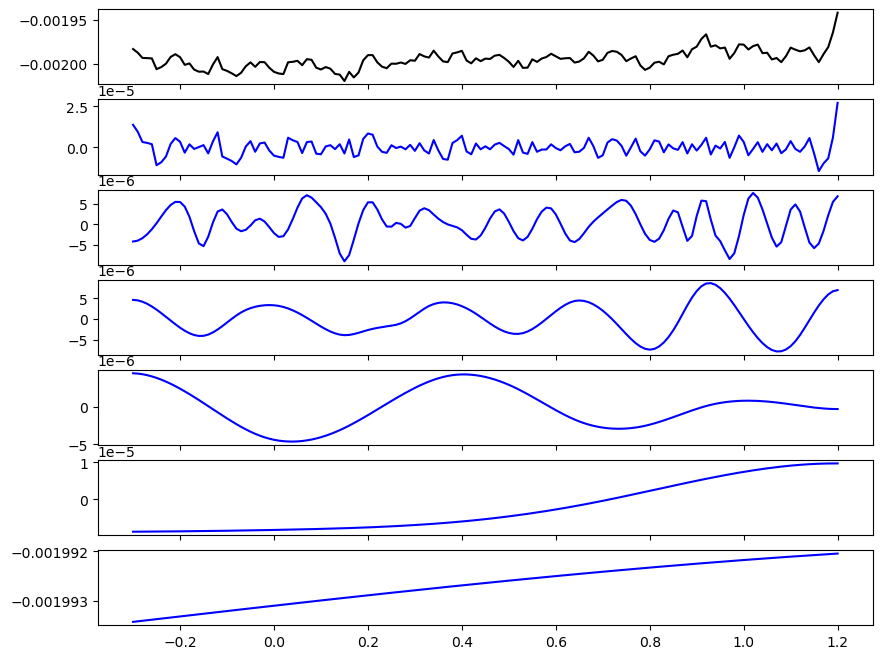

Loading Epochs for S14...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:40: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S14_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:51: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


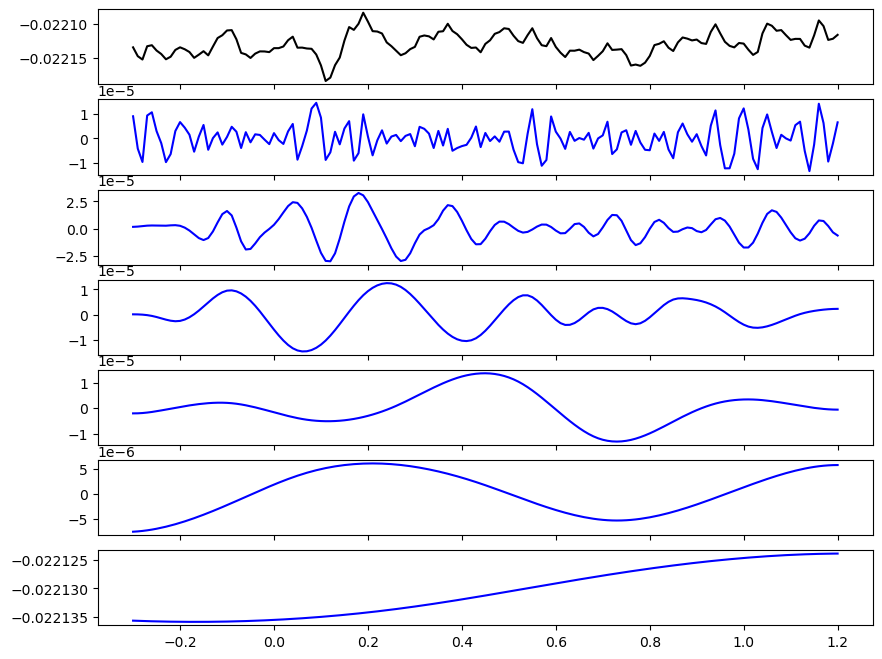

Loading Epochs for S03...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:40: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S03_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:51: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


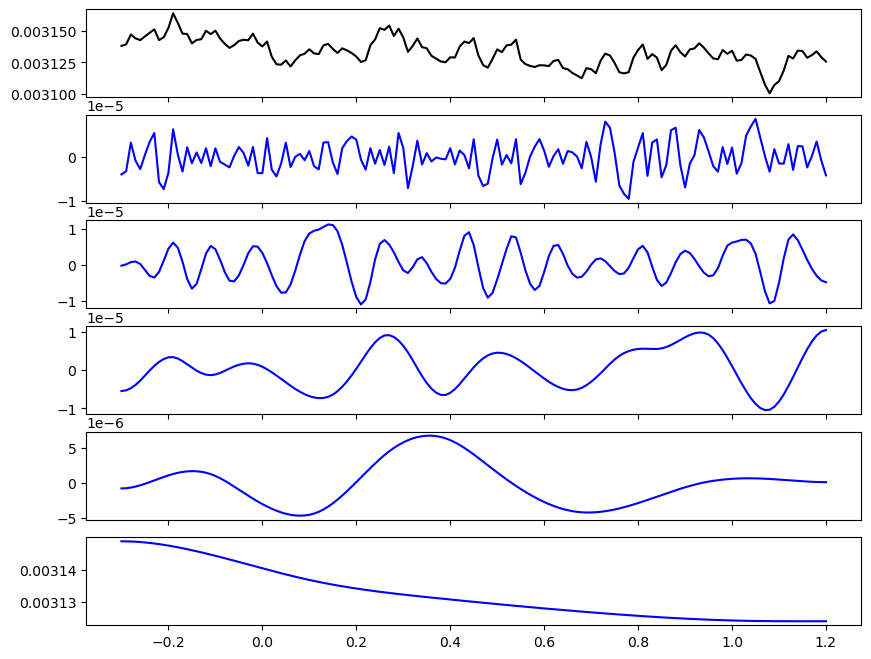

Loading Epochs for S11...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:40: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S11_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:51: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


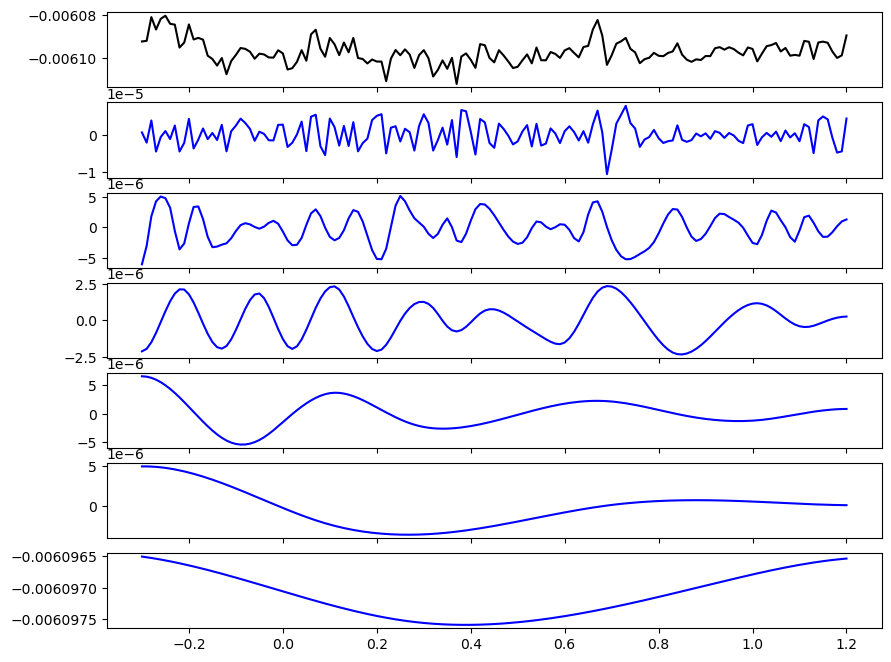

Loading Epochs for S22...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:40: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S22_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:51: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


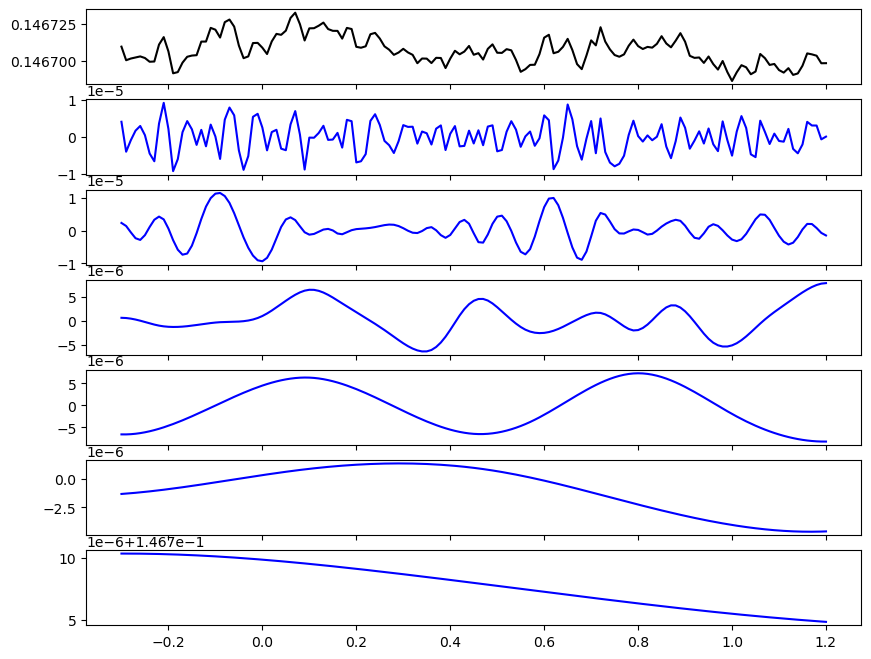

Loading Epochs for S05...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:40: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S05_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:51: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


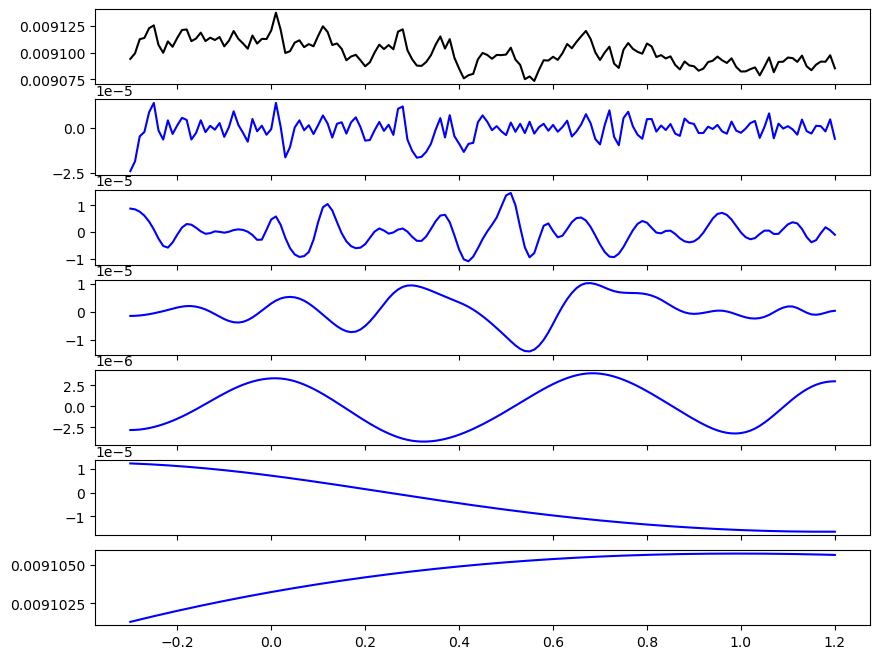

Loading Epochs for S36...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:40: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S36_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:51: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


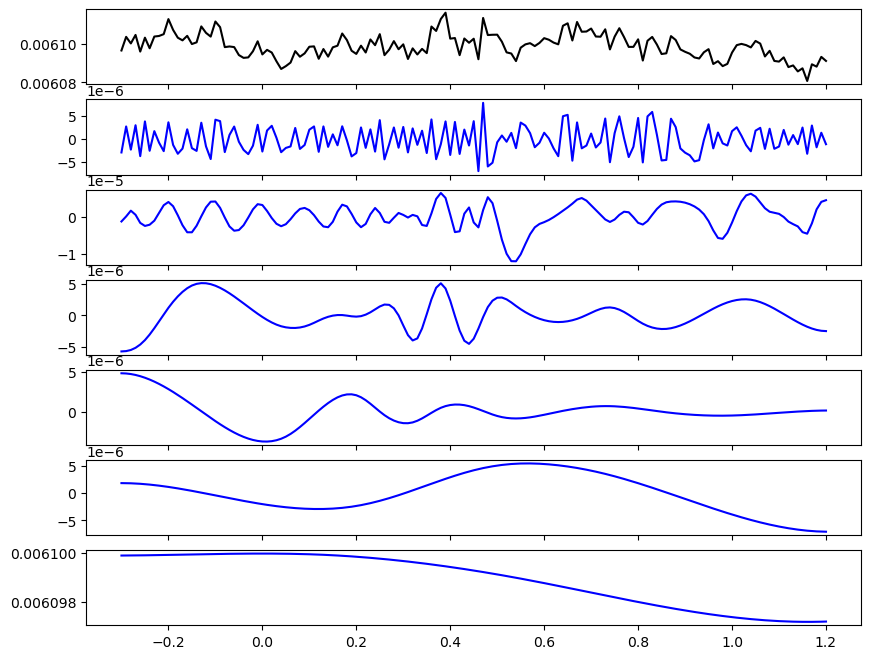

Loading Epochs for S40...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:40: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S40_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:51: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


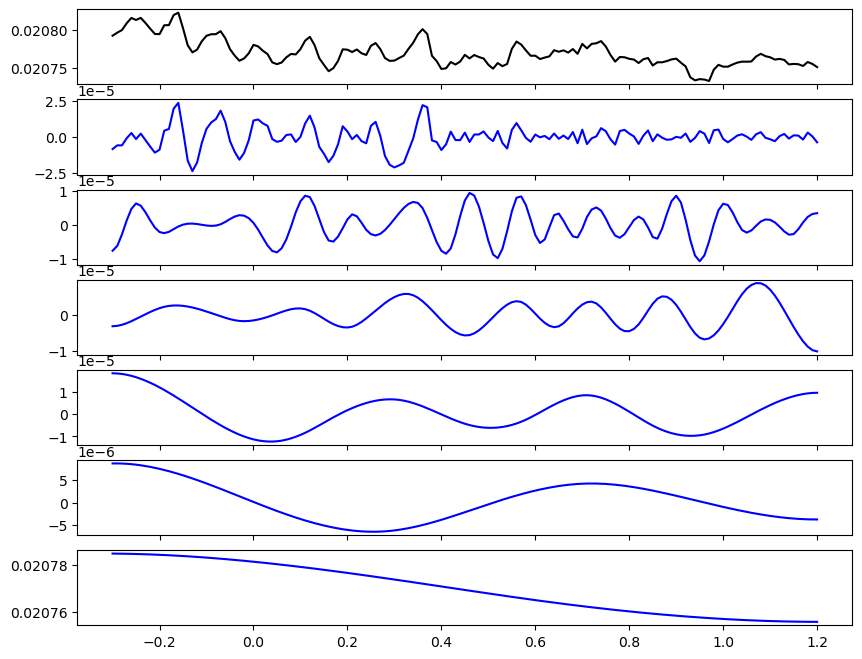

Loading Epochs for S17...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:40: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S17_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:51: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


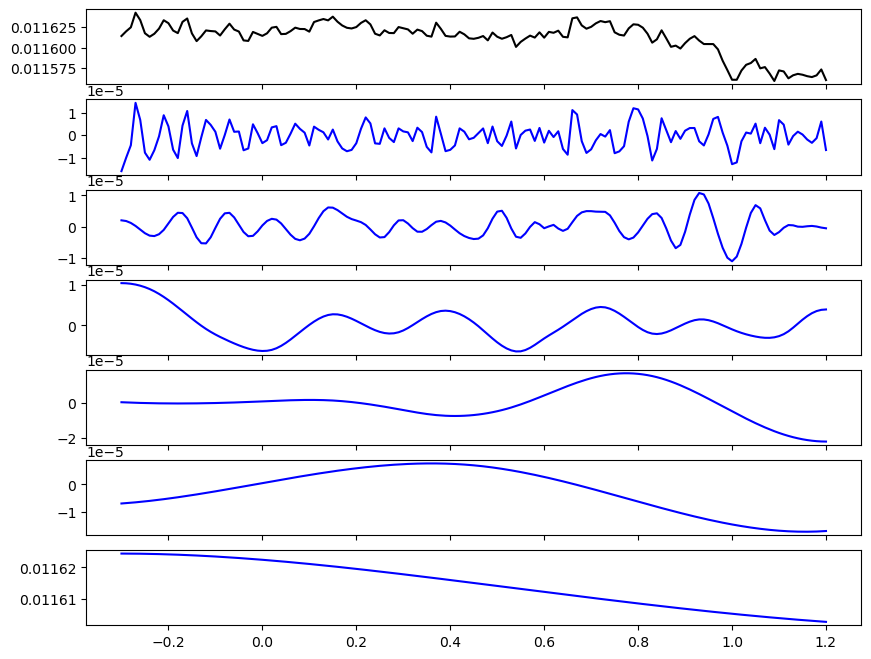

Loading Epochs for S12...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:40: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S12_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:51: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


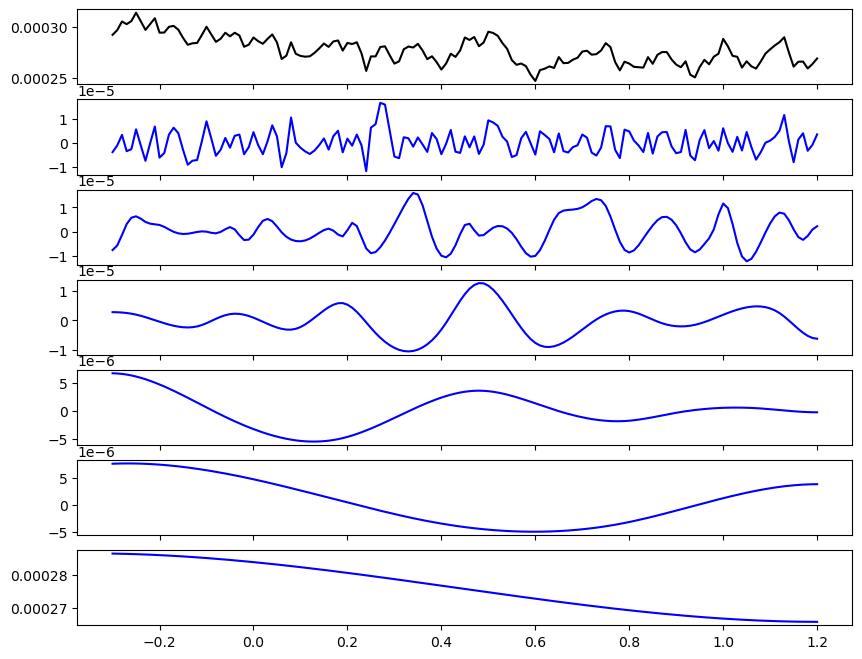

Loading Epochs for S45...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:40: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S45_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:51: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


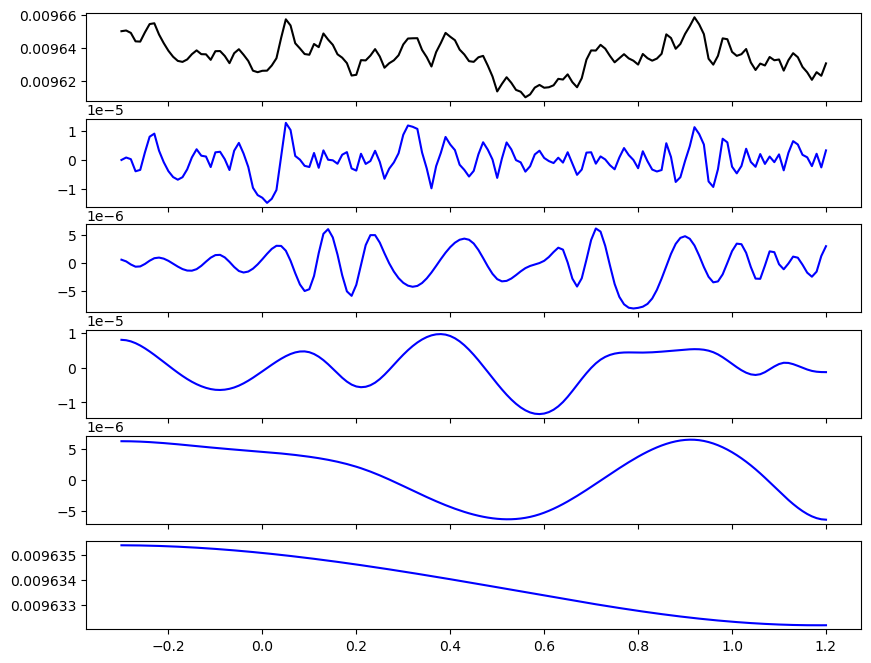

Loading Epochs for S21...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:40: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S21_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:51: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


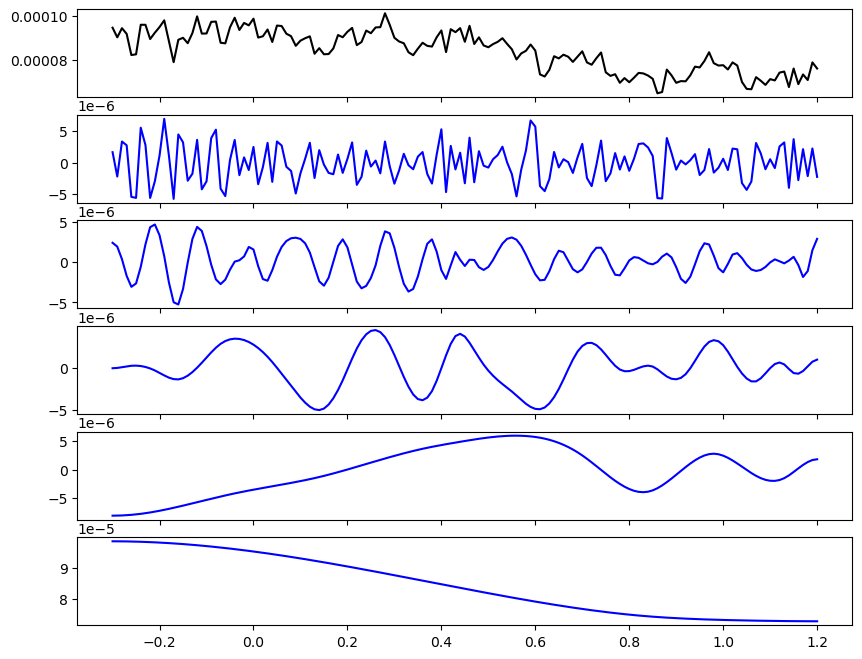

Loading Epochs for S48...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:40: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S48_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:51: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


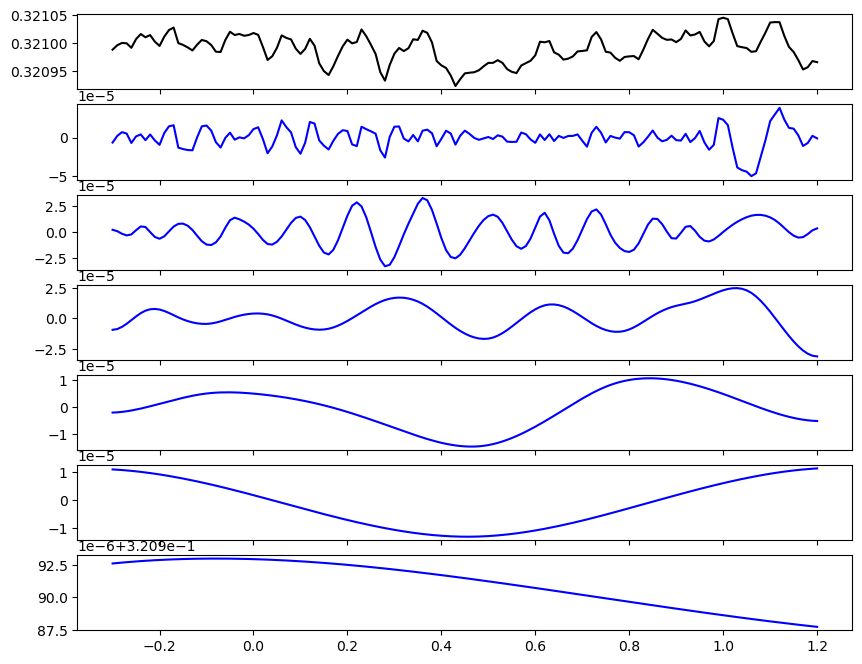

Loading Epochs for S08...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:40: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S08_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/3643312912.py:51: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 151 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


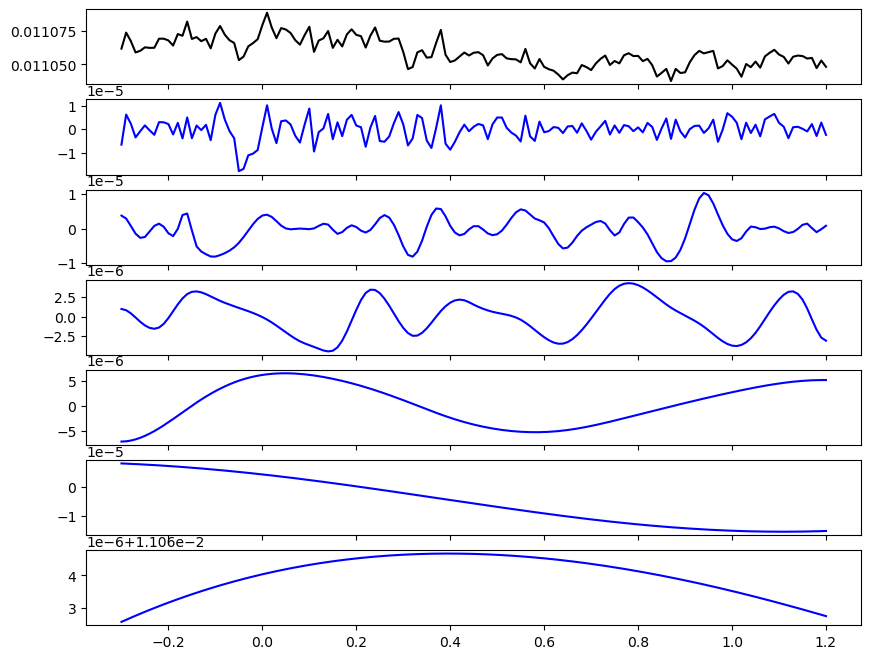

In [58]:
# import numpy as np
# import matplotlib.pyplot as plt
# import mne
# from pathlib import Path
# import emd
# from scipy.signal import hilbert

import gc # Garbage Collector


# (This Work!!)Version 2 of .fif. for each layer
# ==========================================
# 1. CONFIGURATION
# ==========================================
DATA_ROOT = Path("/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results")
EPOCH_DIR = wOnset_DIR #DATA_ROOT / 'wOnset_epochs' 
#TARGET_SUBJECT = 'S11' 

for subject in SUBJECTS: #[0:3]:
    TARGET_SUBJECT = subject[0:3]
    # Selection parameters
    TRIAL_INDEX = 1012      
    CHANNEL_NAME = '1' # Change this to your actual channel name (e.g., 'Cz')
    TARGET_IMF_INDEX = 0 
    
    # ==========================================
    # 2. LOAD DATA (MNE Epochs)
    # ==========================================
    # Fixed filename to match your exact saved file from the warning
    file_name = f'{TARGET_SUBJECT}_Natives_wOnset_epochs_allTapes_raw.fif'
    file_path = EPOCH_DIR / file_name
    
    print(f"Loading Epochs for {TARGET_SUBJECT}...")
    
    # Initialize signal as None to prevent NameError later
    signal = None
    
    try:
        # Use verbose=False to quiet the naming convention warning
        epochs = mne.read_epochs(file_path, preload=True, verbose=False)
        
        # 1. Pick Channel (Check if channel exists first)
        if CHANNEL_NAME not in epochs.ch_names:
            print(f"Warning: {CHANNEL_NAME} not found. Using first available channel: {epochs.ch_names[0]}")
            CHANNEL_NAME = epochs.ch_names[0]
        
        epochs.pick_channels([CHANNEL_NAME])
        
        # 2. Extract Data 
        # MNE shape: (trials, channels, times)
        data = epochs.get_data() 
        
        # Ensure it's a 1D array for EMD
        signal = data[TRIAL_INDEX, 0, :].flatten()
        
        times = epochs.times
        fs = epochs.info['sfreq']
        
        # Clean up epoch object to save RAM
        del epochs
        gc.collect()
    
        print(f"Data Loaded Successfully: {len(signal)} samples")
    
    except Exception as e:
        print(f"FATAL ERROR during loading: {e}")
        # Stop execution if data didn't load
        raise 
    
    # ==========================================
    # 3. PROCESSING (Only runs if signal exists)
    # ==========================================
    
    if signal is not None:
        # --- A. Layer 1 Decomposition ---
        # Mirror Padding to prevent edge effects
        pad_width = len(signal)
        padded_signal = np.pad(signal, pad_width, mode='reflect')
    
        print("Running Layer 1 Sift...")
        # Using sift (standard) or ensemble_sift (CEEMDAN-like)
        # nprocesses helps speed but can crash some kernels; set to 1 if it crashes
        imfs_layer1_padded = emd.sift.sift(padded_signal, max_imfs=5)
    
        # Un-pad
        imfs_layer1 = imfs_layer1_padded[pad_width : pad_width + len(signal), :]
        n_imfs1 = imfs_layer1.shape[1]
    
        # --- B. Layer 2 Decomposition ---
        target_imf_padded = imfs_layer1_padded[:, TARGET_IMF_INDEX]
    
        # Analytic signal for envelope
        analytic = hilbert(target_imf_padded)
        envelope_padded = np.abs(analytic)
    
        print("Running Layer 2 Sift...")
        imfs_layer2_padded = emd.sift.sift(envelope_padded, max_imfs=4)
    
        # Un-pad
        envelope_real = envelope_padded[pad_width : pad_width + len(signal)]
        imfs_layer2 = imfs_layer2_padded[pad_width : pad_width + len(signal), :]
        n_imfs2 = imfs_layer2.shape[1]
    
        # ==========================================
        # 4. PLOTTING
        # ==========================================
        # (Plotting code remains the same as previous)
        fig1, axes1 = plt.subplots(n_imfs1 + 1, 1, figsize=(10, 8), sharex=True)
        axes1[0].plot(times, signal, 'k')
        for i in range(n_imfs1):
            axes1[i+1].plot(times, imfs_layer1[:, i], 'b')
        plt.savefig(wOnset_DIR / Path('Natives_%s_%s_word%s_layer1-IMFs_wOnset.png' %(TARGET_SUBJECT, CHANNEL_NAME, TRIAL_INDEX)))
        plt.show()
    
    else:
        print("Processing skipped because signal was not defined.")

In [26]:
import mne
import scipy.io
import numpy as np
from pathlib import Path

# --- CONFIGURATION ---
DATA_ROOT = Path("/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results")
EPOCH_DIR = wOnset_DIR #DATA_ROOT / 'wOnset_epochs'
MAT_OUTPUT_DIR = wOnset_DIR / 'MAT_Files_for_HHSA'
MAT_OUTPUT_DIR.mkdir(exist_ok=True)

CHANNEL_TO_EXPORT = '1'  # The channel used in your figures

# Get list of all epoch files
epoch_files = list(EPOCH_DIR.glob('*_wOnset_epochs_allTapes_raw.fif'))

for f_path in epoch_files:
    subject_id = f_path.name.split('_')[0]
    print(f"Exporting {subject_id}...")
    
    try:
        # 1. Load Epochs
        epochs = mne.read_epochs(f_path, preload=True, verbose=False)
        
        # 2. Pick Channel
        if CHANNEL_TO_EXPORT in epochs.ch_names:
            epochs.pick_channels([CHANNEL_NAME])
        else:
            print(f"  Warning: {CHANNEL_TO_EXPORT} not found in {subject_id}. Skipping.")
            continue
            
        # 3. Extract Data: MNE is (Trials, Channels, Time)
        # We need (Time, Trials) for your MATLAB script
        data = epochs.get_data() # Shape: (n_trials, 1, n_times)
        mat_data = np.squeeze(data).T # Shape: (n_times, n_trials)
        
        # 4. Save to .mat
        save_dict = {
            'D_a': mat_data,
            'fs': epochs.info['sfreq'],
            'times': epochs.times,
            'subject_id': subject_id
        }
        
        scipy.io.savemat(MAT_OUTPUT_DIR / f"{subject_id}_Natives_HHSA_input.mat", save_dict)
        
    except Exception as e:
        print(f"  Failed to export {subject_id}: {e}")

print(f"Export complete. Files saved to: {MAT_OUTPUT_DIR}")

Exporting S25...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S25_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S36_Natives_wOnset_epochs_allTape

Exporting S36...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S03_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)


Exporting S03...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S10_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)


Exporting S10...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S13_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)


Exporting S13...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S26_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)


Exporting S26...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S35_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)


Exporting S35...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S15_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)


Exporting S15...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S06_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)


Exporting S06...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S20_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)


Exporting S20...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S16_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)


Exporting S16...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S05_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)


Exporting S05...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S45_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)


Exporting S45...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S19_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)


Exporting S19...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S40_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)


Exporting S40...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S39_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)


Exporting S39...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S38_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)


Exporting S38...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S42_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)


Exporting S42...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S41_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)


Exporting S41...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S08_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)


Exporting S08...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S44_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)


Exporting S44...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S18_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)


Exporting S18...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S22_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)


Exporting S22...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S04_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)


Exporting S04...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S17_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)


Exporting S17...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S14_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)


Exporting S14...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S21_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)


Exporting S21...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S48_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)


Exporting S48...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S12_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)


Exporting S12...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S01_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)


Exporting S01...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S34_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)


Exporting S34...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S37_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)


Exporting S37...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S11_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)


Exporting S11...
Export complete. Files saved to: /Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/MAT_Files_for_HHSA


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/2737735785.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)


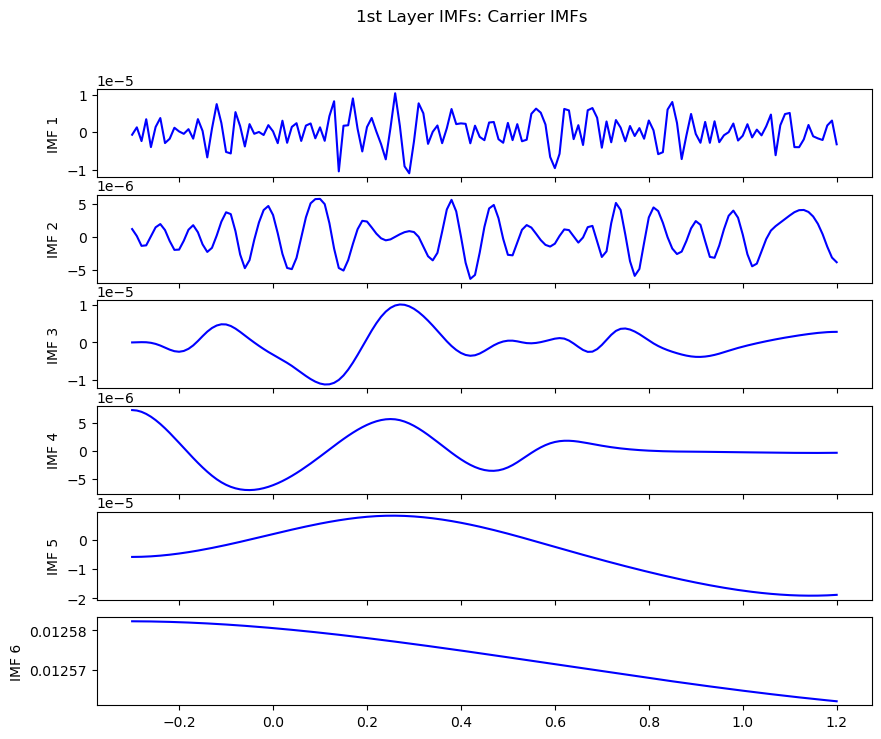

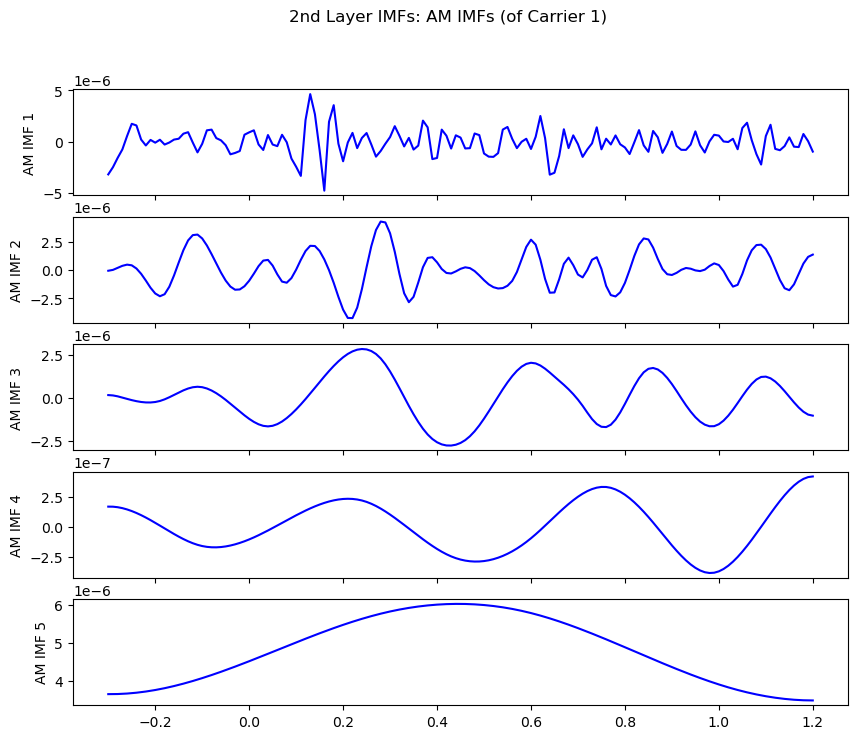

In [46]:
# import numpy as np
# import mne
# import emd
# from scipy.signal import hilbert
# import matplotlib.pyplot as plt

## This works!! For showing 1st & 2nd IMFs

# --- 1. Signal Preparation ---
# signal shape should be (151,)
# fs is your sampling rate (e.g., 100)

# Mirror Padding to prevent edge artifacts on short 151-sample epochs
pad_width = len(signal) 
padded_signal = np.pad(signal, pad_width, mode='reflect')

# --- 2. Layer 1: Carrier Decomposition ---
# This breaks the brain signal into frequency bands (e.g., Theta, Delta)
imfs_l1_padded = emd.sift.sift(padded_signal, max_imfs=5)

# Un-pad to get the real data back
imfs_layer1 = imfs_l1_padded[pad_width : pad_width + len(signal), :]

# --- 3. Layer 2: AM Decomposition ---
# Choose which Carrier IMF to look 'inside' of (e.g., Index 1 for Delta/Word level)
TARGET_IMF_IDX = 0 
target_imf_padded = imfs_l1_padded[:, TARGET_IMF_IDX]

# Extract the Amplitude Envelope using Hilbert Transform
envelope_padded = np.abs(hilbert(target_imf_padded))

# Sift the Envelope again (Second EMD)
imfs_l2_padded = emd.sift.sift(envelope_padded, max_imfs=4)

# Un-pad Layer 2 results
imfs_layer2 = imfs_l2_padded[pad_width : pad_width + len(signal), :]
envelope_real = envelope_padded[pad_width : pad_width + len(signal)]

# --- 4. Visualization ---
def plot_layers(data, times, title, ylabel_prefix):
    n_imfs = data.shape[1]
    fig, axes = plt.subplots(n_imfs, 1, figsize=(10, 8), sharex=True)
    for i in range(n_imfs):
        axes[i].plot(times, data[:, i], color='blue')
        axes[i].set_ylabel(f"{ylabel_prefix} {i+1}")
    plt.suptitle(title)
    plt.savefig(wOnset_DIR / Path('Natives_%s_%s_word%s_2LayerIMFs_IMF%s_wOnset.png' %(TARGET_SUBJECT, CHANNEL_NAME, TRIAL_INDEX, TARGET_IMF_IDX+1)))
    plt.show()

# Plot Layer 1 (Carriers)
plot_layers(imfs_layer1, times, "1st Layer IMFs: Carrier IMFs", "IMF")

# Plot Layer 2 (Modulations of the selected Carrier)
plot_layers(imfs_layer2, times, f"2nd Layer IMFs: AM IMFs (of Carrier {TARGET_IMF_IDX+1})", "AM IMF")

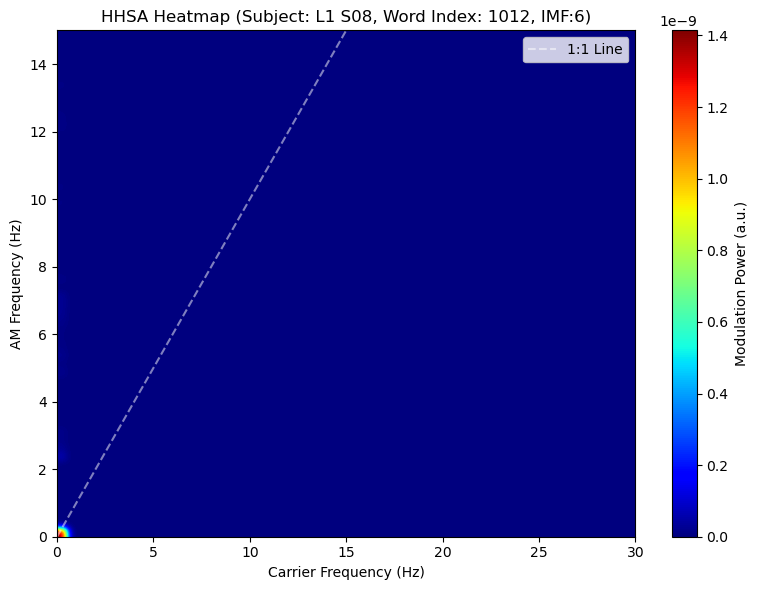

In [56]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.signal import hilbert

# This works !! for HHSA Heatmap

# --- 1. SETTINGS ---
NBINS = 60
LIMIT_CARRIER = 30 # 12 # X-axis limit (Hz)
LIMIT_AM = 15 # 6       # Y-axis limit (Hz)
TRIAL_INDEX = 1012
TARGET_IMF_IDX = 5

# --- 2. CALCULATE INSTANTANEOUS FREQUENCY ---
def get_inst_info(sig, sr):
    analytic = hilbert(sig)
    phase = np.unwrap(np.angle(analytic))
    # Frequency is the derivative of the phase
    freq = np.append(np.diff(phase) / (2.0 * np.pi) * sr, 0)
    return freq

# Extract Carrier Frequency (from the Layer 1 IMF you selected)
# Use the un-padded imfs_layer1 from your previous code
freq_carrier = get_inst_info(imfs_layer1[:, TARGET_IMF_IDX], fs)

# --- 3. ACCUMULATE HOLO-DATA POINTS ---
holo_points = []

# Loop through all AM IMFs from Layer 2
for j in range(imfs_layer2.shape[1]):
    # Get AM Frequency for this component
    freq_am = get_inst_info(imfs_layer2[:, j], fs)
    
    # Calculate Power (Energy) of this AM component
    power_am = imfs_layer2[:, j]**2
    
    # Filter for valid ranges (Positive frequencies below limits)
    mask = (freq_carrier > 0) & (freq_carrier < LIMIT_CARRIER) & \
           (freq_am > 0) & (freq_am < LIMIT_AM)
    
    if np.any(mask):
        # Stack: [Carrier_Freq, AM_Freq, Power]
        pts = np.vstack((freq_carrier[mask], freq_am[mask], power_am[mask])).T
        holo_points.append(pts)

# Combine all points into one matrix
holo_data = np.vstack(holo_points)

# --- 4. CREATE THE HEATMAP ---
# Weighted 2D histogram
H, x_edges, y_edges = np.histogram2d(
    holo_data[:, 0], holo_data[:, 1], 
    bins=NBINS, 
    weights=holo_data[:, 2], 
    range=[[0, LIMIT_CARRIER], [0, LIMIT_AM]]
)

# --- 5. PLOT ---
plt.figure(figsize=(8, 6))
# We use .T because imshow expects [y, x] but histogram2d returns [x, y]
plt.imshow(H.T, origin='lower', cmap='jet', aspect='auto', interpolation='gaussian',
           extent=[0, LIMIT_CARRIER, 0, LIMIT_AM])

plt.colorbar(label='Modulation Power (a.u.)')
plt.xlabel('Carrier Frequency (Hz)')
plt.ylabel('AM Frequency (Hz)')
plt.title(f'HHSA Heatmap (Subject: L1 {TARGET_SUBJECT}, Word Index: {TRIAL_INDEX}, IMF:{TARGET_IMF_IDX+1})')

# Add the 1:1 diagonal line (AM frequency cannot exceed Carrier frequency)
plt.plot([0, LIMIT_AM], [0, LIMIT_AM], 'w--', alpha=0.5, label='1:1 Line')
plt.legend()
plt.tight_layout()
plt.savefig(wOnset_DIR / Path('Nativess_%s_%s_HHSA_%s_word%s_wOnset.png' %(TARGET_SUBJECT, CHANNEL_NAME, TARGET_IMF_IDX, TRIAL_INDEX)))
plt.show()

In [37]:
# import numpy as np
# import mne
# import emd
# from scipy.signal import hilbert
# import gc
# from pathlib import Path

# This Works !! For group Average of tape 1

# --- A. DEFINE THE ANALYSIS PIPELINE ---
def run_hhsa_pipeline(signal, fs):
    """Performs Two-Layer EMD with Padding and IF calculation."""
    # 1. Padding
    pad_width = len(signal)
    padded_signal = np.pad(signal, pad_width, mode='reflect')

    # 2. Layer 1 Sift (Carrier)
    try:
        imfs_l1_padded = emd.sift.sift(padded_signal, max_imfs=5).T
        # We target IMF 2 (Index 1) as the carrier
        target_imf_padded = imfs_l1_padded[1]
    except:
        return None

    # 3. Layer 2 Sift (AM)
    analytic_c = hilbert(target_imf_padded)
    envelope_padded = np.abs(analytic_c)
    
    try:
        imfs_l2_padded = emd.sift.sift(envelope_padded, max_imfs=4).T
    except:
        return None

    # 4. Extract Real parts and Calculate Frequencies
    # Carrier IF
    imf_c_real = target_imf_padded[pad_width : pad_width + len(signal)]
    phase_c = np.unwrap(np.angle(hilbert(imf_c_real)))
    freq_c = np.append(np.diff(phase_c) / (2.0 * np.pi) * fs, 0)

    all_points = []
    for j in range(imfs_l2_padded.shape[0]):
        # AM IF
        imf_am_real = imfs_l2_padded[j, pad_width : pad_width + len(signal)]
        phase_am = np.unwrap(np.angle(hilbert(imf_am_real)))
        freq_am = np.append(np.diff(phase_am) / (2.0 * np.pi) * fs, 0)
        power_am = imf_am_real**2
        
        # Combine [fc, fam, power]
        pts = np.vstack((freq_c, freq_am, power_am)).T
        all_points.append(pts)

    return np.vstack(all_points)

# --- B. PROCESS ALL SUBJECTS ---
GROUP_NAME = "Natives" # Change to "ESLs" in your second notebook
NBINS = 60
LIMIT_CARRIER, LIMIT_AM = 30, 15
subject_heatmaps = []

for subject in SUBJECTS:
    print(f"Subject: {subject[:3]}")
    file_path = wOnset_DIR / f'{subject[:3]}_Natives_wOnset_epochs_allTapes_raw.fif'
    
    try:
        epochs = mne.read_epochs(file_path, preload=True, verbose=False)
        # Select Tape 1 (first 171 words)
        tape1_data = epochs[0:171].get_data() 
        # Average across trials to get the evoked signal (151 samples)
        avg_signal = tape1_data.mean(axis=0)[0, :]
        fs = epochs.info['sfreq']

        holo_data = run_hhsa_pipeline(avg_signal, fs)
        
        if holo_data is not None:
            H, _, _ = np.histogram2d(holo_data[:, 0], holo_data[:, 1], bins=NBINS, 
                                     weights=holo_data[:, 2], 
                                     range=[[0, LIMIT_CARRIER], [0, LIMIT_AM]])
            subject_heatmaps.append(H)
        
        del epochs, tape1_data
        gc.collect()
    except Exception as e:
        print(f"  Error on {subject}: {e}")

# Save the final matrix
np.save(wOnset_DIR /f"{GROUP_NAME}_tape1_heatmaps.npy", np.array(subject_heatmaps))

Subject: S44


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:63: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S44_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:63: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S20_Natives_wOnset_epochs_allTapes_raw.fif) does 

Subject: S20


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:63: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S13_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


Subject: S13


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()


Subject: S01


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:63: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S01_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()


Subject: S16


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:63: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S16_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()


Subject: S41


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:63: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S41_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()


Subject: S25


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:63: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S25_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:63: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S37_Natives_wOnset_epochs_allTapes_raw.fif) does 

Subject: S37


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()


Subject: S04


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:63: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S04_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:63: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S18_Natives_wOnset_epochs_allTapes_raw.fif) does 

Subject: S18


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:63: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S39_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


Subject: S39


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:63: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S10_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


Subject: S10


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:63: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S15_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


Subject: S15


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:63: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S26_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


Subject: S26


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:63: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S42_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


Subject: S42


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()


Subject: S34


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:63: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S34_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:63: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S38_Natives_wOnset_epochs_allTapes_raw.fif) does 

Subject: S38


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:63: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S19_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


Subject: S19


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:63: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S06_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


Subject: S06


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()


Subject: S35


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:63: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S35_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:63: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S14_Natives_wOnset_epochs_allTapes_raw.fif) does 

Subject: S14


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()


Subject: S03


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:63: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S03_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()


Subject: S11


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:63: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S11_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:63: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S22_Natives_wOnset_epochs_allTapes_raw.fif) does 

Subject: S22


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:63: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S05_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


Subject: S05


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:63: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S36_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


Subject: S36


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()


Subject: S40


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:63: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S40_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()


Subject: S17


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:63: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S17_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()


Subject: S12


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:63: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S12_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()


Subject: S45


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:63: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S45_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:63: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S21_Natives_wOnset_epochs_allTapes_raw.fif) does 

Subject: S21


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:63: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S48_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


Subject: S48


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:63: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_Natives/Alice_Natives_wOnset_raw_epochs/S08_Natives_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


Subject: S08


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40913/1694201825.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()


import numpy as np
import matplotlib.pyplot as plt
from mne.stats import spatio_temporal_cluster_test

## For permutation test of both groups

# 1. Load saved data
natives = np.load("Natives_tape1_heatmaps.npy") # (33, 60, 60)
esls = np.load("ESLs_tape1_heatmaps.npy")       # (26, 60, 60)

# 2. Format for MNE: [group1_array, group2_array]
X = [natives, esls]

# 3. Run Permutation Test
# threshold: T-value where clusters start forming (2.0 is roughly p < 0.05)
t_obs, clusters, cluster_pv, H0 = spatio_temporal_cluster_test(
    X, 
    threshold=2.0, 
    n_permutations=1000, 
    tail=0, # Two-tailed
    n_jobs=-1
)

# 4. Plot Results
plt.figure(figsize=(10, 8))
# T-obs is (60, 60), we transpose for [Carrier, AM] plotting
plt.imshow(t_obs.T, origin='lower', extent=[0, 12, 0, 6], cmap='RdBu_r')
plt.colorbar(label='T-statistic')

# Overlay Significant Clusters (p < 0.05)
for i, p_val in enumerate(cluster_pv):
    if p_val < 0.05:
        # Create a boolean mask for the significant cluster
        mask = clusters[i].astype(float)
        plt.contour(mask.T, colors='black', levels=[0.5], extent=[0, 12, 0, 6])
        print(f"Significant Cluster found! p-value: {p_val:.4f}")

plt.xlabel('Carrier Frequency (Hz)')
plt.ylabel('AM Frequency (Hz)')
plt.title('Permutation Test: Natives vs ESLs (Tape 1)')
plt.show()

"""
import numpy as np
import matplotlib.pyplot as plt
import eelbrain
from pathlib import Path
import emd
from scipy.signal import hilbert
"""
# Version 1 of IMFs in each layers (=second EMD)

# ==========================================
# 1. CONFIGURATION
# ==========================================
DATA_ROOT = Path("/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results")
TRF_DIR = DATA_ROOT / 'TRFs_ESLs'
TARGET_MODEL = 'Fzero+envelope'
TARGET_SUBJECT = 'S010'  # <--- Change this to look at different subjects

# Which Layer 1 IMF do you want to decompose further?
# 0 = First IMF (Fastest/Highest Freq), 1 = Second IMF, etc.
TARGET_IMF_INDEX = 1 

# ==========================================
# 2. LOAD DATA (Robust Loading)
# ==========================================
file_path = TRF_DIR / TARGET_SUBJECT / f'{TARGET_SUBJECT} {TARGET_MODEL}.pickle'
print(f"Loading {TARGET_SUBJECT}...")

try:
    trf_obj = eelbrain.load.unpickle(file_path)
    
    # Handle h vs h_scaled
    if hasattr(trf_obj, 'h_scaled'):
        data_ndvar = trf_obj.h_scaled
    else:
        data_ndvar = trf_obj.h
        
    # Handle Tuple
    if isinstance(data_ndvar, tuple):
        data_ndvar = data_ndvar[0]

    # Extract Predictor (Strategy: Index)
    # Assumes order is [F0, Envelope] -> Index 1 is Envelope
    # If your model is just 'envelope', it might be Index 0.
    try:
        # Try finding 'envelope' by name
        trf_final = data_ndvar['envelope']
        pred_name = "Envelope"
    except:
        # Fallback to Index 1
        dims = data_ndvar.dimnames
        non_time_dims = [d for d in dims if d != 'time' and d != 'sensor']
        if len(non_time_dims) > 0:
            trf_final = data_ndvar.sub(**{non_time_dims[0]: 1})
            pred_name = "Predictor (Index 1)"
        else:
            trf_final = data_ndvar
            pred_name = "Predictor"

    # Average Sensors
    if 'sensor' in trf_final.dimnames:
        trf_final = trf_final.mean('sensor')
        
    signal = trf_final.x
    times = trf_final.time.times
    fs = 1.0 / trf_final.time.tstep

    if signal.ndim > 1: signal = signal.flatten()
    print(f"Data Loaded: {len(signal)} samples")

except Exception as e:
    print(f"Error loading: {e}")
    exit()

# ==========================================
# 3. PROCESSING (With Mirror Padding)
# ==========================================

# --- A. Layer 1 Decomposition ---
pad_width = len(signal)
padded_signal = np.pad(signal, pad_width, mode='reflect')

# Run EMD (Sift)
imfs_layer1_padded = emd.sift.sift(padded_signal, max_imfs=5)

# Un-pad Layer 1
# Note: emd output is (Samples, IMFs)
imfs_layer1 = imfs_layer1_padded[pad_width : pad_width + len(signal), :]
n_imfs1 = imfs_layer1.shape[1]

# --- B. Layer 2 Decomposition (Target IMF) ---
# Extract the target IMF (e.g., IMF 0)
target_imf_padded = imfs_layer1_padded[:, TARGET_IMF_INDEX]

# Get Envelope (using Hilbert)
analytic = hilbert(target_imf_padded)
envelope_padded = np.abs(analytic)

# Run EMD on Envelope
imfs_layer2_padded = emd.sift.sift(envelope_padded, max_imfs=4)

# Un-pad Layer 2
envelope_real = envelope_padded[pad_width : pad_width + len(signal)]
imfs_layer2 = imfs_layer2_padded[pad_width : pad_width + len(signal), :]
n_imfs2 = imfs_layer2.shape[1]

# ==========================================
# 4. PLOTTING
# ==========================================

# --- FIGURE 1: LAYER 1 (Carrier) ---
fig1, axes1 = plt.subplots(n_imfs1 + 1, 1, figsize=(10, 8), sharex=True)
fig1.suptitle(f"Layer 1: Carrier Decomposition ({TARGET_SUBJECT})", fontsize=14)

# Plot Original Signal
axes1[0].plot(times, signal, 'k', label='Original TRF')
axes1[0].set_title(f"Original Signal: {pred_name}")
axes1[0].legend(loc='upper right')

# Plot IMFs
for i in range(n_imfs1):
    ax = axes1[i + 1]
    ax.plot(times, imfs_layer1[:, i], 'b')
    ax.set_ylabel(f"IMF {i+1}")
    ax.grid(True, alpha=0.3)

axes1[-1].set_xlabel("Time (s)")
plt.tight_layout()
#plt.savefig(TRF_DIR / 'ESLs_S010_layer1-IMFs_HHSA_TRF.png')
plt.show()


# --- FIGURE 2: LAYER 2 (Amplitude Modulation) ---
fig2, axes2 = plt.subplots(n_imfs2 + 1, 1, figsize=(10, 8), sharex=True)
fig2.suptitle(f"Layer 2: AM Decomposition of Carrier IMF {TARGET_IMF_INDEX+1}", fontsize=14)

# Plot Envelope
axes2[0].plot(times, envelope_real, 'r', label=f'Envelope of IMF {TARGET_IMF_INDEX+1}')
axes2[0].set_title("Amplitude Envelope (Input to Layer 2)")
axes2[0].legend(loc='upper right')

# Plot AM IMFs
for i in range(n_imfs2):
    ax = axes2[i + 1]
    ax.plot(times, imfs_layer2[:, i], 'g')
    ax.set_ylabel(f"AM IMF {i+1}")
    ax.grid(True, alpha=0.3)

axes2[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.savefig(TRF_DIR / 'ESLs_S010_layer2-IMF2_HHSA_TRF.png')
plt.show()